# *deepBreaks* applications
## Novel insights of niche associations in the oral microbiome   
In this study we are trying to use 1006 nucleotide sequences to train predictive models for predicting a niches of Haemophilus parainfluenzae which in this study are tongue dorsum, buccal mucosa, and supragingival plaque.  
After that, we use the top 3 models to study their feature importances and merge their results. We cover all three steps of preprocessing, modelling, and interpretaion of the models. Finally we vizualize the results of the models and prioritize the most imposrtant sites of the sequences.
<p style="text-align:center;">
<figure>
  <img src="../img/hmp/fig1.png" alt="Niches" style="width: 400px;">
    <figcaption>Image from: <a size=10 href=https://doi.org/10.1038/nature23889>Lloyd-Price, J., Mahurkar, A., Rahnavard, G. et al. Strains, functions and dynamics in the expanded Human Microbiome Project. Nature 550, 61–66 (2017)</a> 
        </figcaption>
</figure>
</p>

In [1]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data, balanced_classes
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
import warnings
import datetime
import os

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '~/Documents/RahLab/deepBreaks_data/hmp/s__Haemophilus_parainfluenzae.tsv'

# path to metadata
metaDataFileName = '~/Documents/RahLab/deepBreaks_data/hmp/my_HMP_metadata.tsv'

# name of the phenotype
mt = 'Body_site'

# type of the sequences
seq_type = 'nu'
# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'cl'
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
# importing sequences data
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)

# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.7)

# selecting only the classes with enough number of samples
tr = balanced_classes(dat=tr, meta_dat=meta_data, feature=mt)

tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True, how='inner')
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

reading meta-data
reading fasta file
Shape of data is:  (1006, 49839)
CPU times: user 1min 19s, sys: 4.61 s, total: 1min 24s
Wall time: 1min 25s


In [6]:
tr.shape

(1006, 49839)

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [7]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


Body_area             Body_site  Gender
SRS011061       Gut                 Stool  Female
SRS011084       Gut                 Stool    Male
SRS011086      Oral         Tongue_dorsum  Female
SRS011090      Oral         Buccal_mucosa  Female
SRS011098      Oral  Supragingival_plaque  Female

In [8]:
print('sequence data looks like this:')
tr.head()

sequence data looks like this:


p1 p2 p3 p4 p5 p6 p7 p8 p9 p10  ... p49830 p49831 p49832 p49833   
SRS011086  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T  \
SRS011098  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T   
SRS011115  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T   
SRS011126  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T   
SRS011140  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T   

          p49834 p49835 p49836 p49837 p49838 p49839  
SRS011086      T      T      C      A      T      C  
SRS011098      T      T      C      A      T      C  
SRS011115      T      T      C      A      T      C  
SRS011126      T      T      C      A      T      C  
SRS011140      T      T      C      A      T      C  

[5 rows x 49839 columns]

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

['Buccal_mucosa' 'Supragingival_plaque' 'Tongue_dorsum']


### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [10]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=True))
    ])

In [13]:
%%time
#separate_CV
tr_p = prep_pipeline.fit_transform(tr, y)

CPU times: user 5min 8s, sys: 3.87 s, total: 5min 12s
Wall time: 5min 18s


In [13]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=0.25, ana_type=ana_type, cache_dir=report_dir)

Fitting rf...


/Users/mbagh/opt/anaconda3/envs/deepBreaks/lib/python3.10/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 72.22s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


Fitting Adaboost...
Fitting et...
Fitting lg...
Fitting gbc...
Fitting dt...
Fitting xgb...
Fitting lgbm...
CPU times: user 12.8 s, sys: 16.3 s, total: 29.2 s
Wall time: 51min 53s


In [14]:
report

Accuracy       AUC        F1    Recall  Precision
gbc       0.869048  0.954764  0.856149  0.855650   0.858197
lg        0.865079  0.948604  0.853248  0.854067   0.854005
rf        0.857143  0.947817  0.841151  0.840637   0.843409
lgbm      0.853175  0.959816  0.839991  0.840483   0.841464
et        0.845238  0.944488  0.828684  0.828483   0.830196
xgb       0.841270  0.959876  0.825442  0.825081   0.827613
dt        0.769841  0.816771  0.746503  0.747480   0.747578
Adaboost  0.730159  0.920538  0.726118  0.725551   0.745527

In [16]:
%%time
top = finalize_top(X=tr, y=y, top_models=top, grid_param={},report_dir=report_dir, cv=10)

Tuning gbc...
Tuning lg...
Tuning rf...
CPU times: user 12min 19s, sys: 11.1 s, total: 12min 30s
Wall time: 12min 42s


In [17]:
n_positions = prep_pipeline.named_steps['mc'].get_n_features_in()
grouped_features = prep_pipeline.named_steps['collinear_care'].get_feature_grouped_dict()
p_values = prep_pipeline.named_steps['feature_selection'].get_p_values()
corr_mat = prep_pipeline.named_steps['collinear_care'].get_corr()

In [18]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: user 3min 10s, sys: 1.75 s, total: 3min 12s
Wall time: 3min 13s


In [19]:
sr.head()

feature   p_value      score  gbc        lg        rf      mean
0  p1_GAP  0.001385  13.163465  0.0  0.256291  0.004365  0.086886
1    p2_T  0.311402   2.333343  0.0  0.000000  0.000000  0.000000
2    p3_T  0.311402   2.333343  0.0  0.000000  0.000000  0.000000
3  p4_GAP  0.002952  11.650252  0.0  0.256291  0.004365  0.086886
4    p4_T  0.131264   4.061090  0.0  0.117344  0.003975  0.040440

In [ ]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [21]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir)

CPU times: user 3.01 s, sys: 119 ms, total: 3.13 s
Wall time: 3.13 s


mean Done


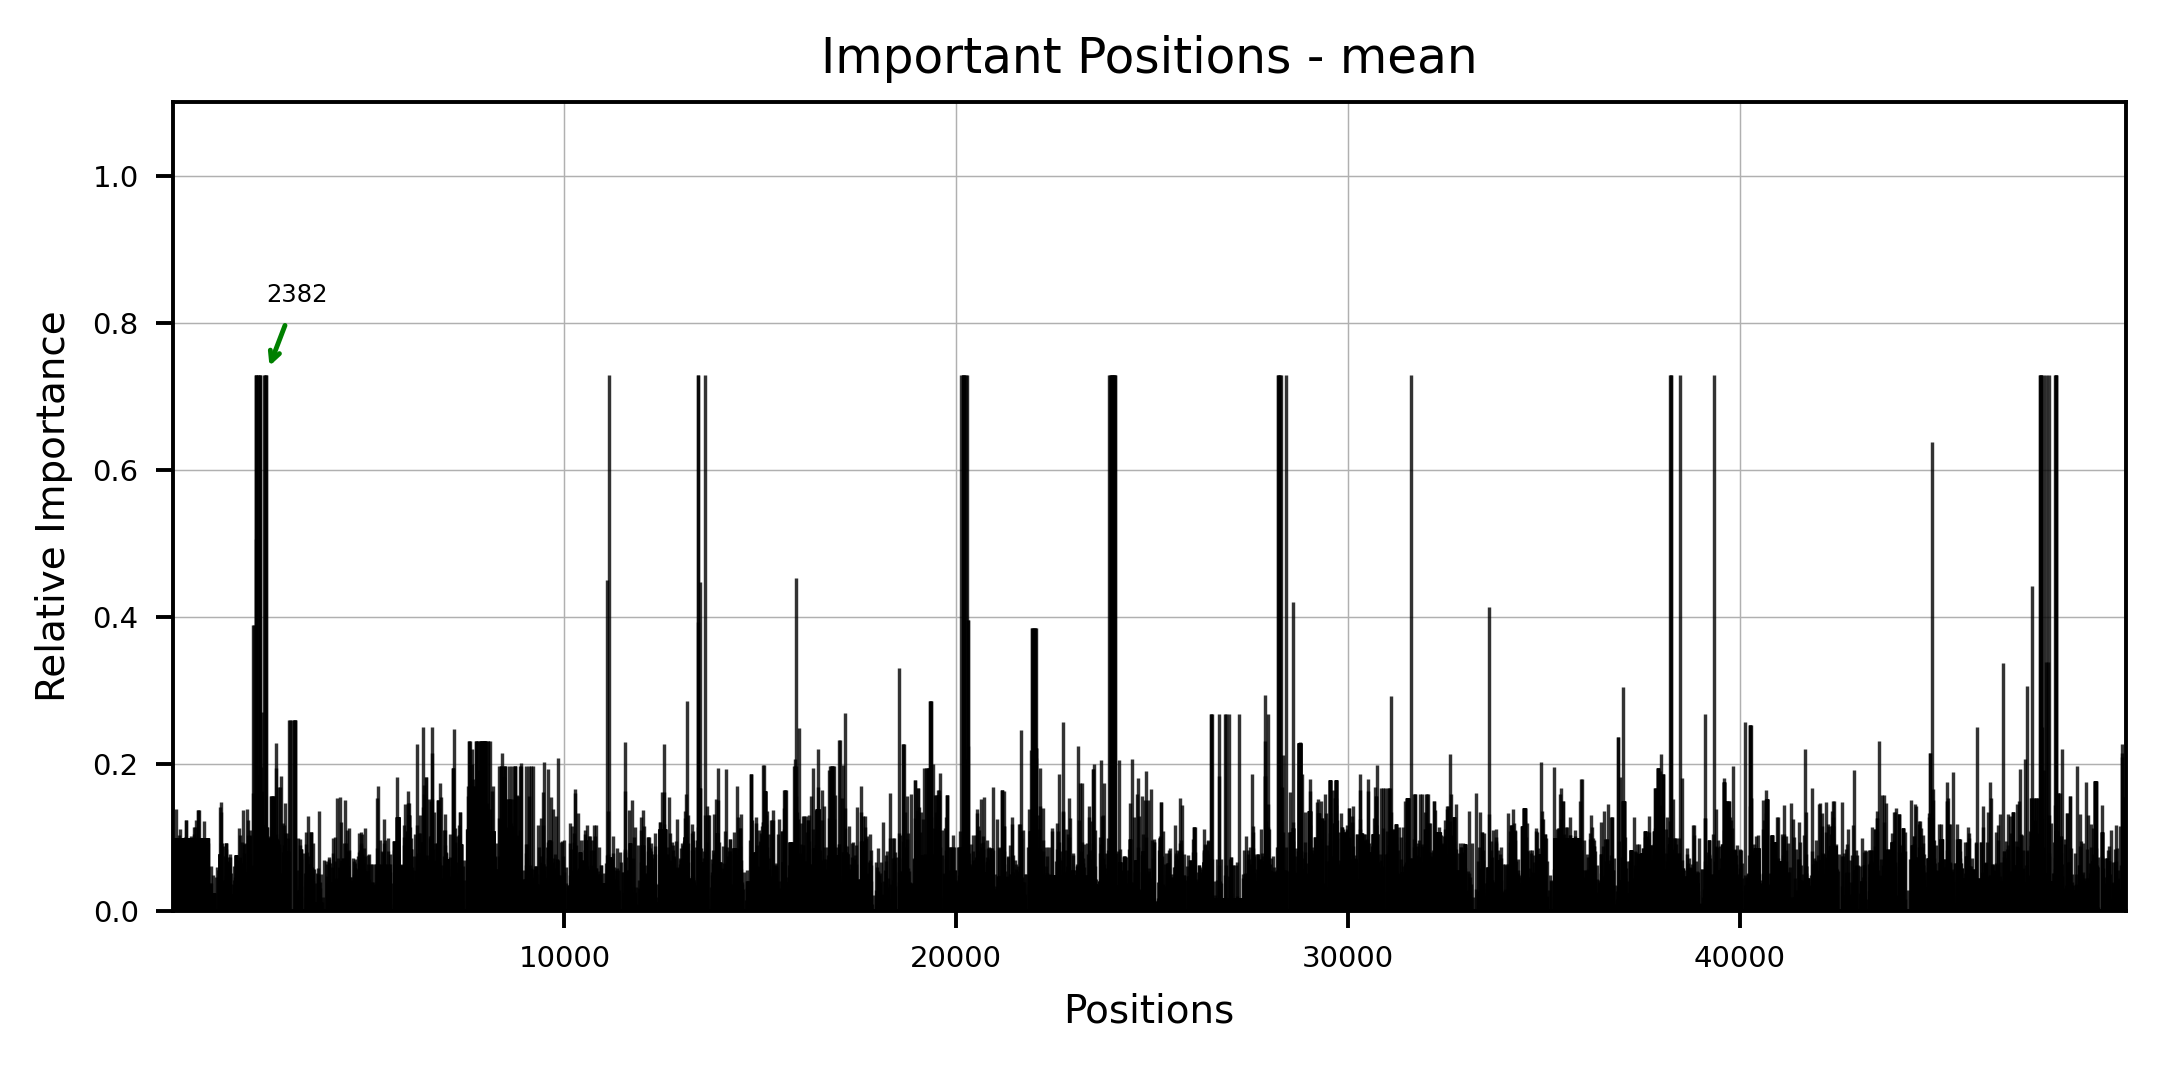

In [22]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)

In [23]:
tr = prep_pipeline[:4].fit_transform(tr)
y = le.inverse_transform(y)

gbc Done
gbc  Done
lg Done
lg  Done
rf Done
rf  Done


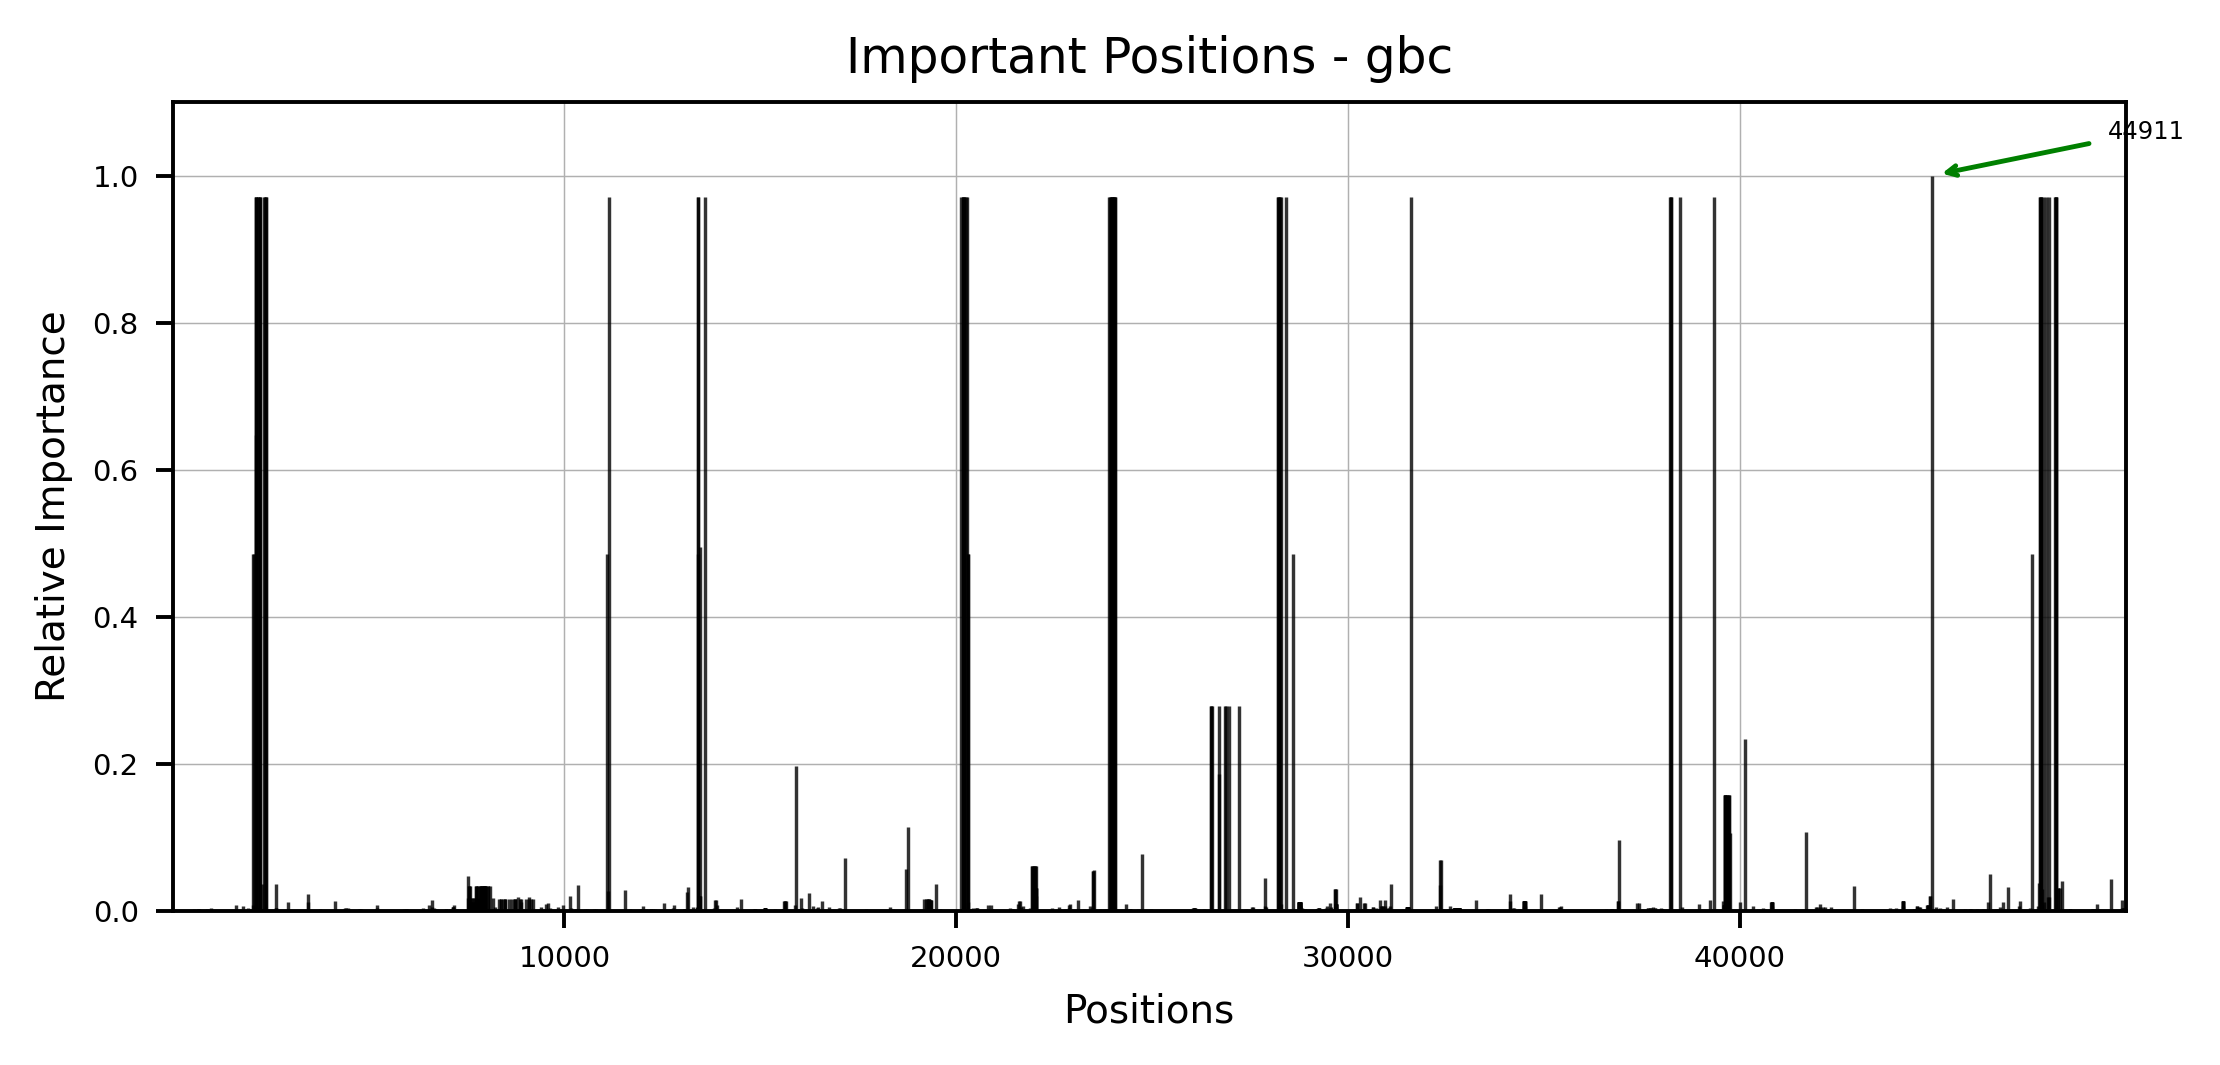

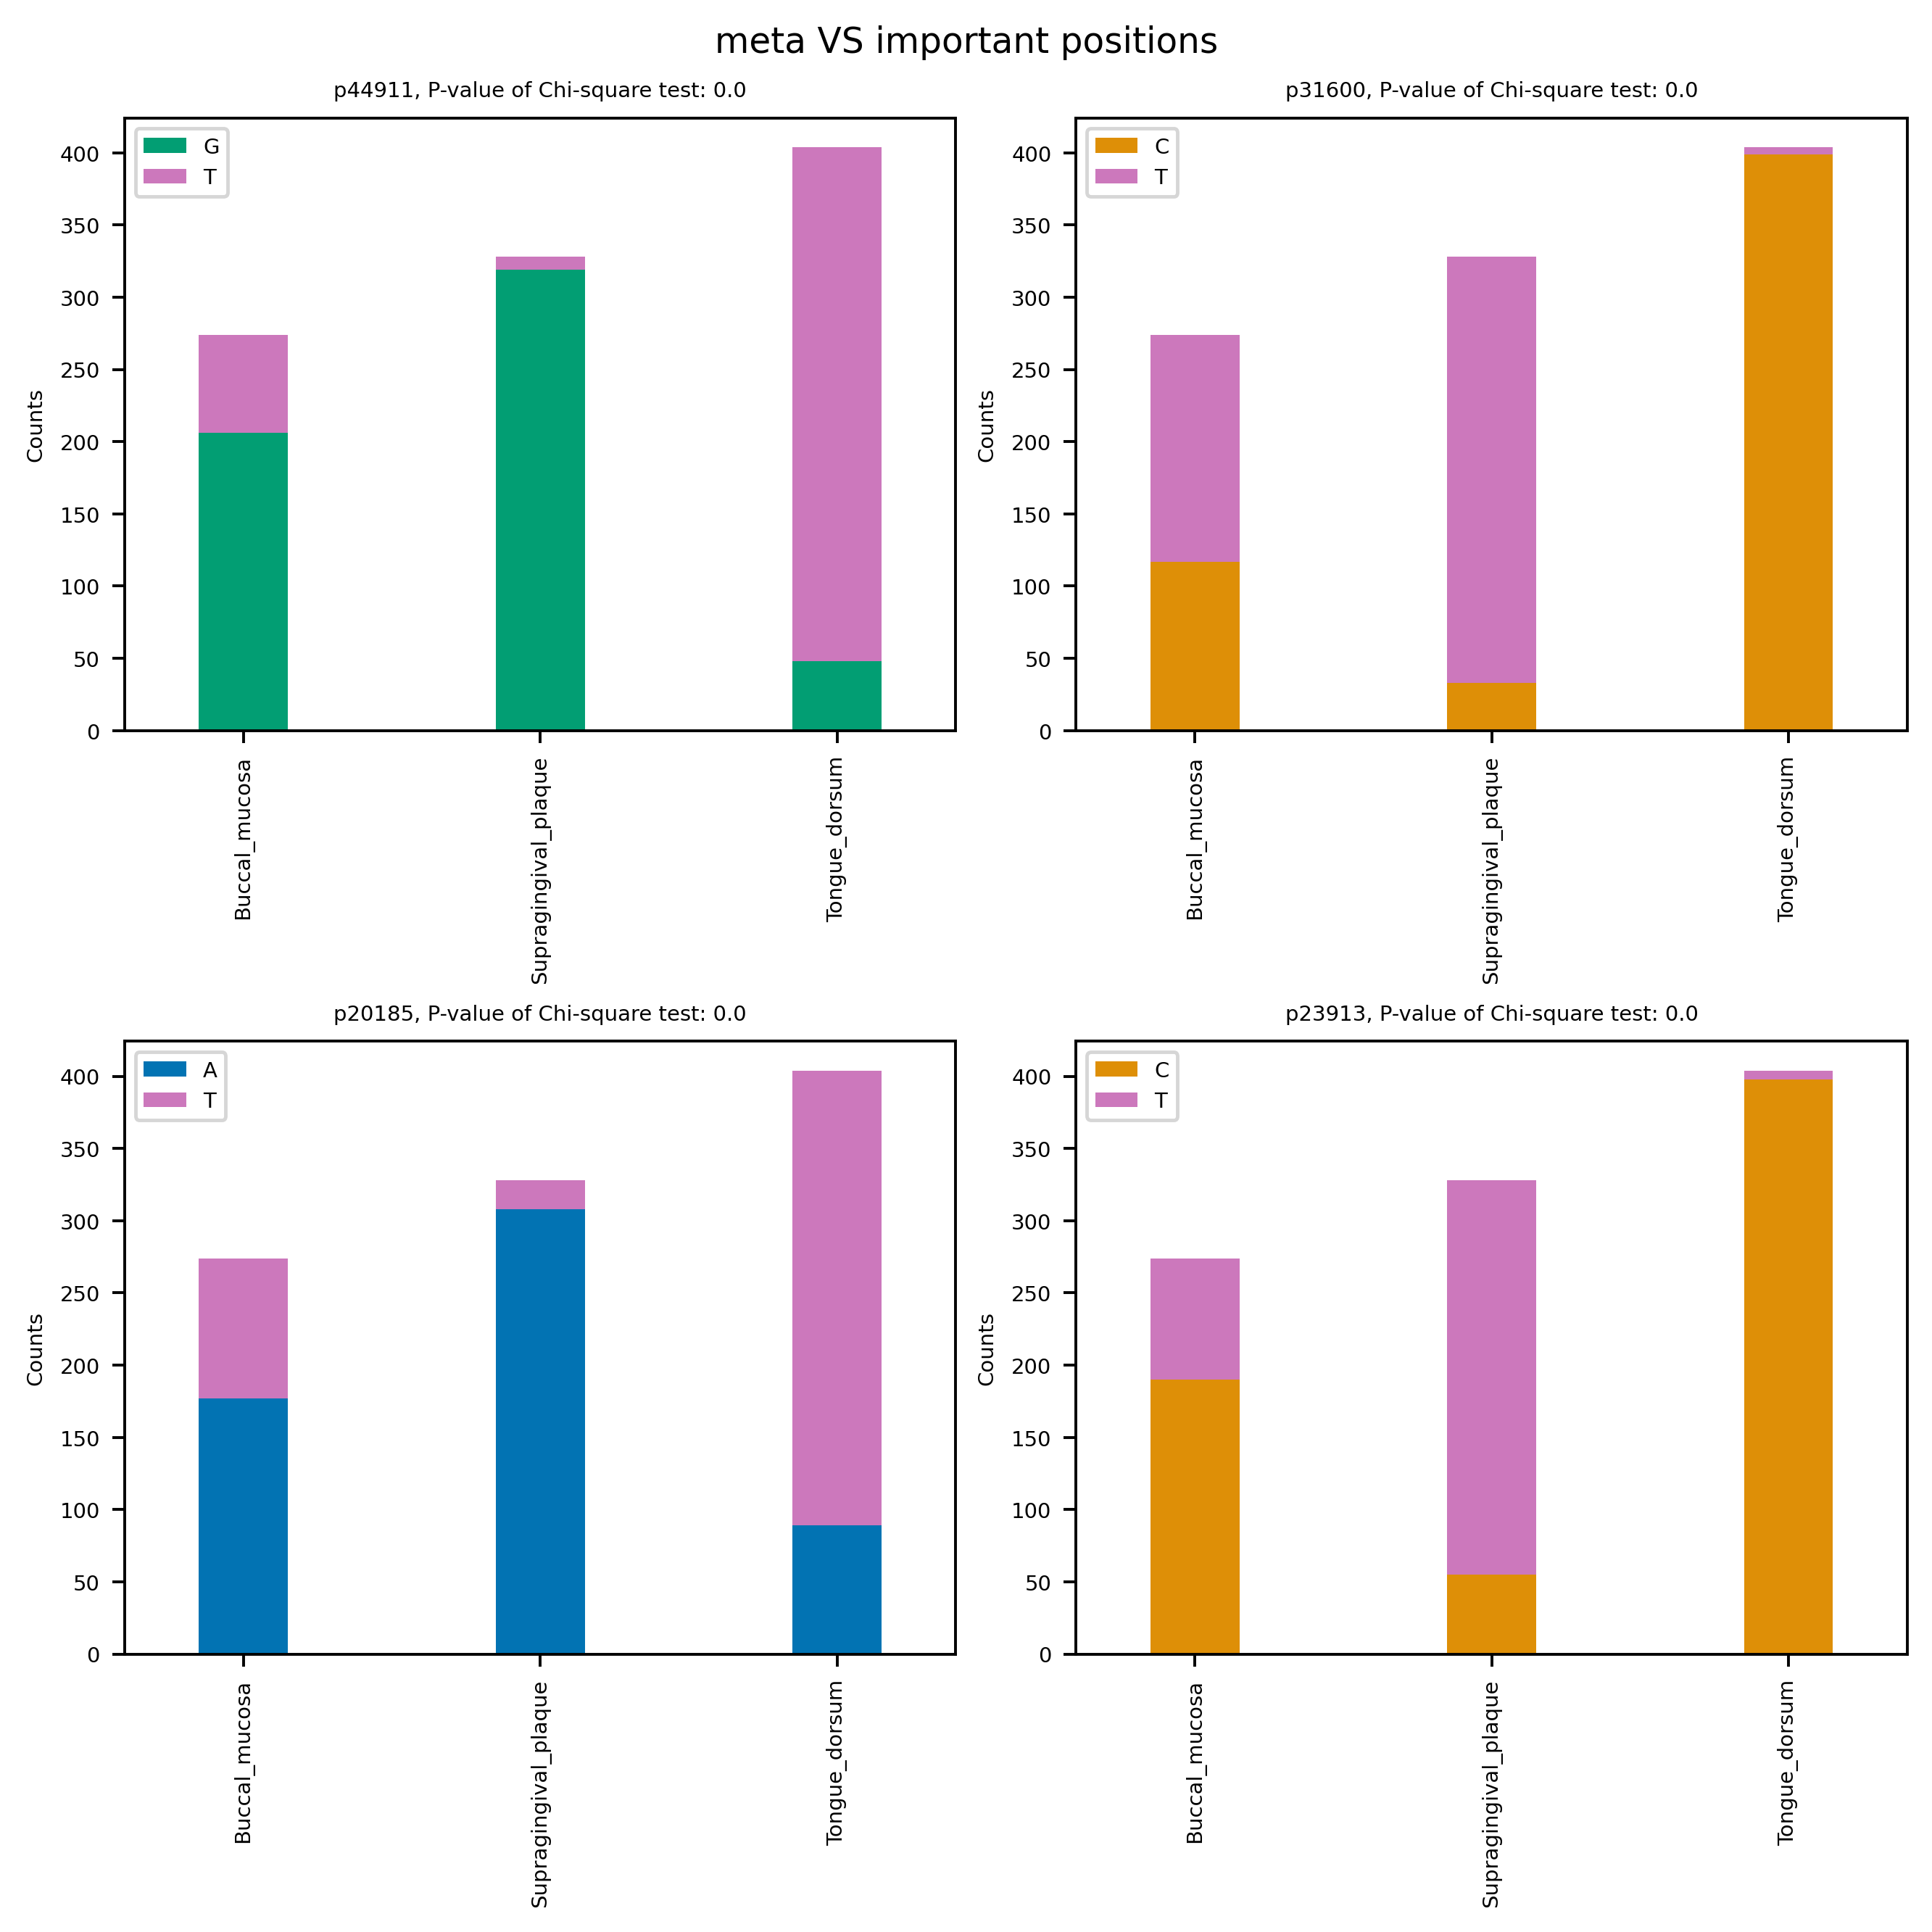

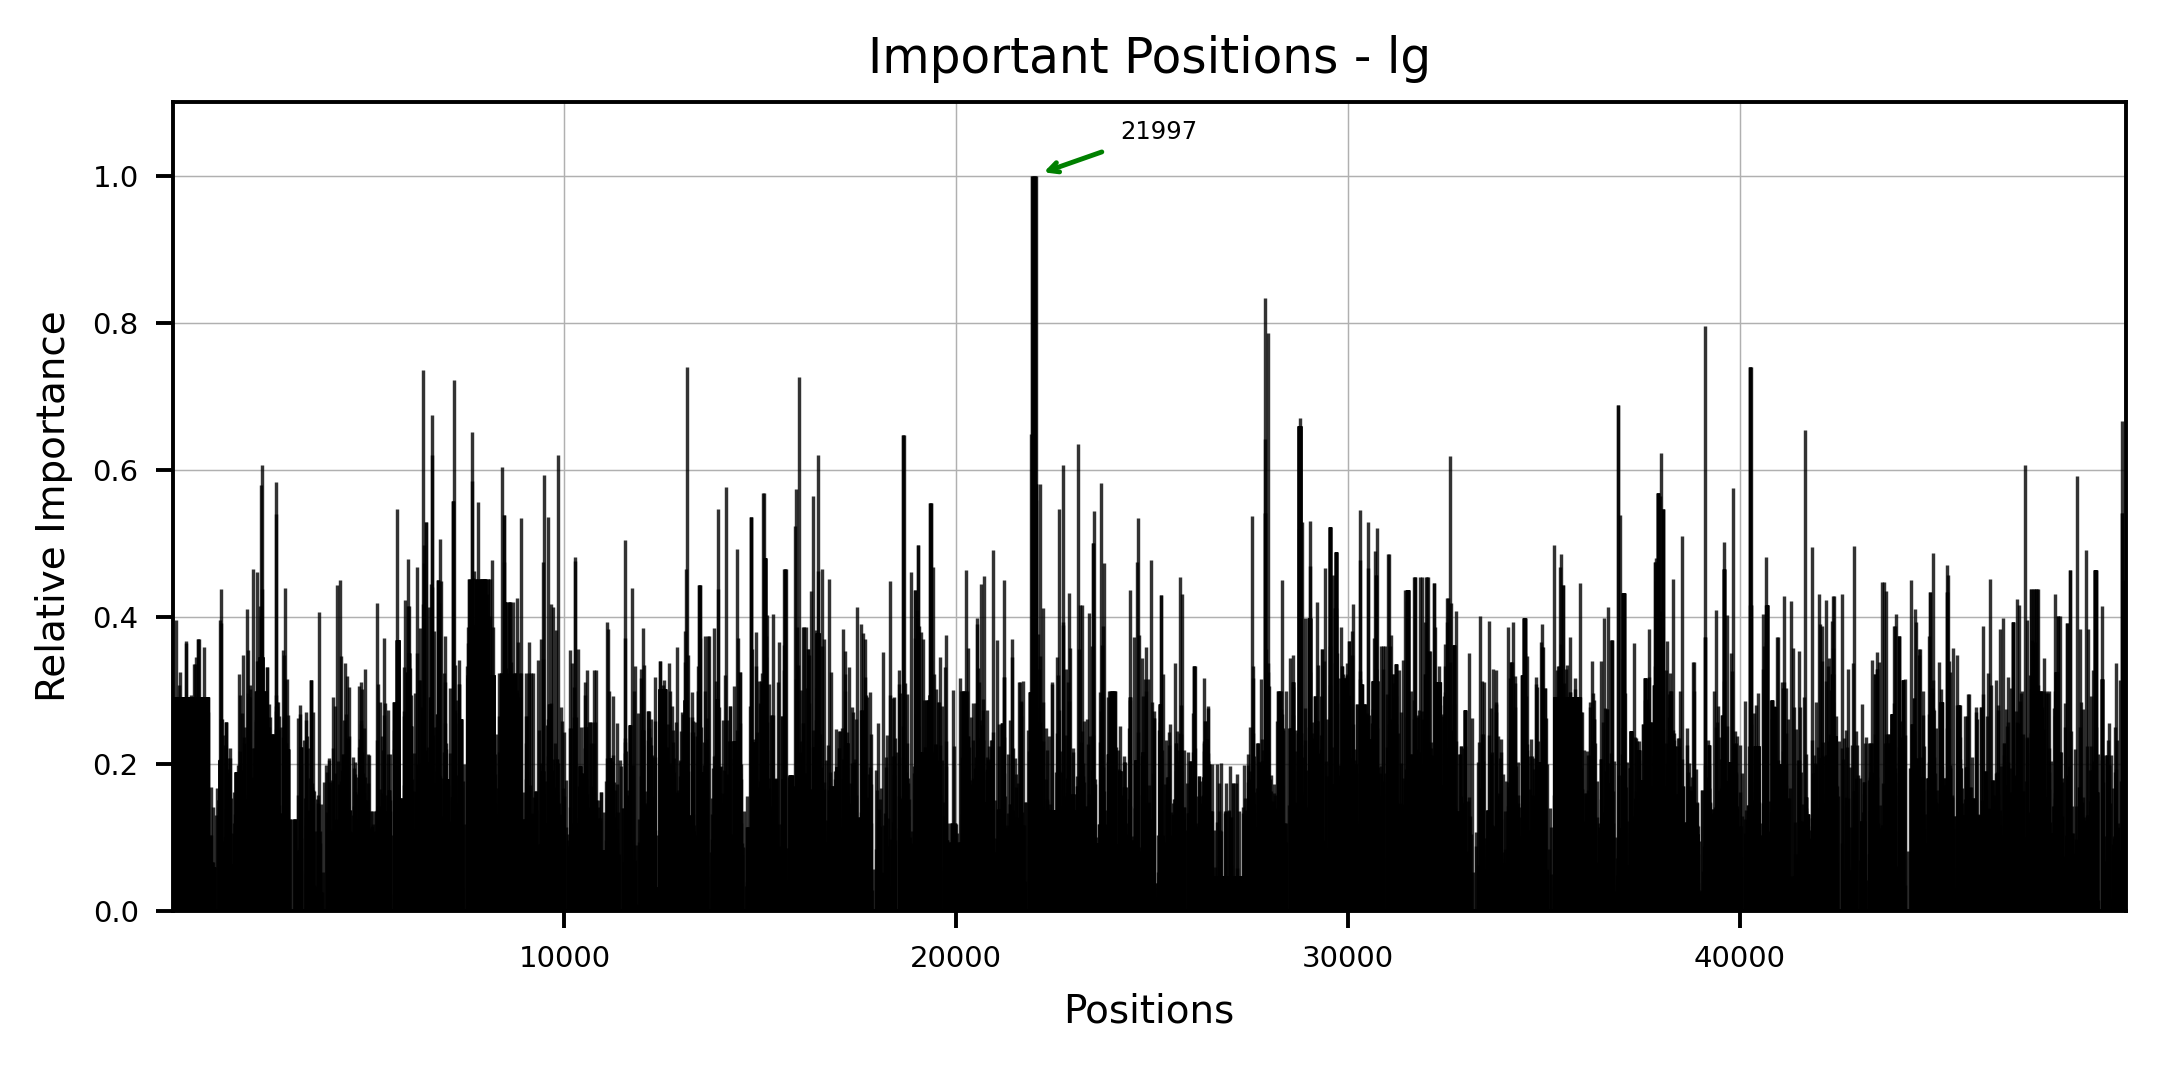

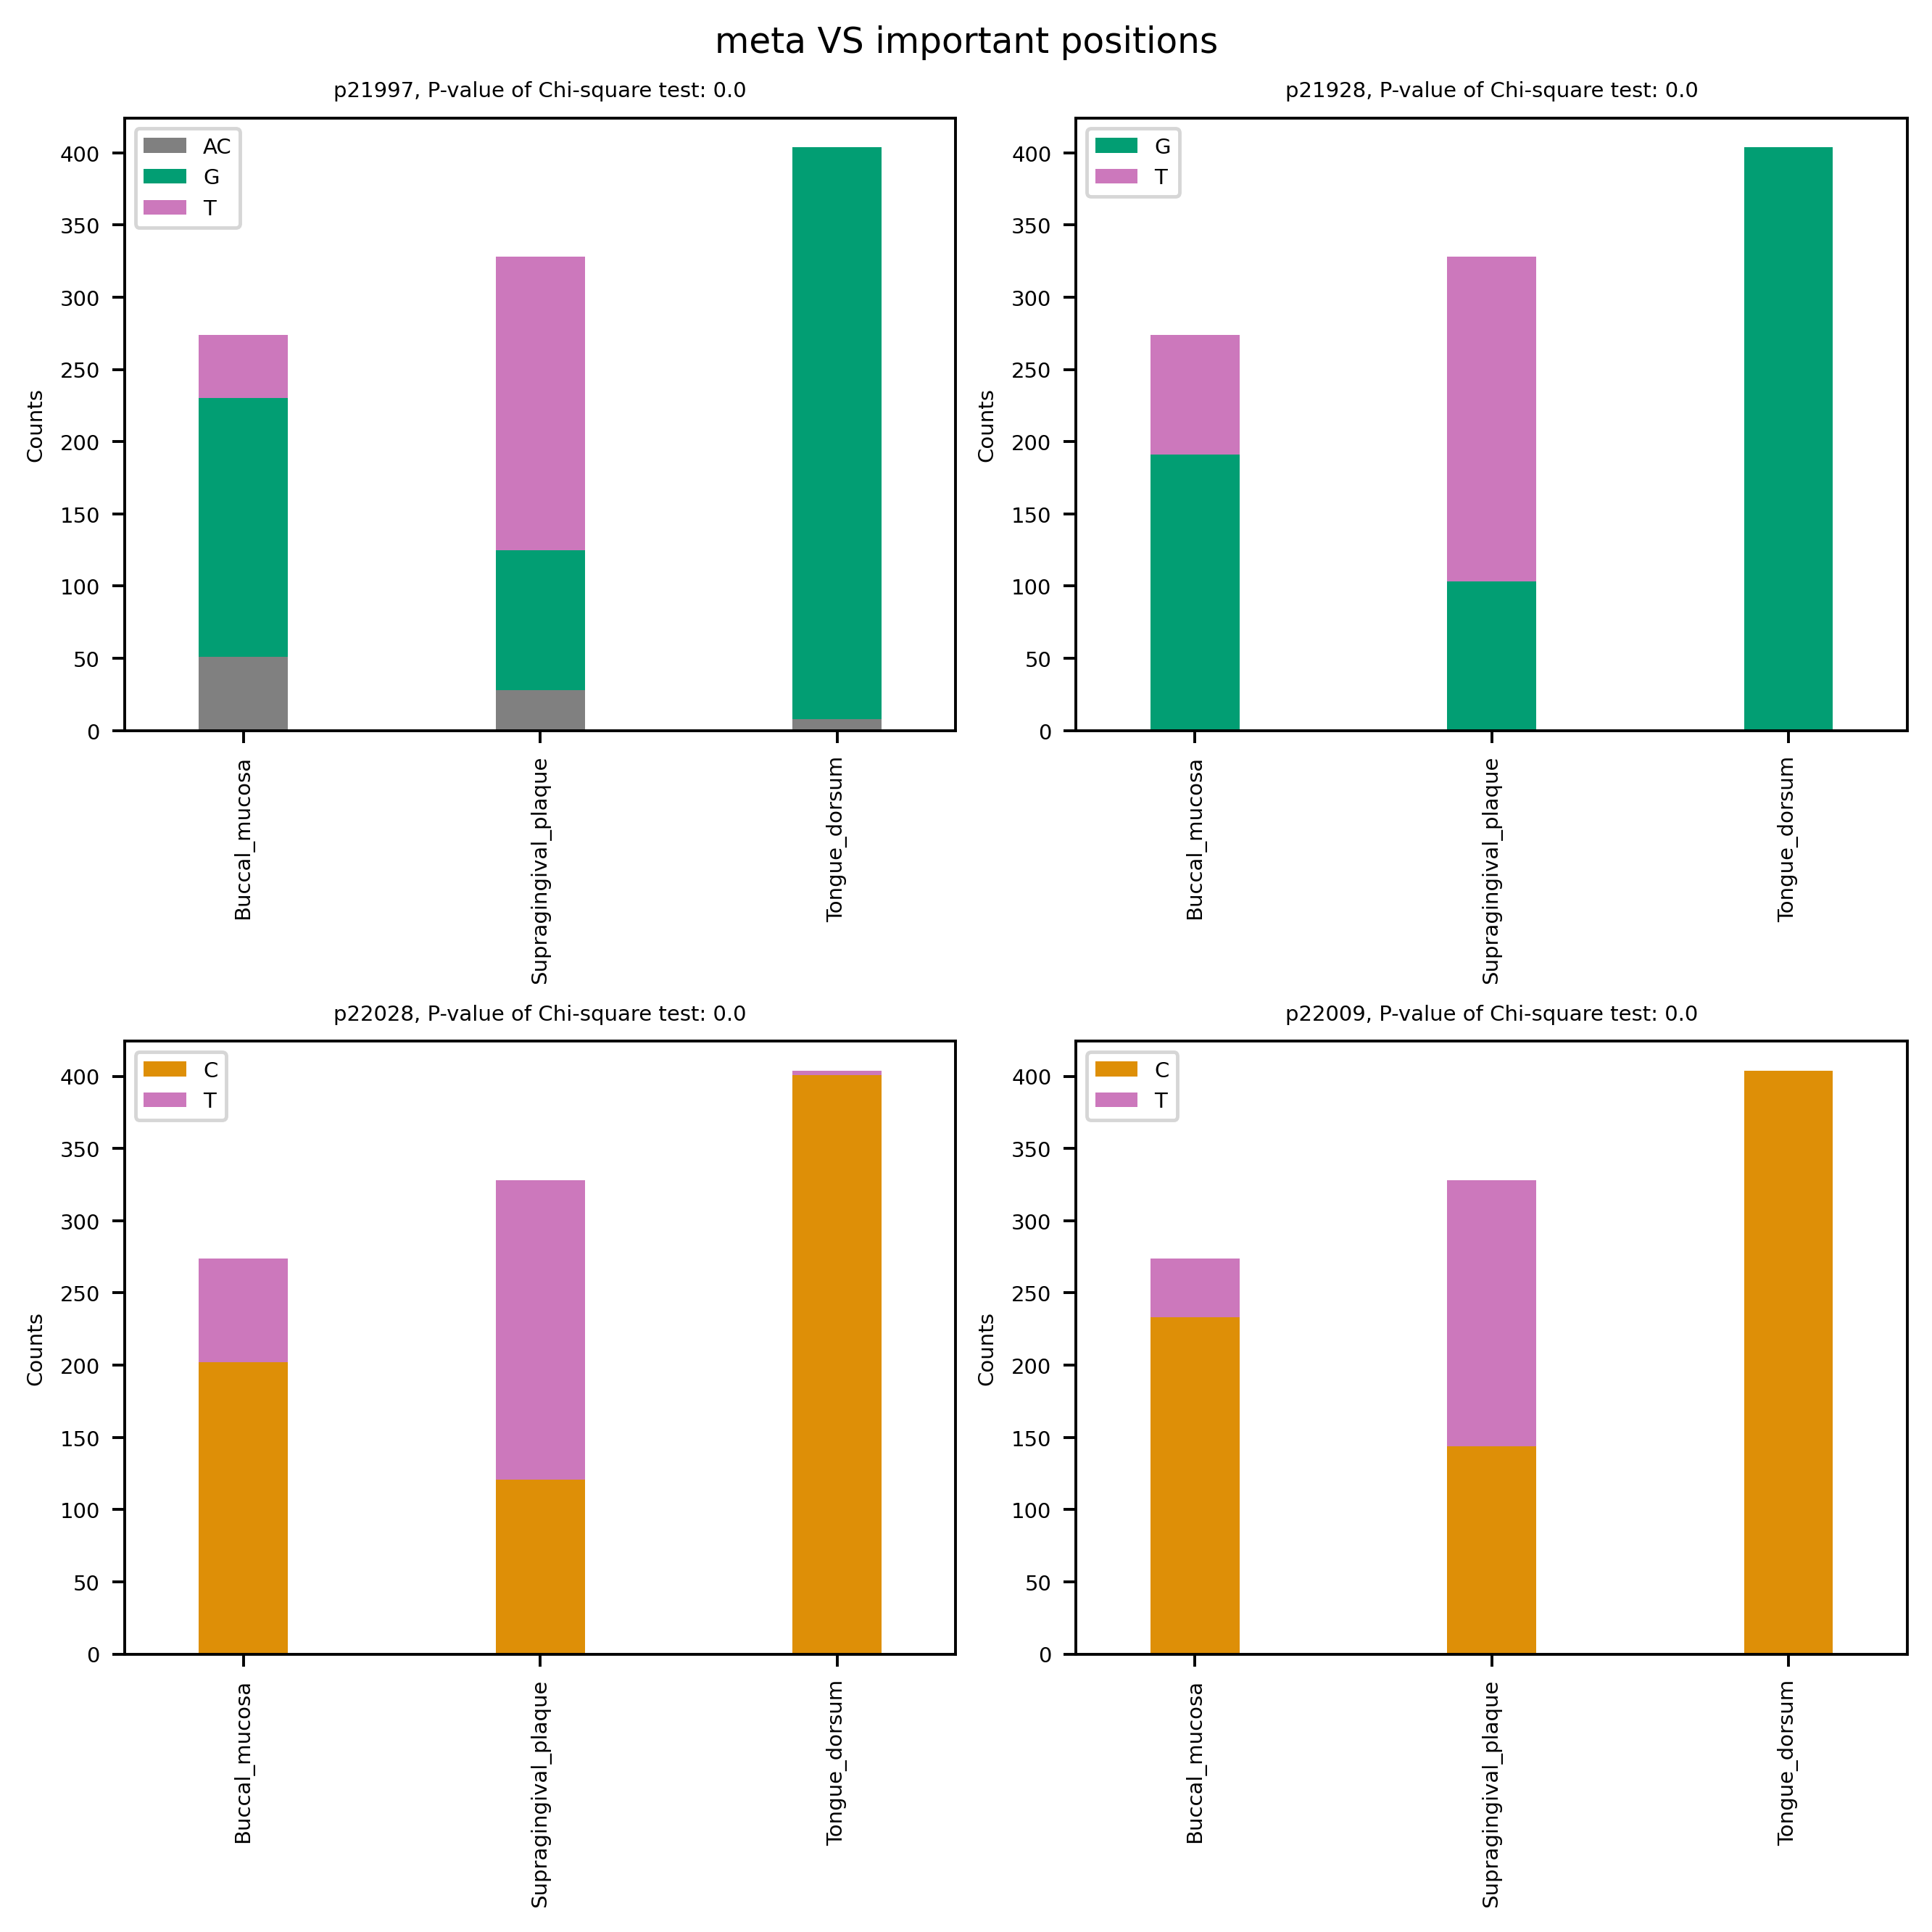

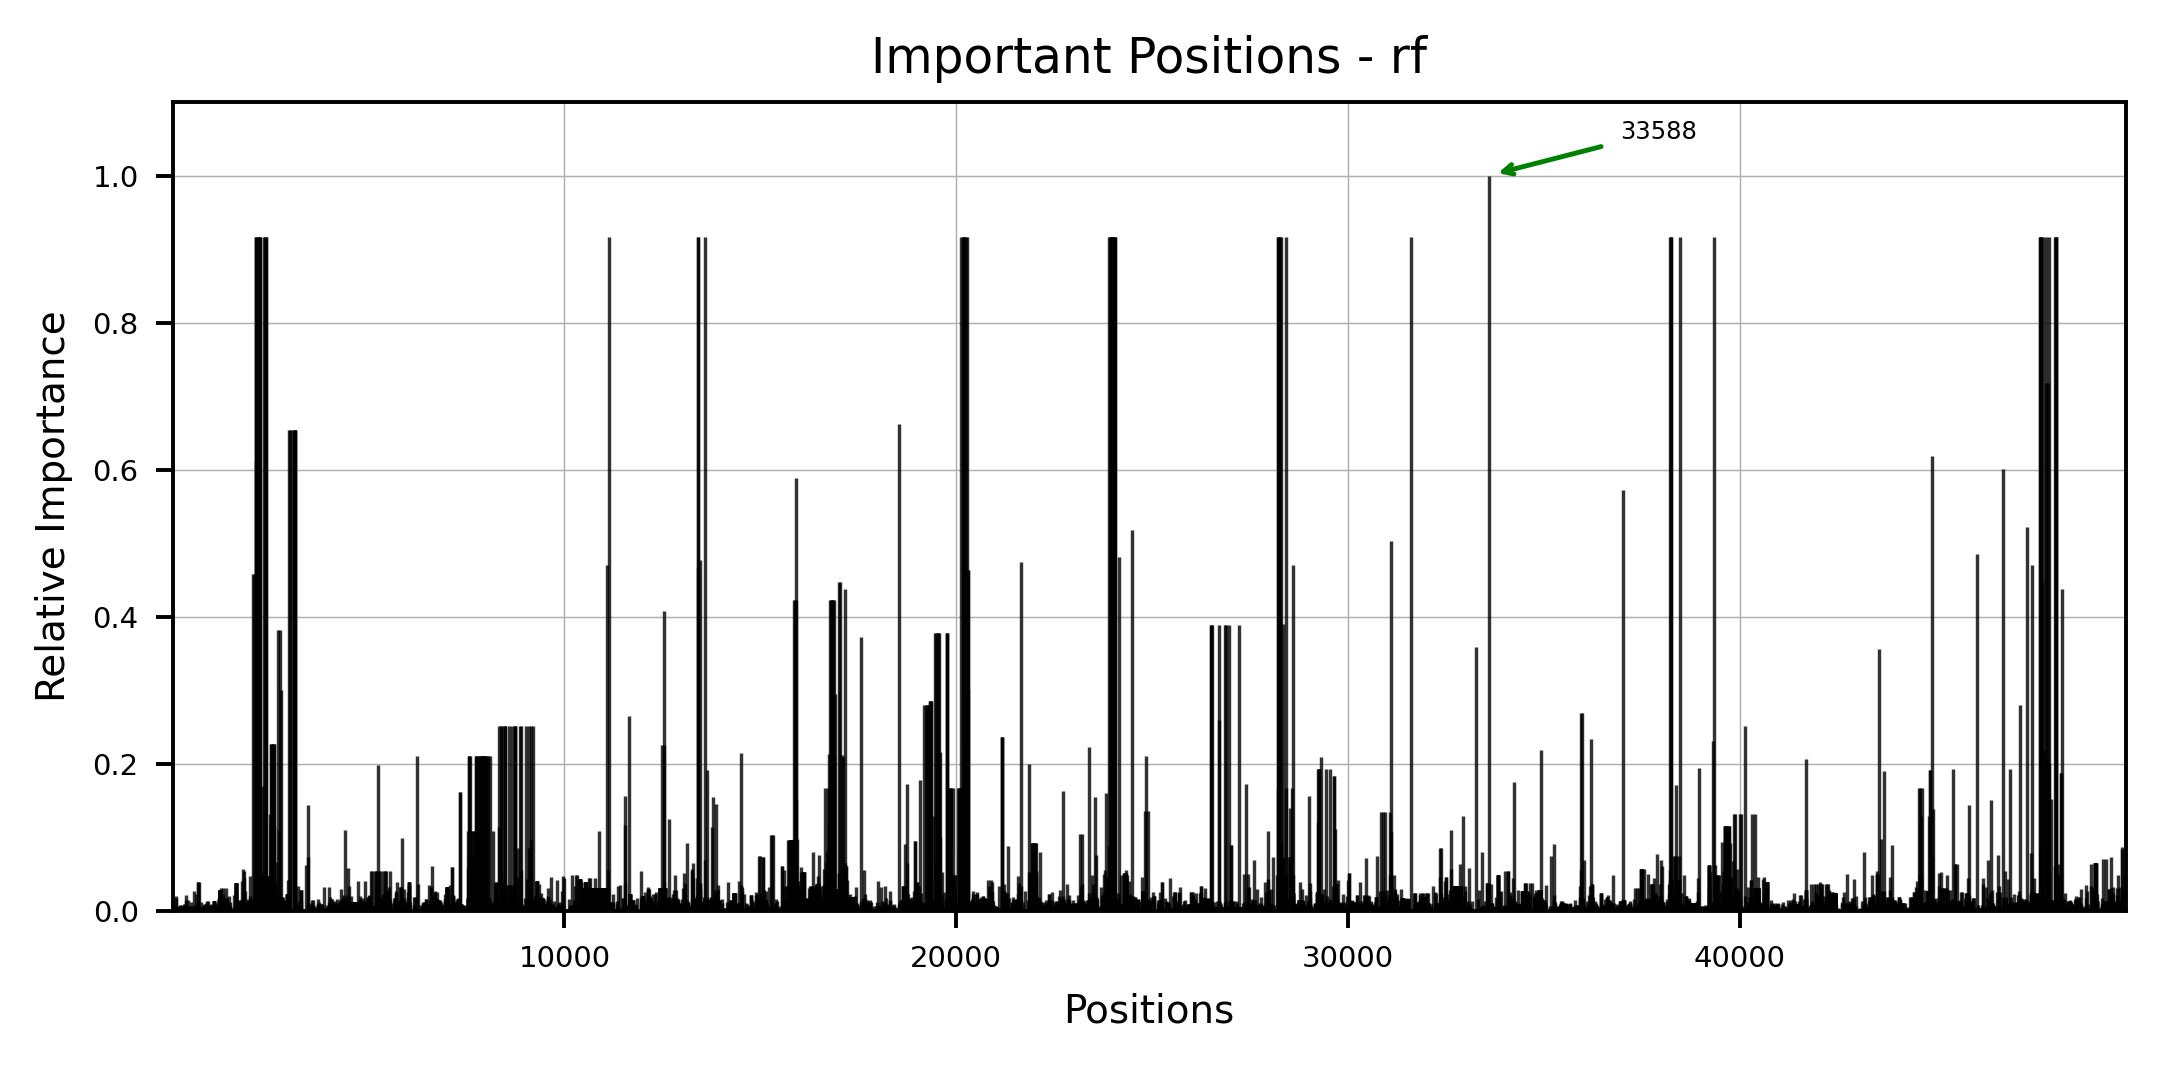

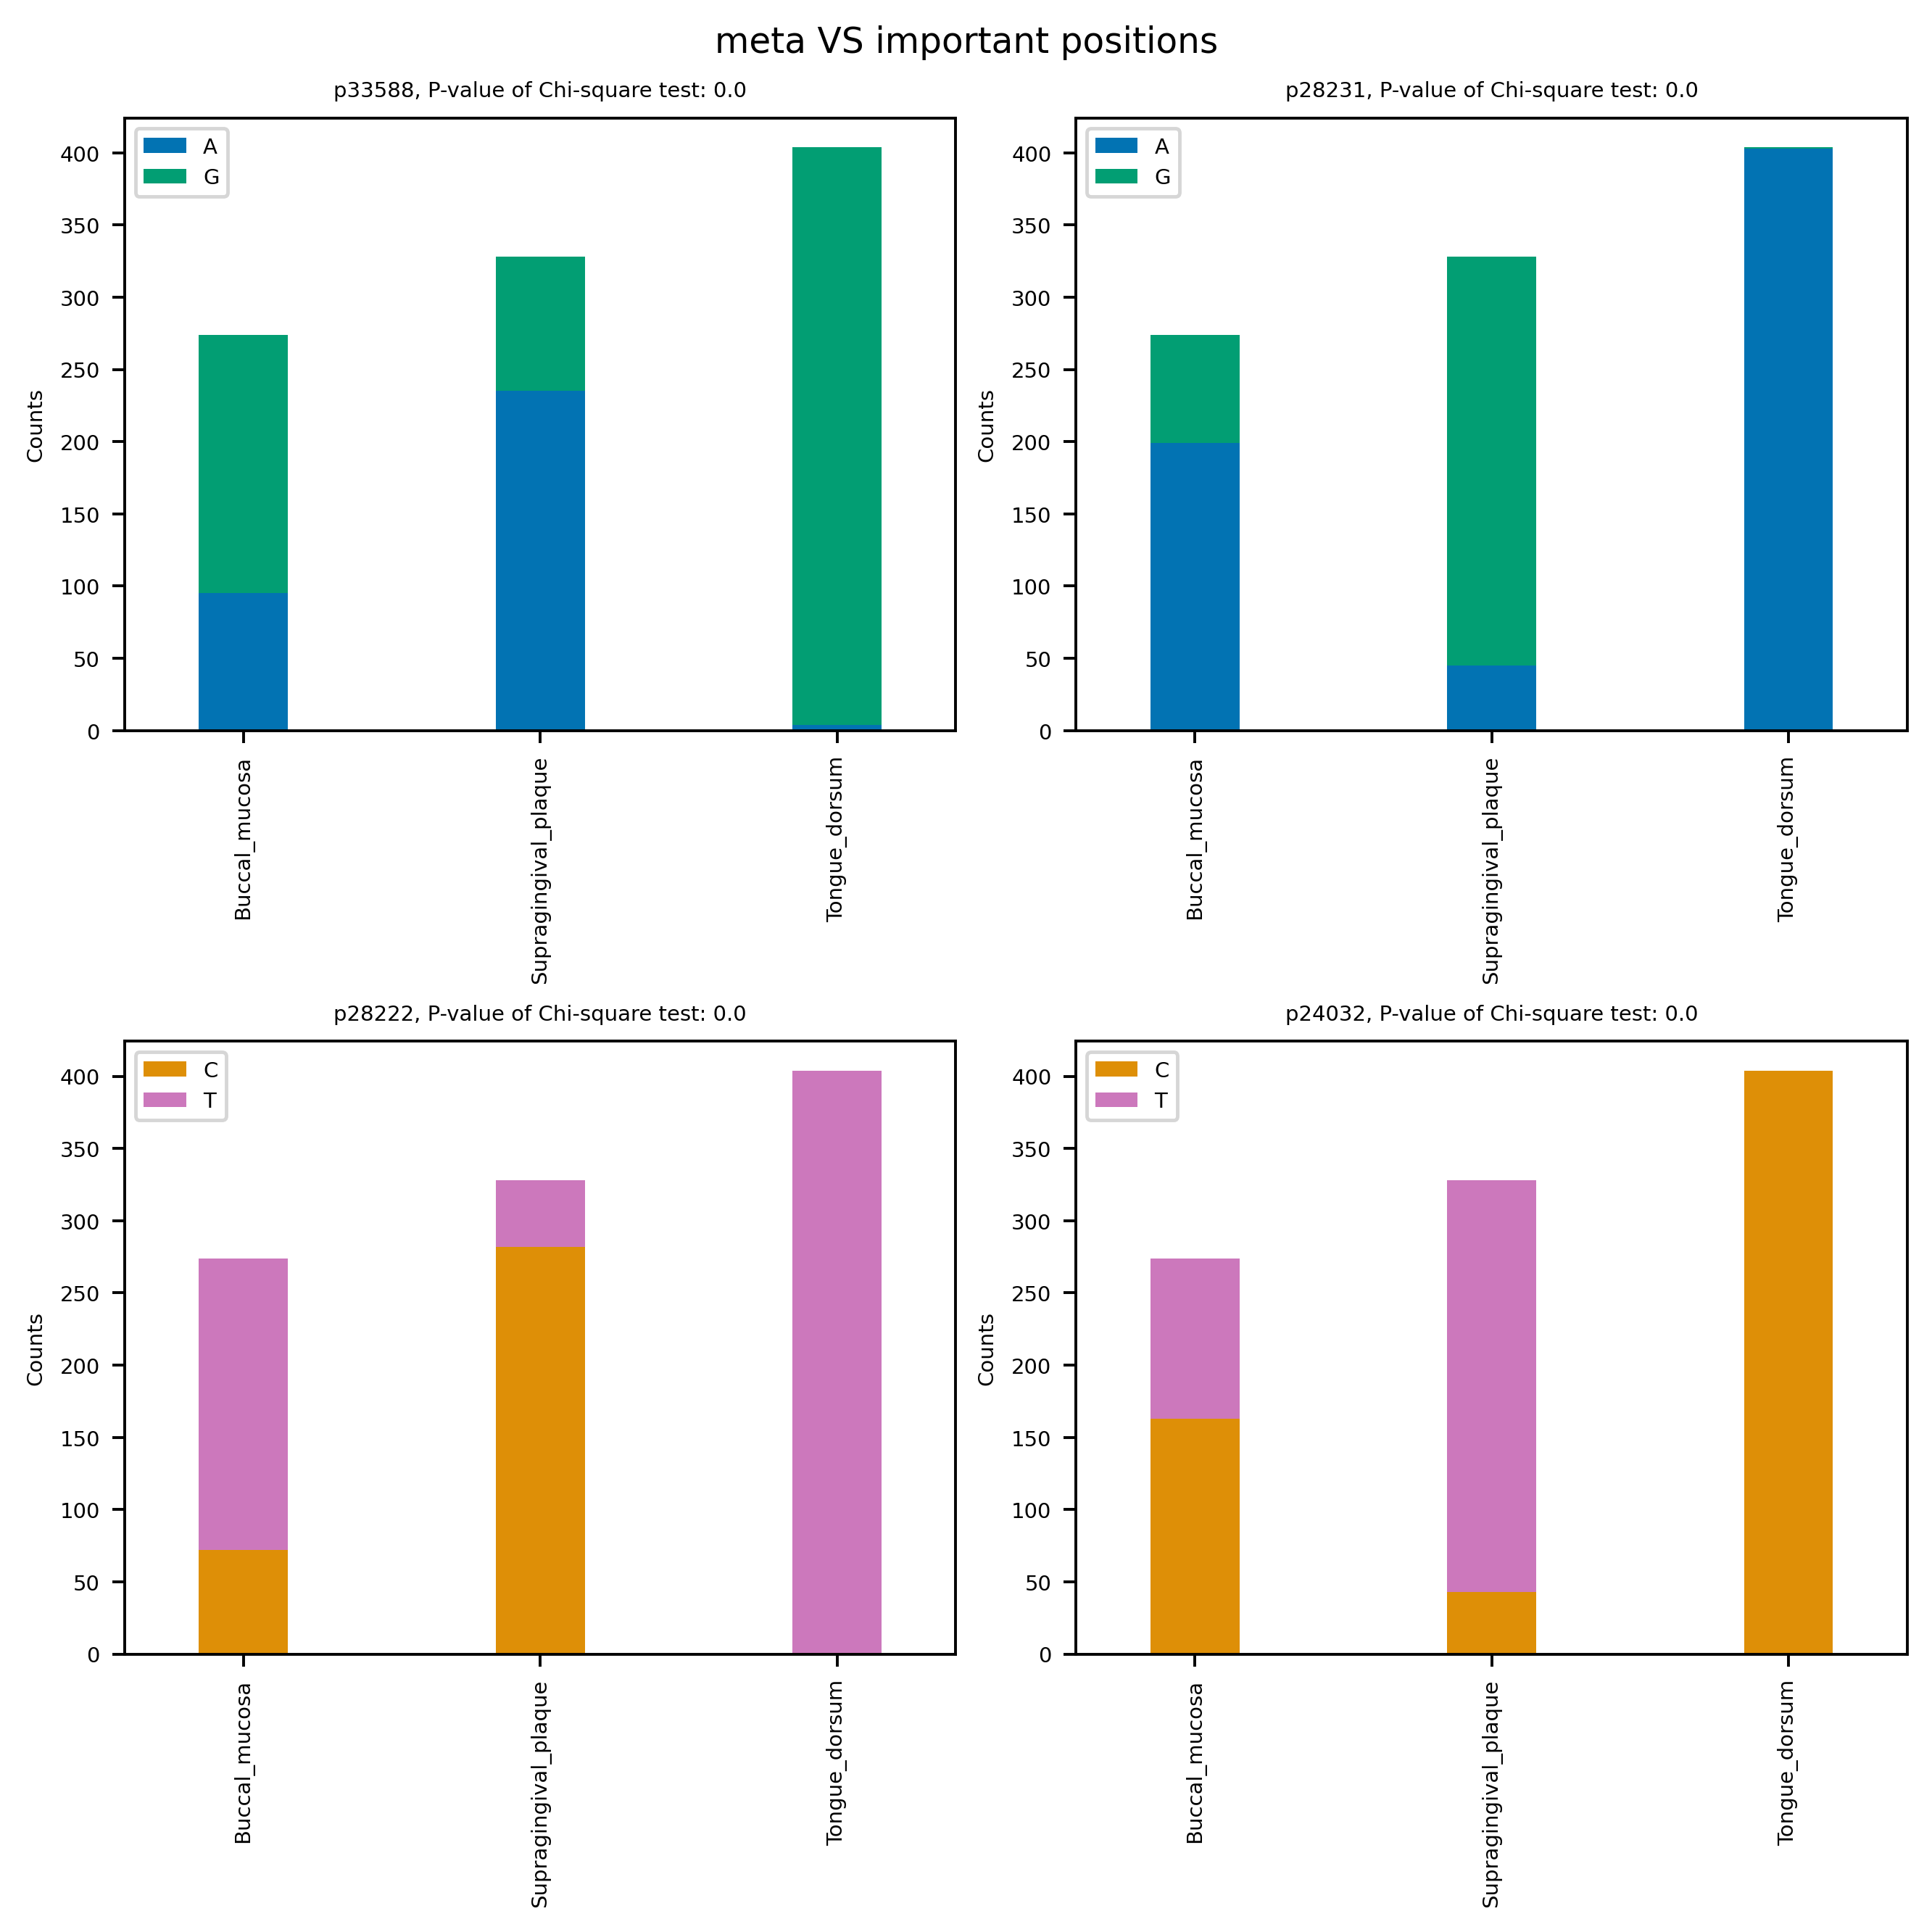

In [24]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model), 
               X_train=tr, y_train=y, model_name=model_name,
                   meta_var='meta', model_type=ana_type, report_dir=report_dir)

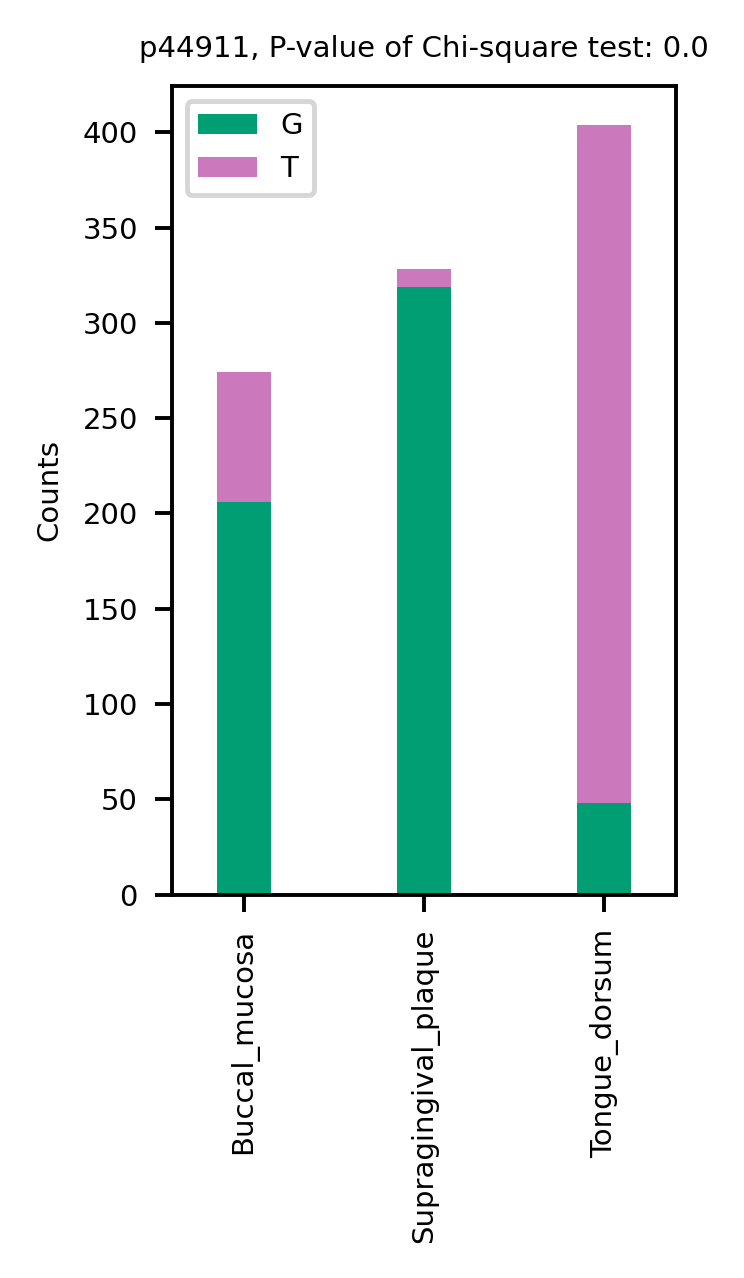

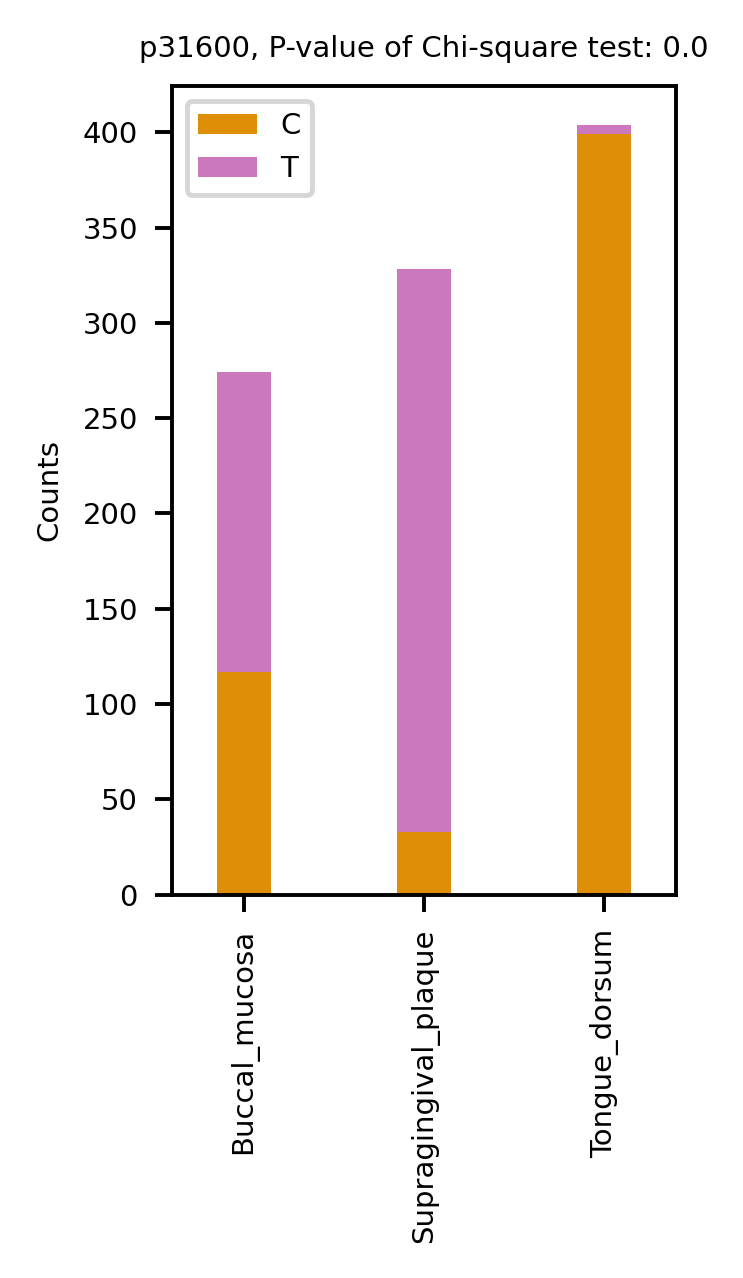

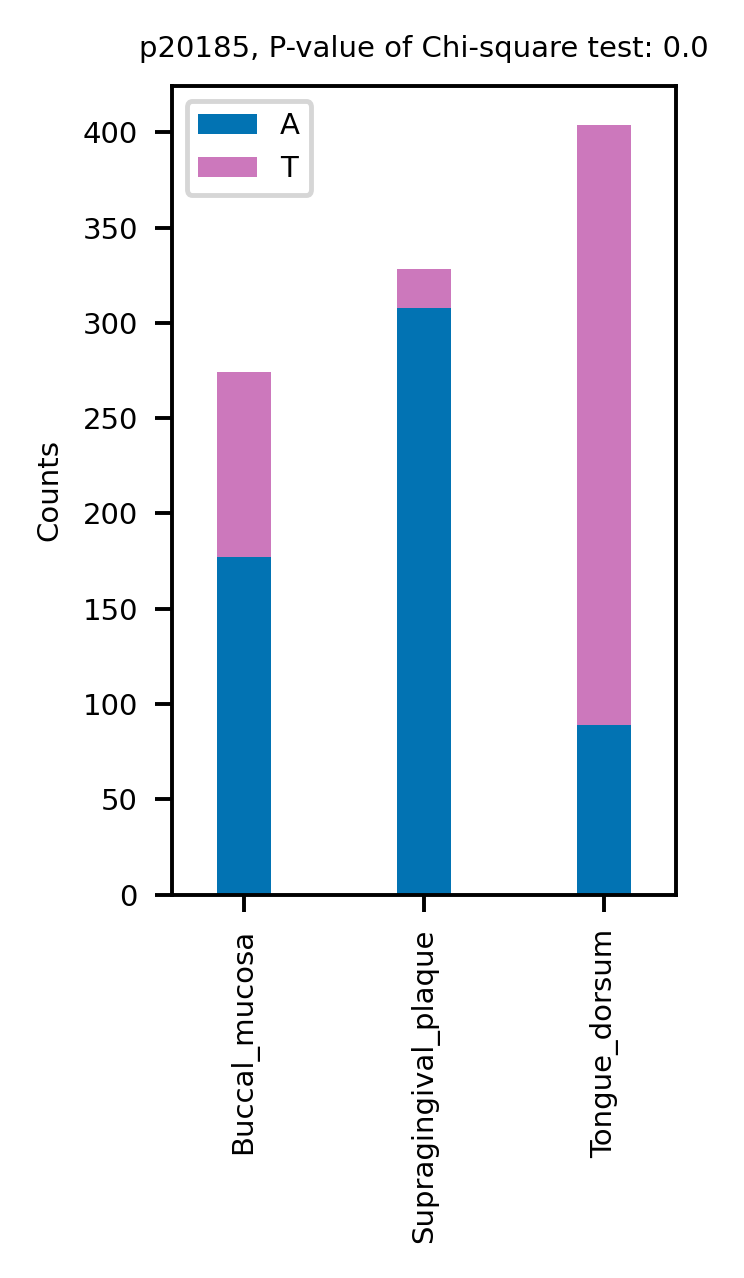

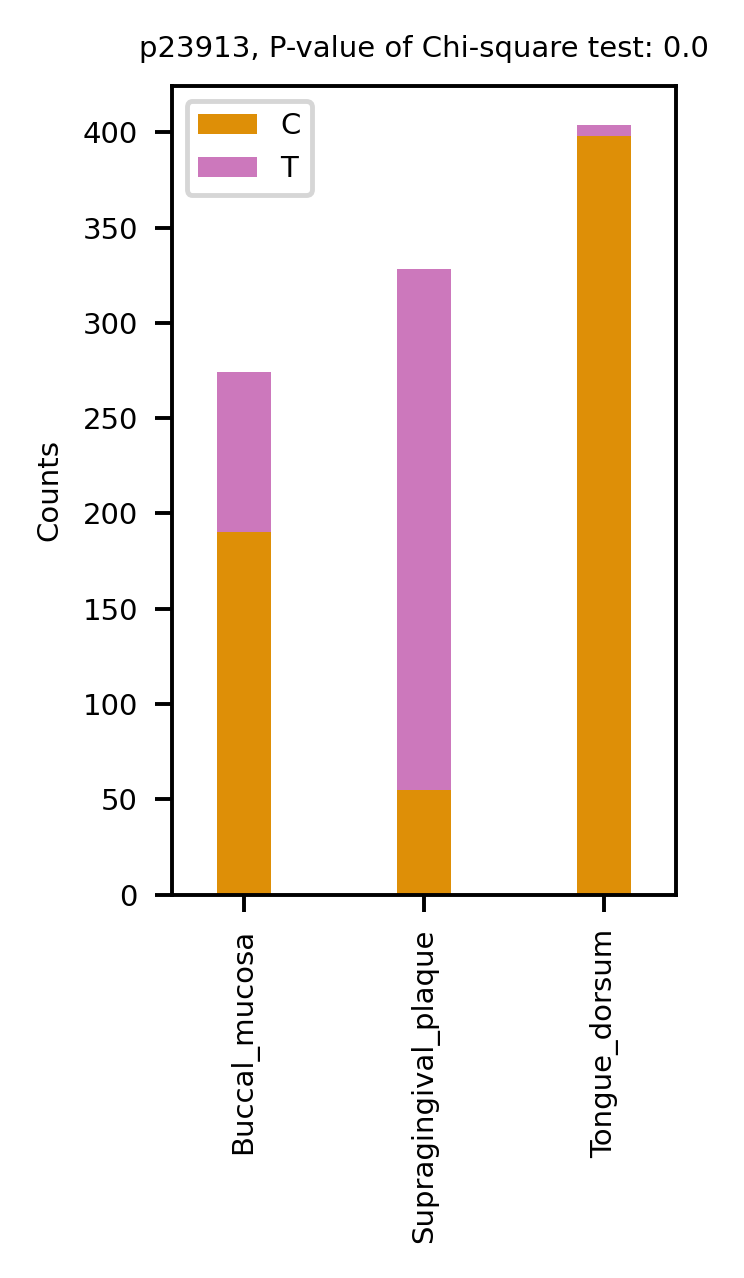

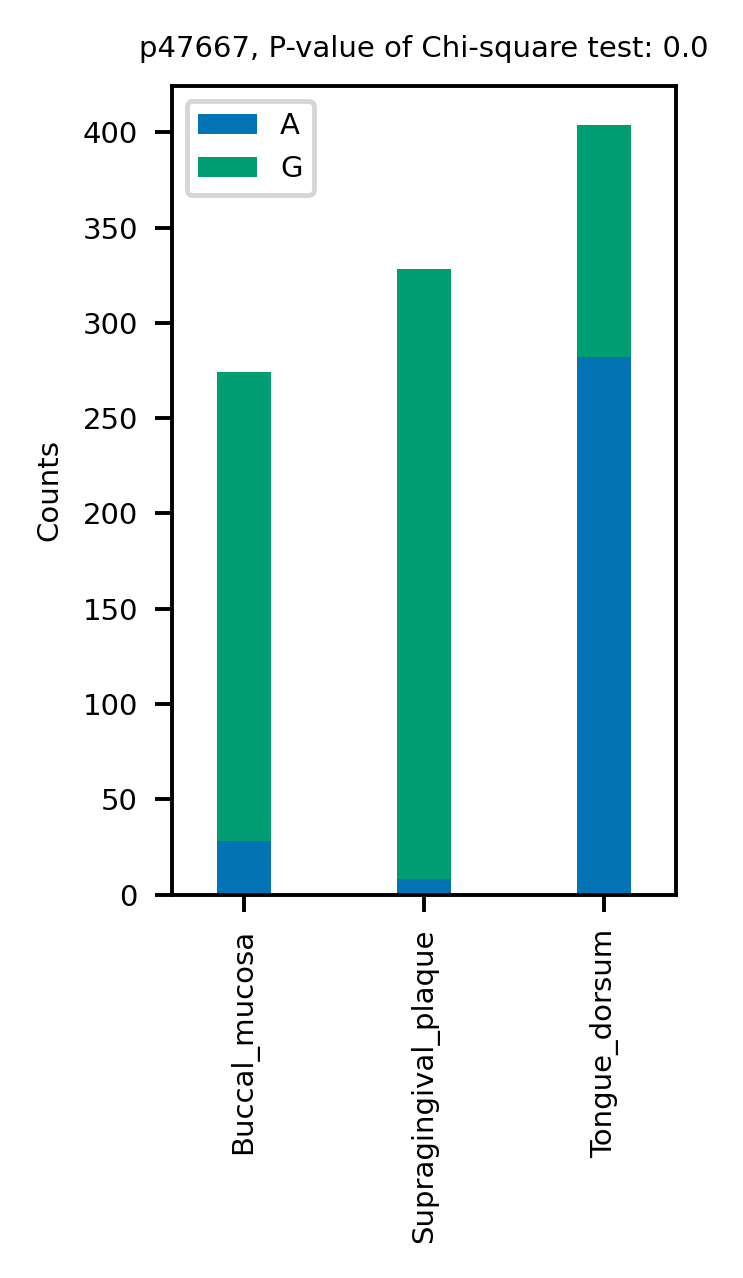

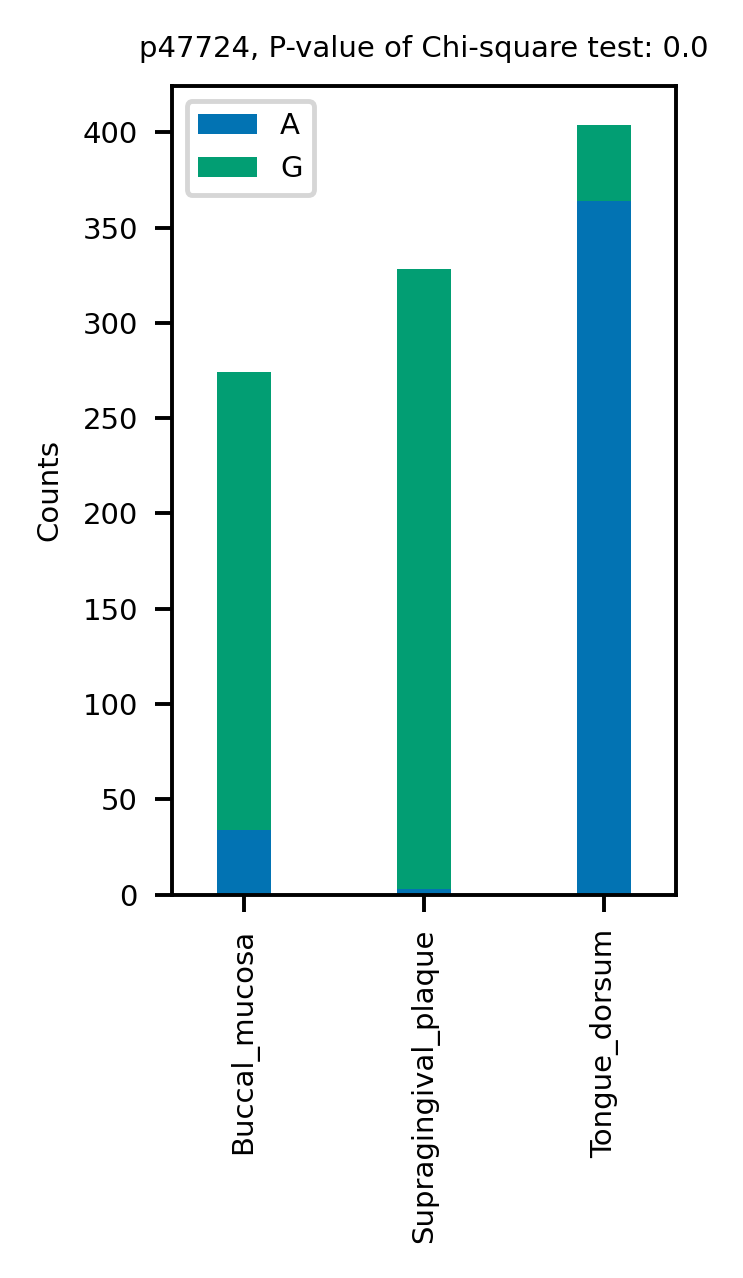

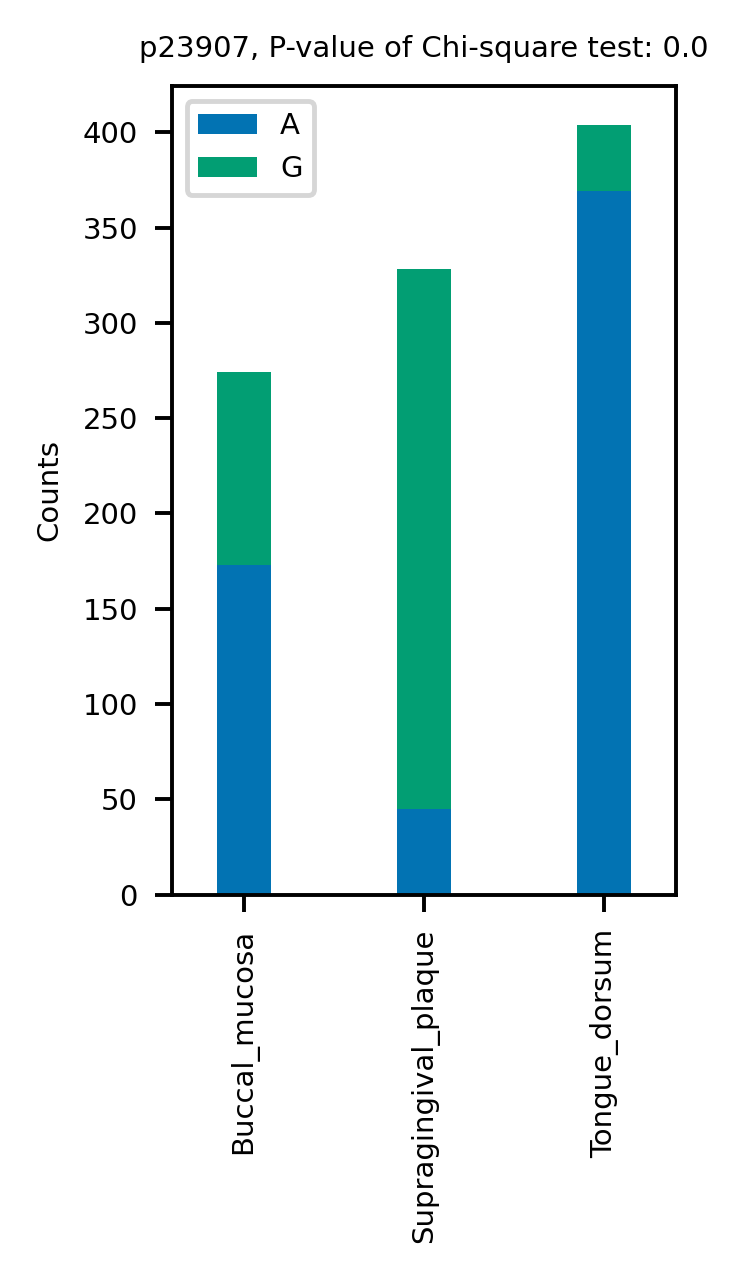

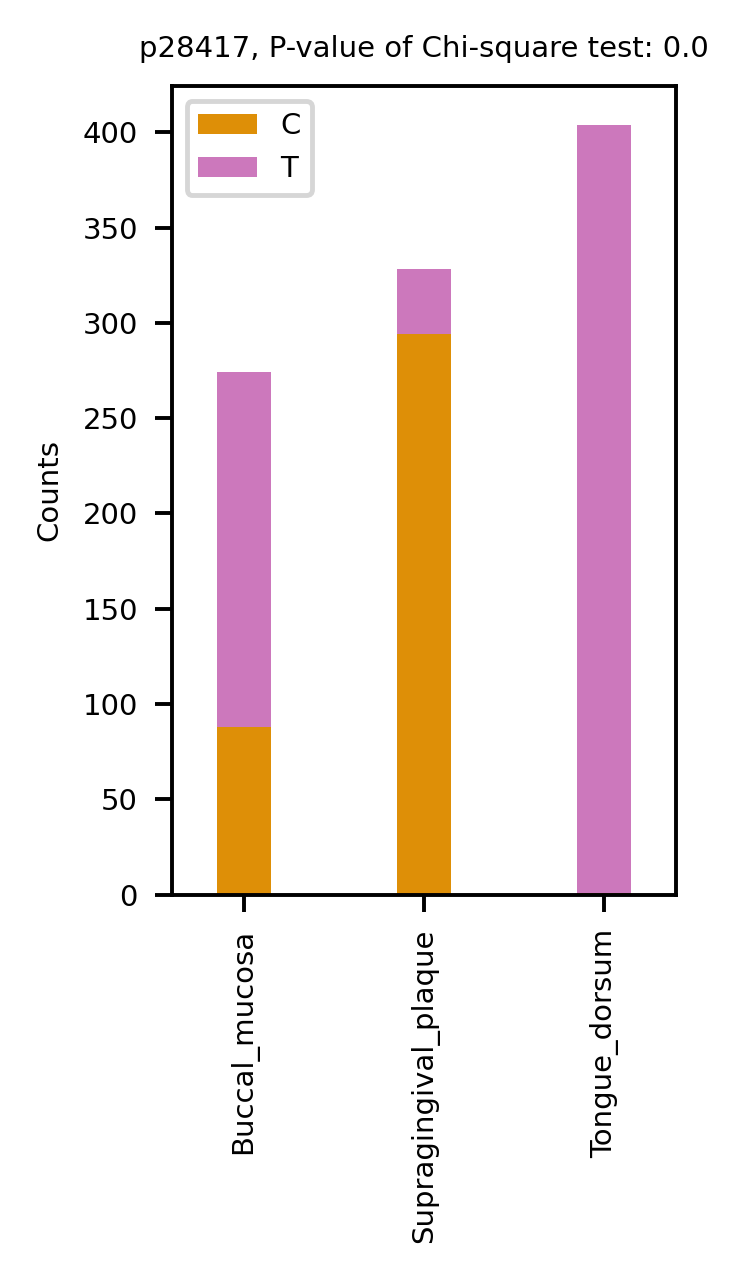

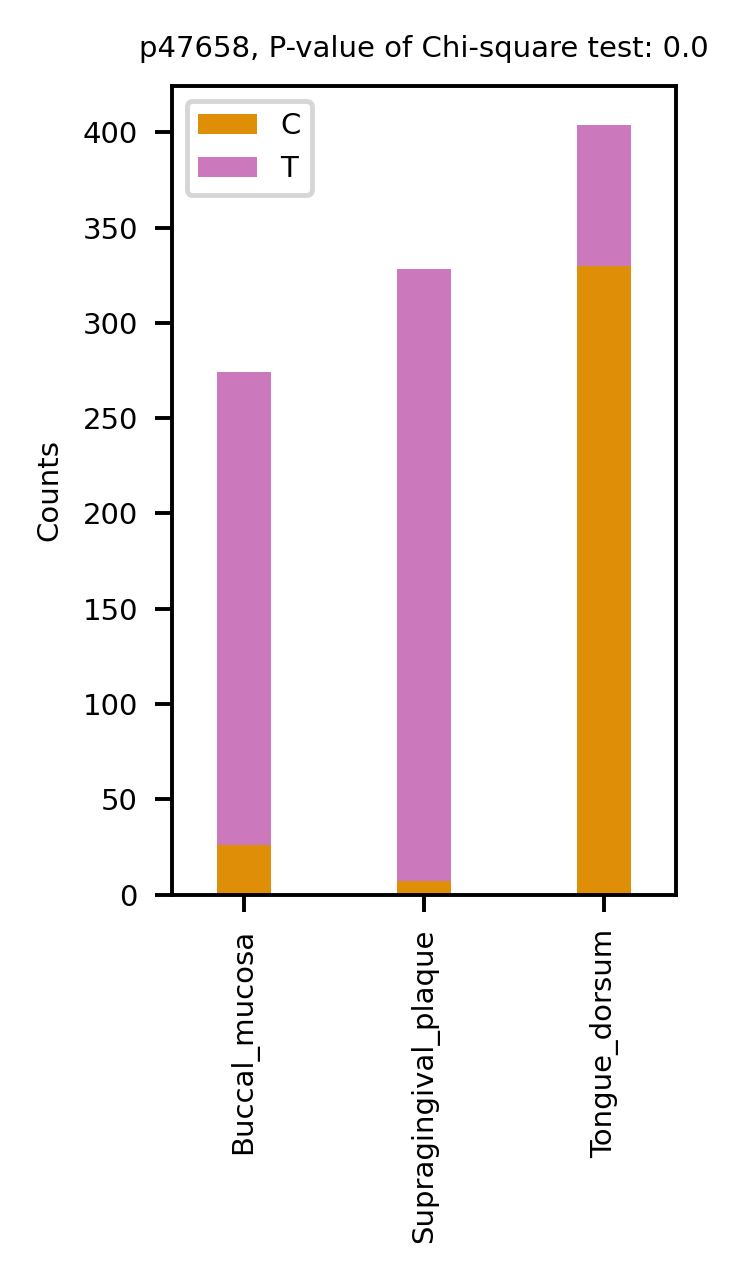

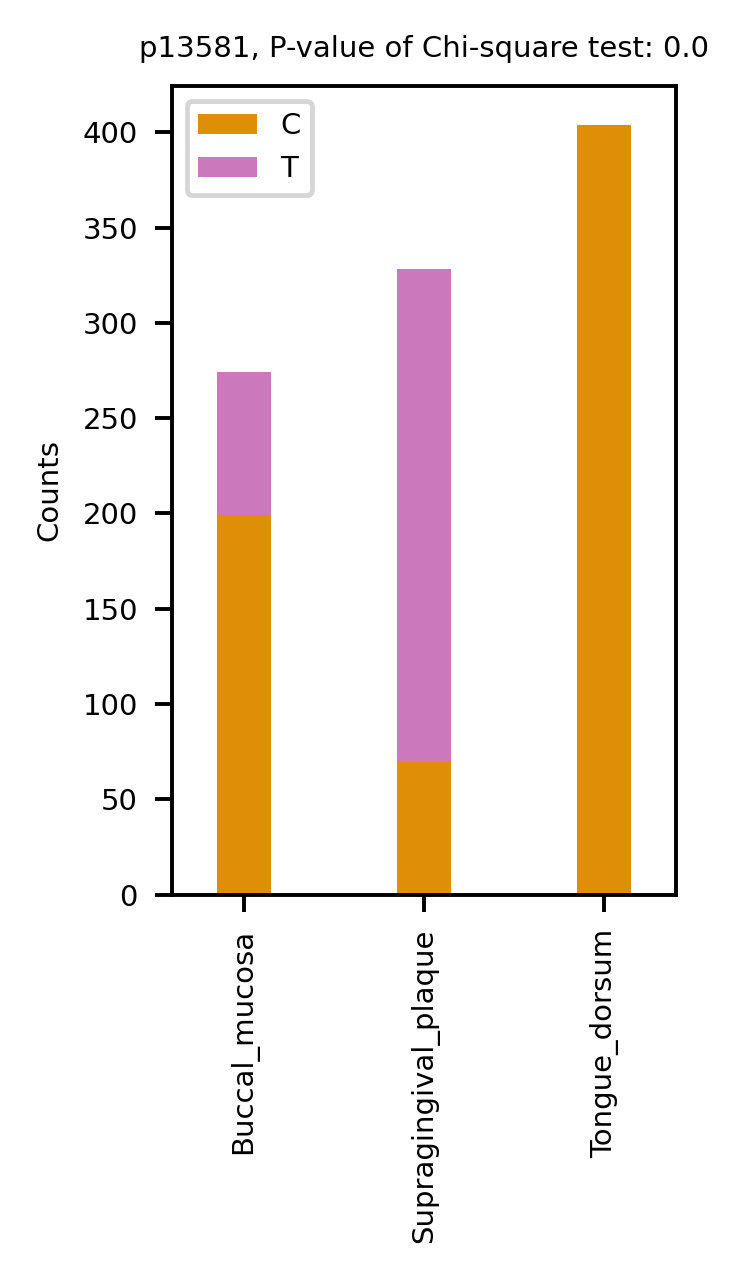

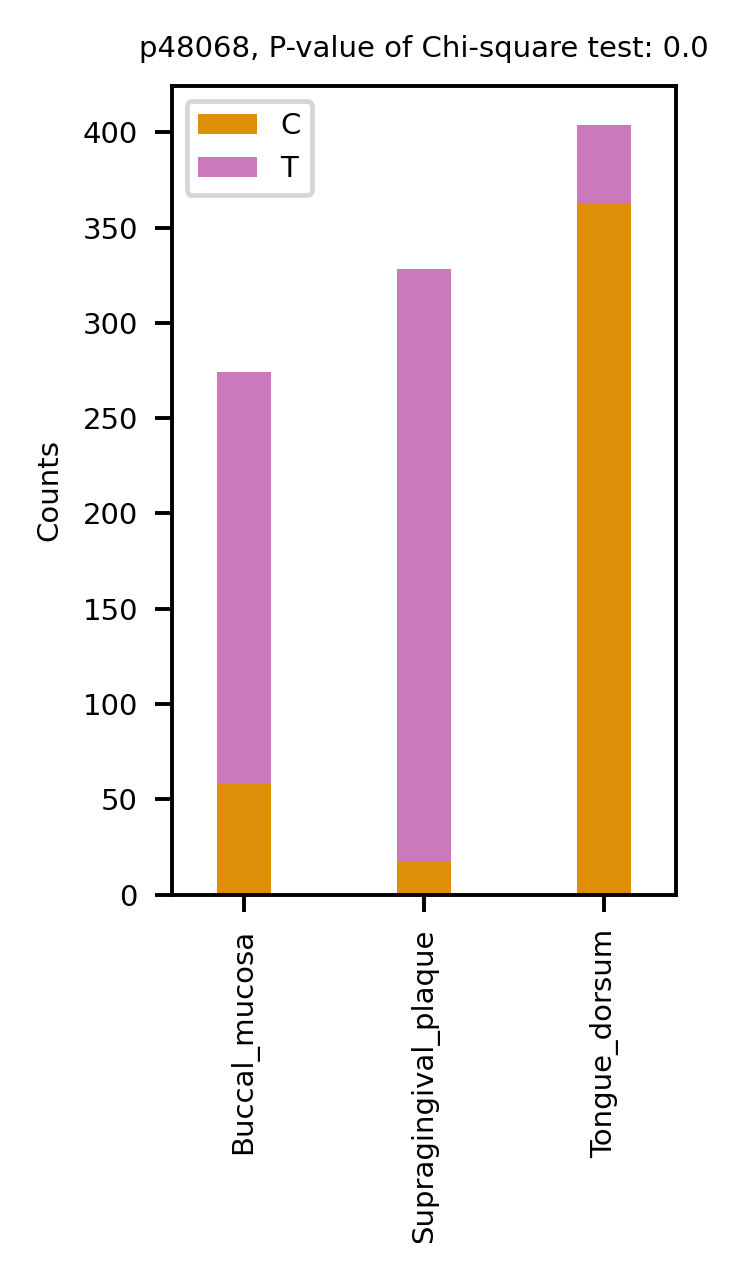

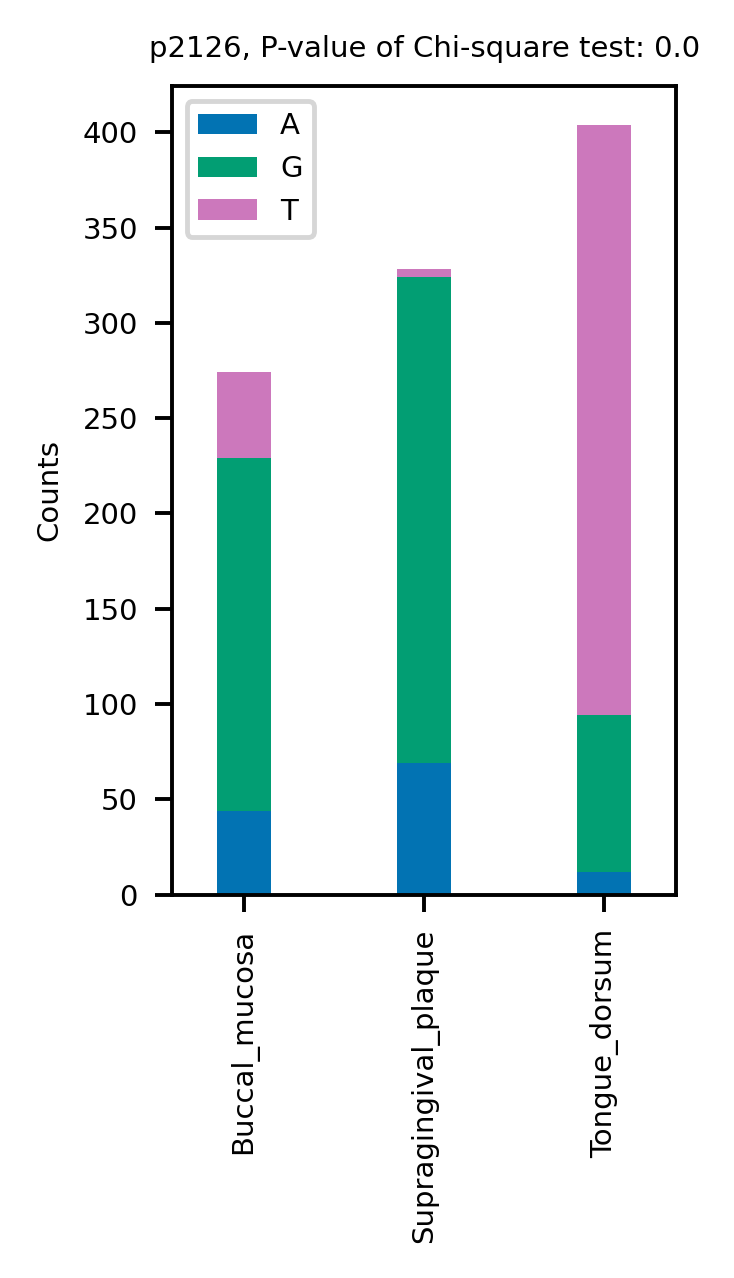

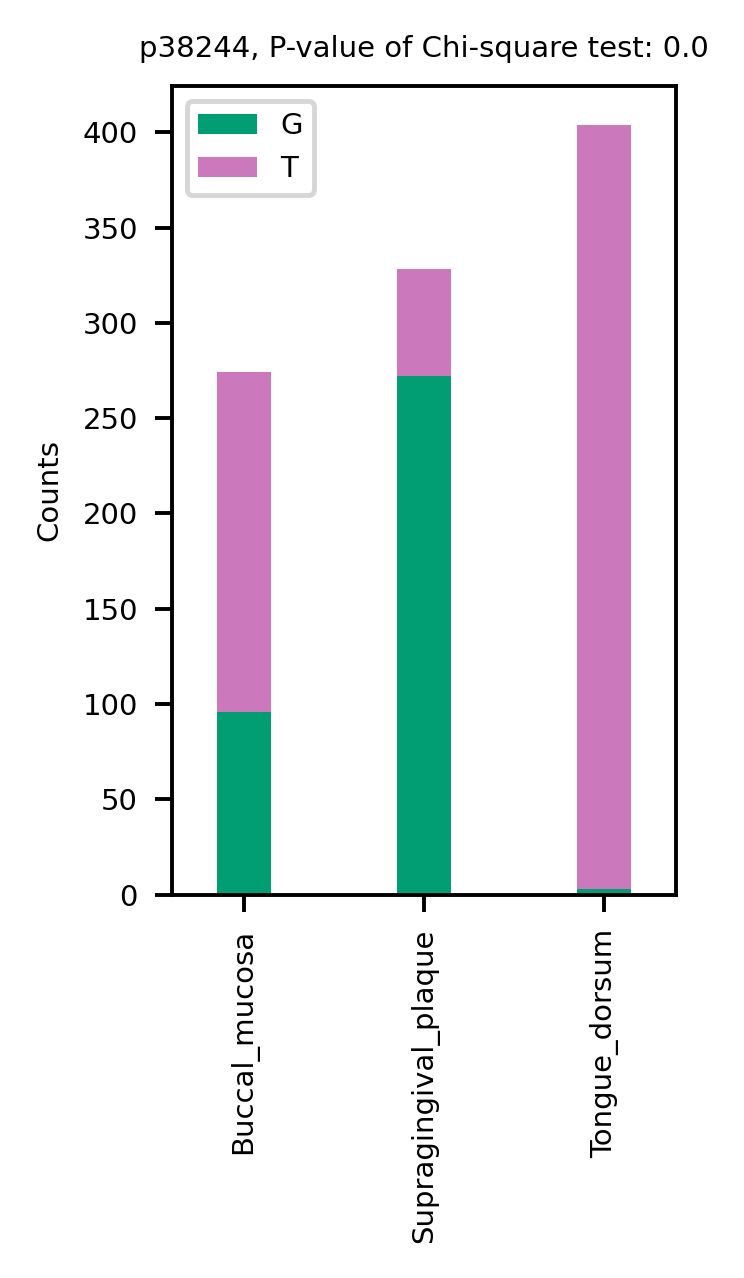

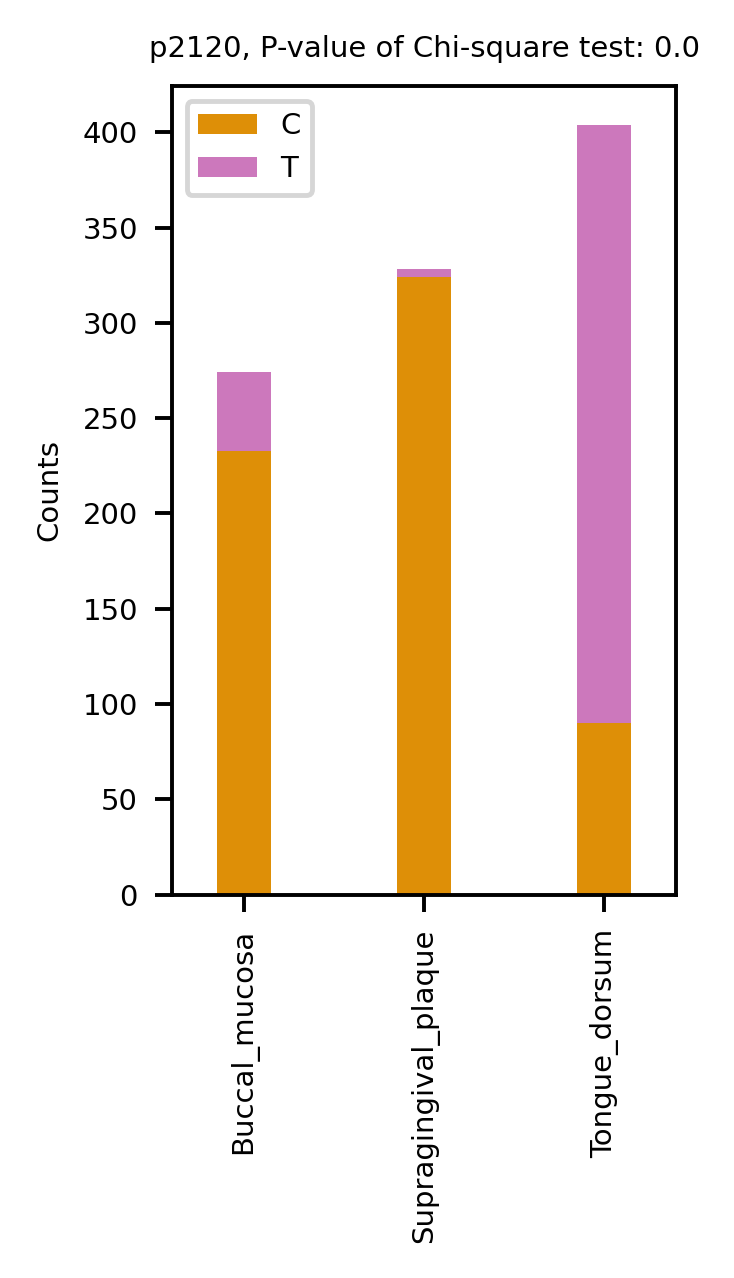

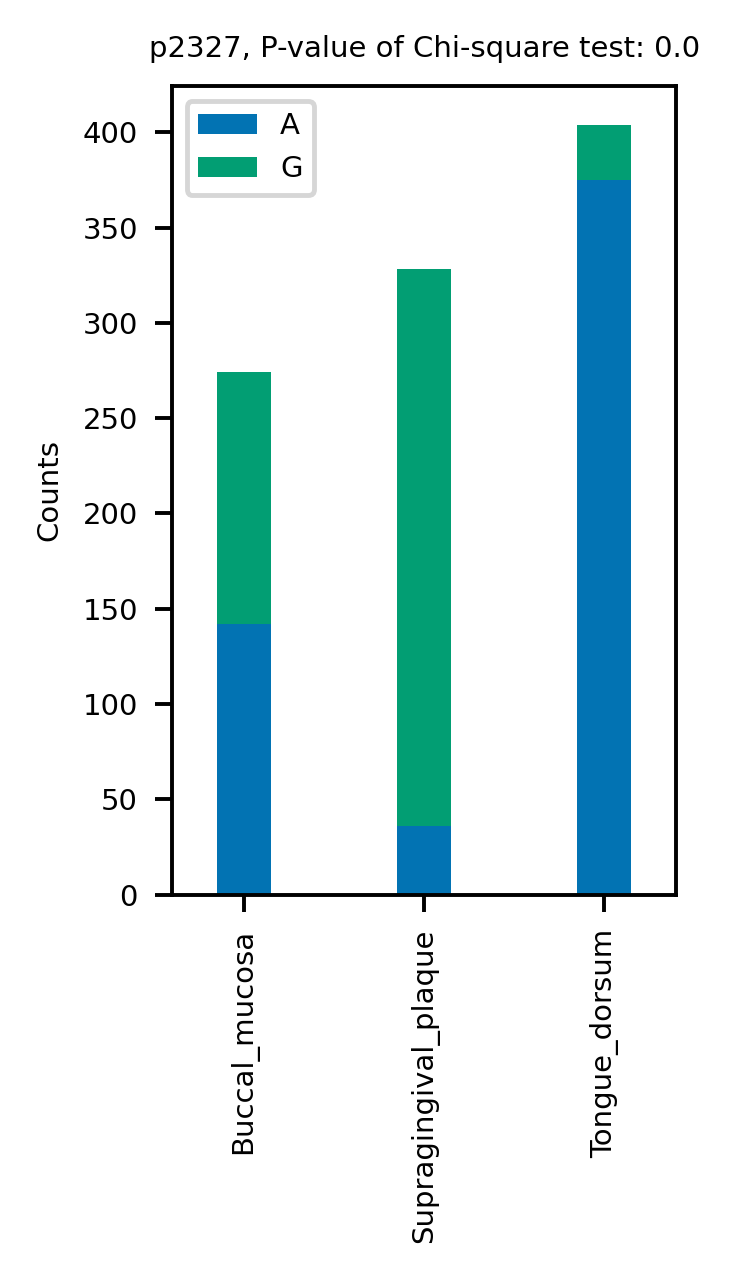

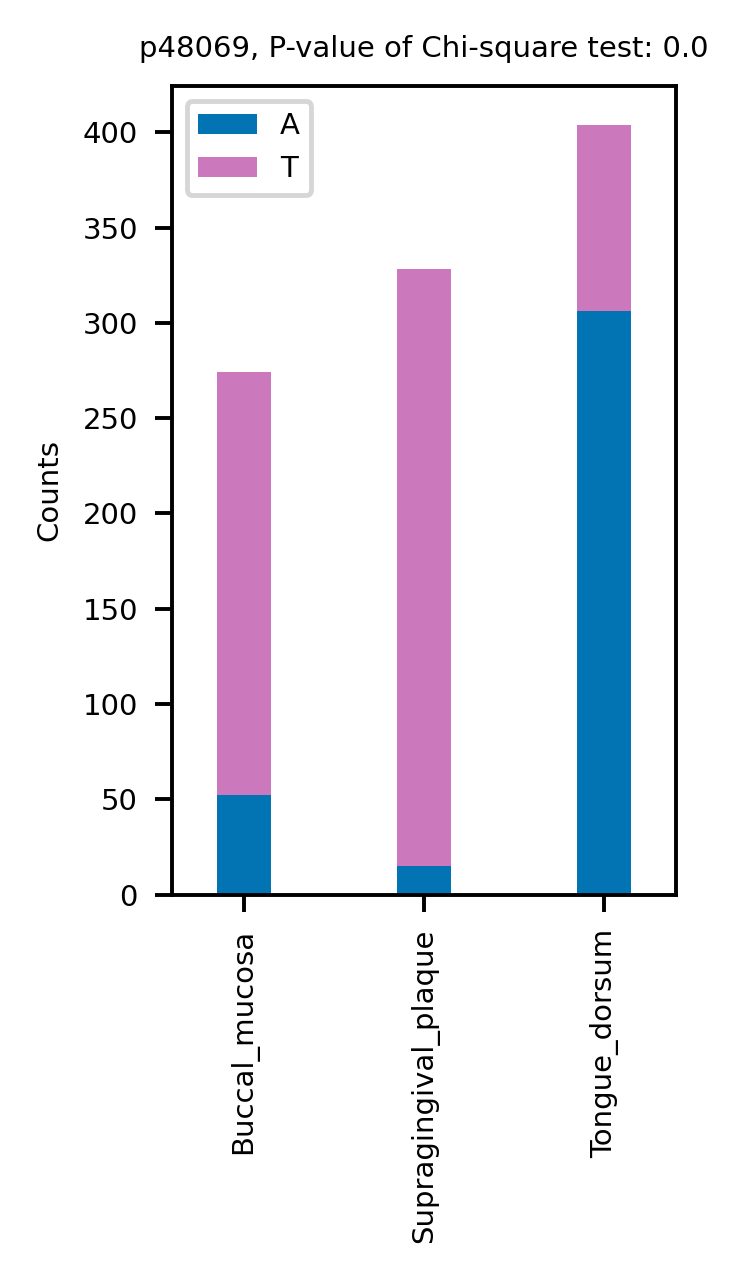

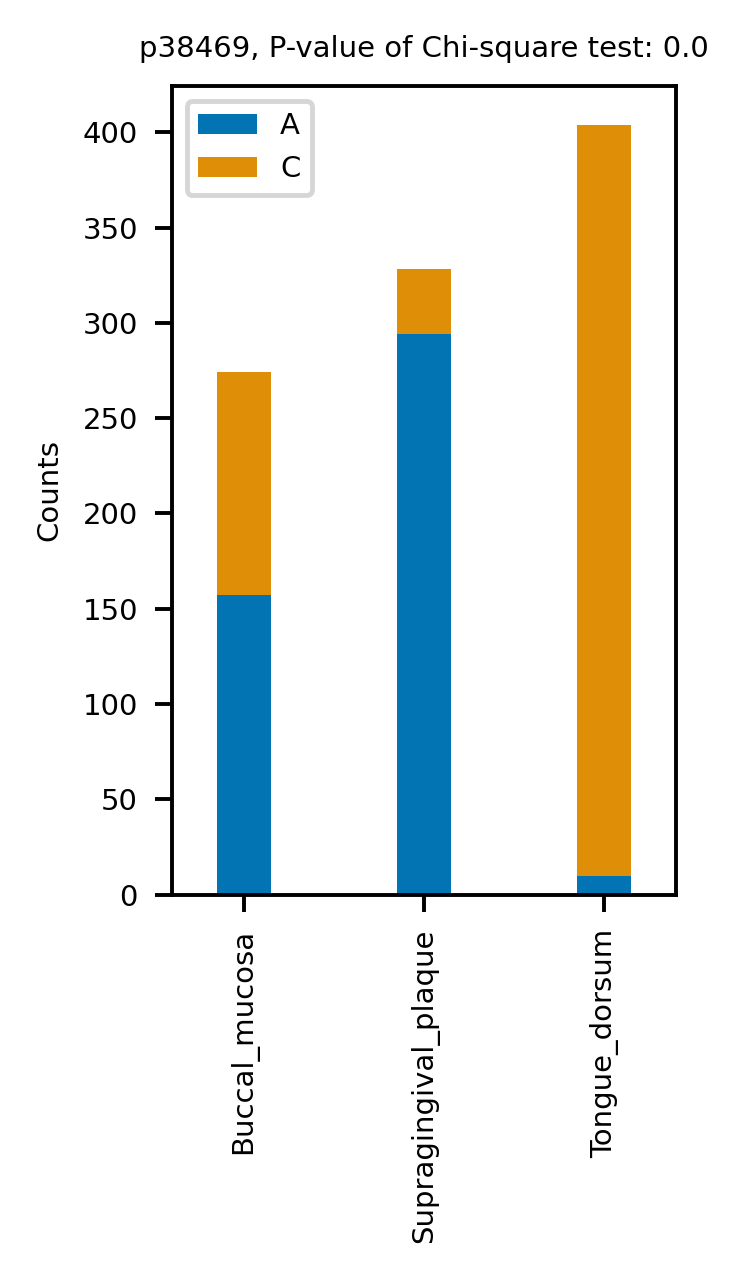

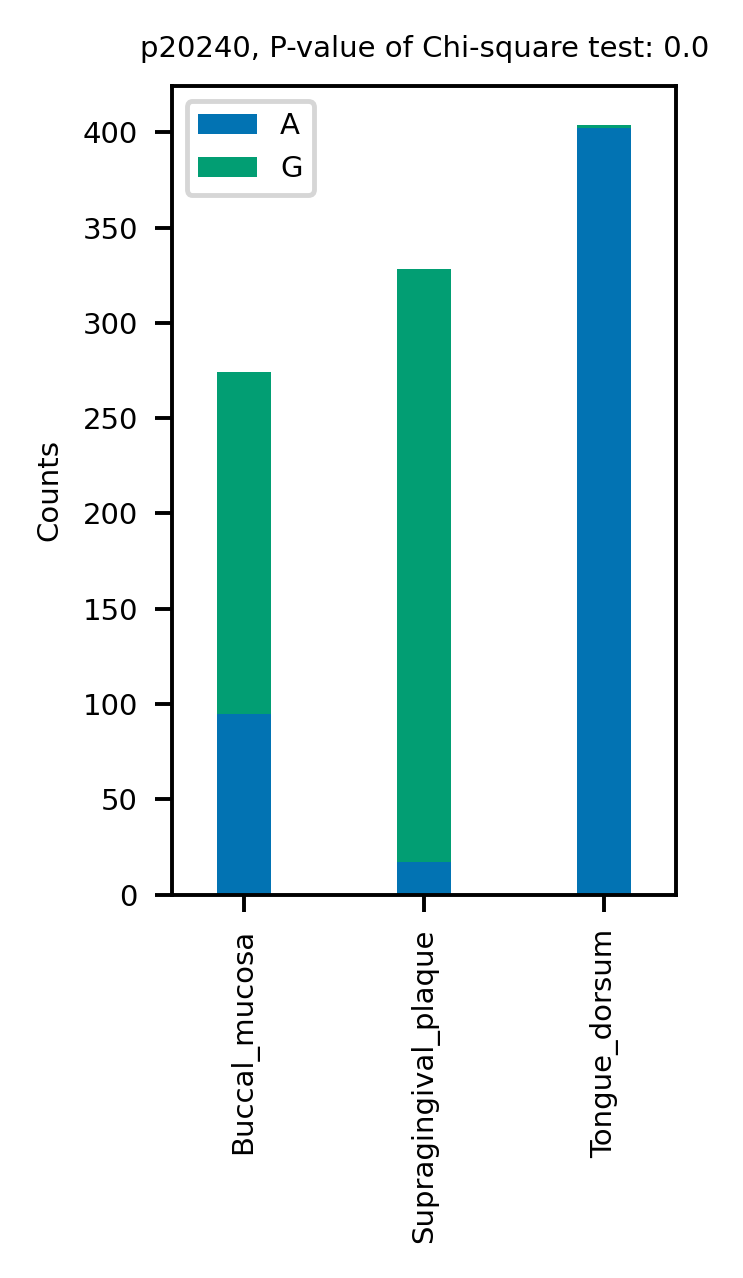

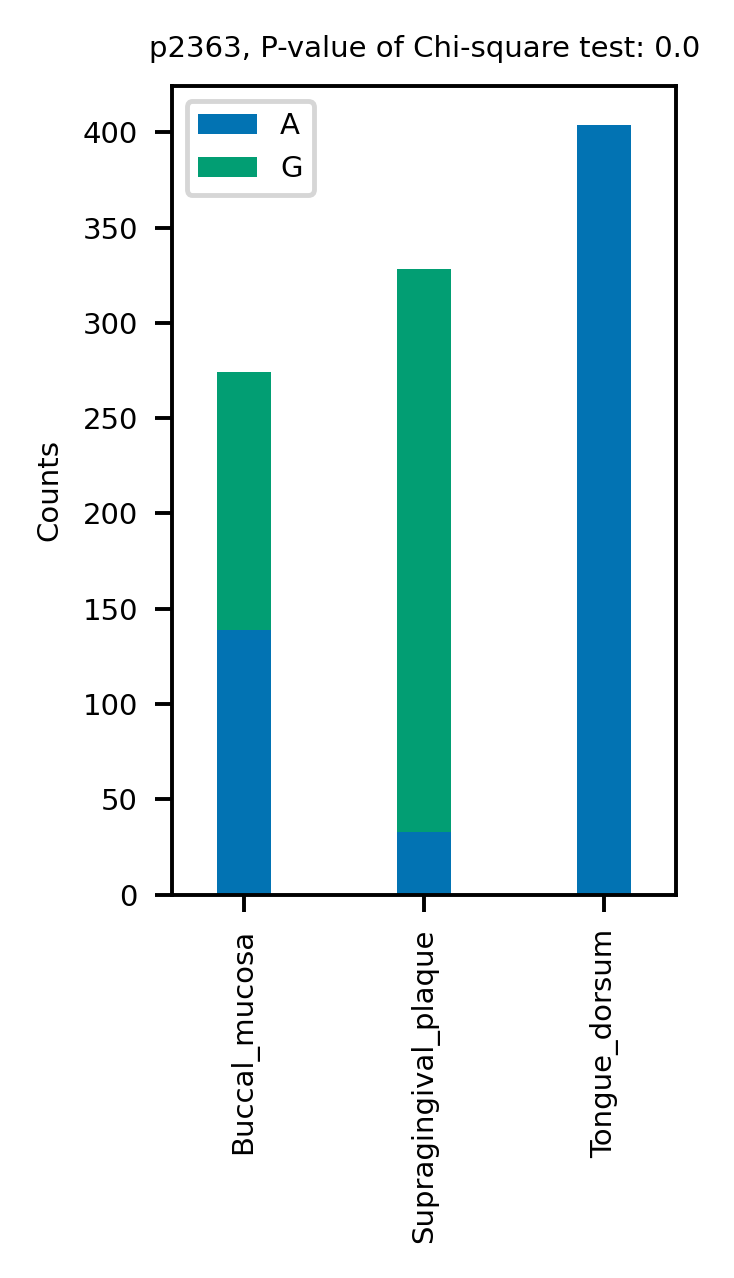

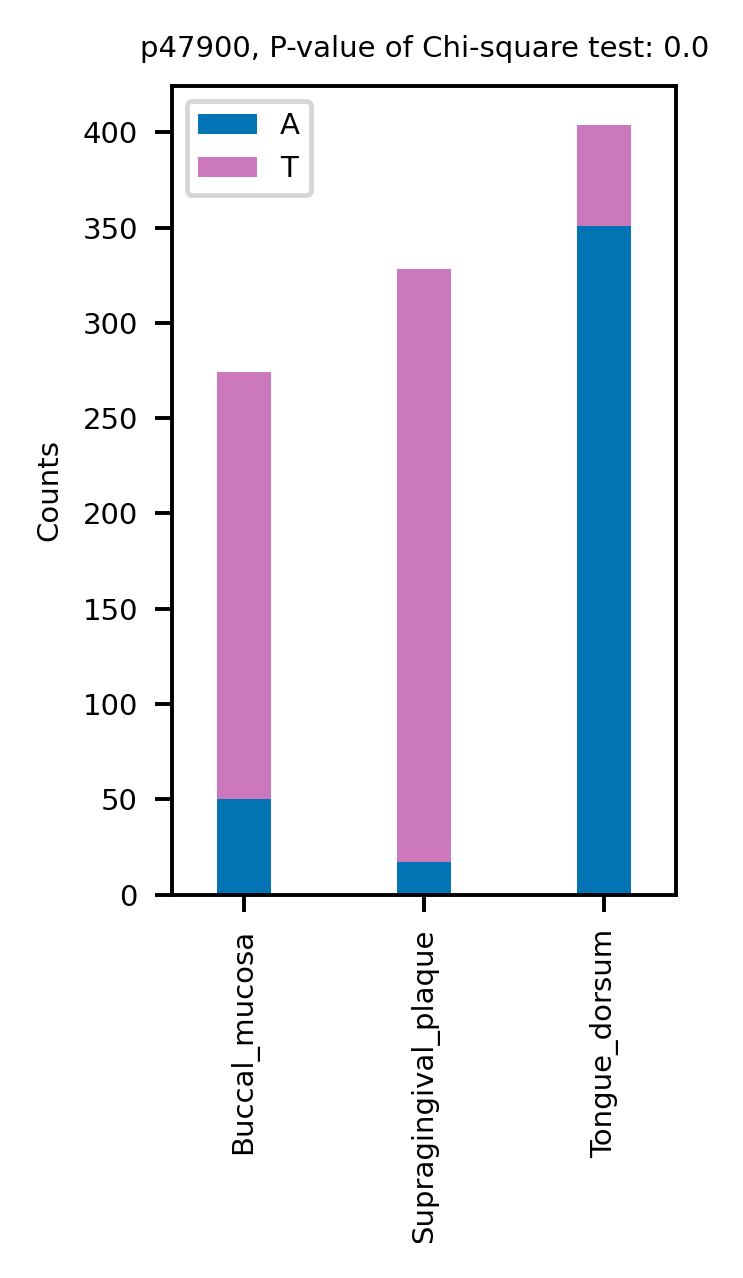

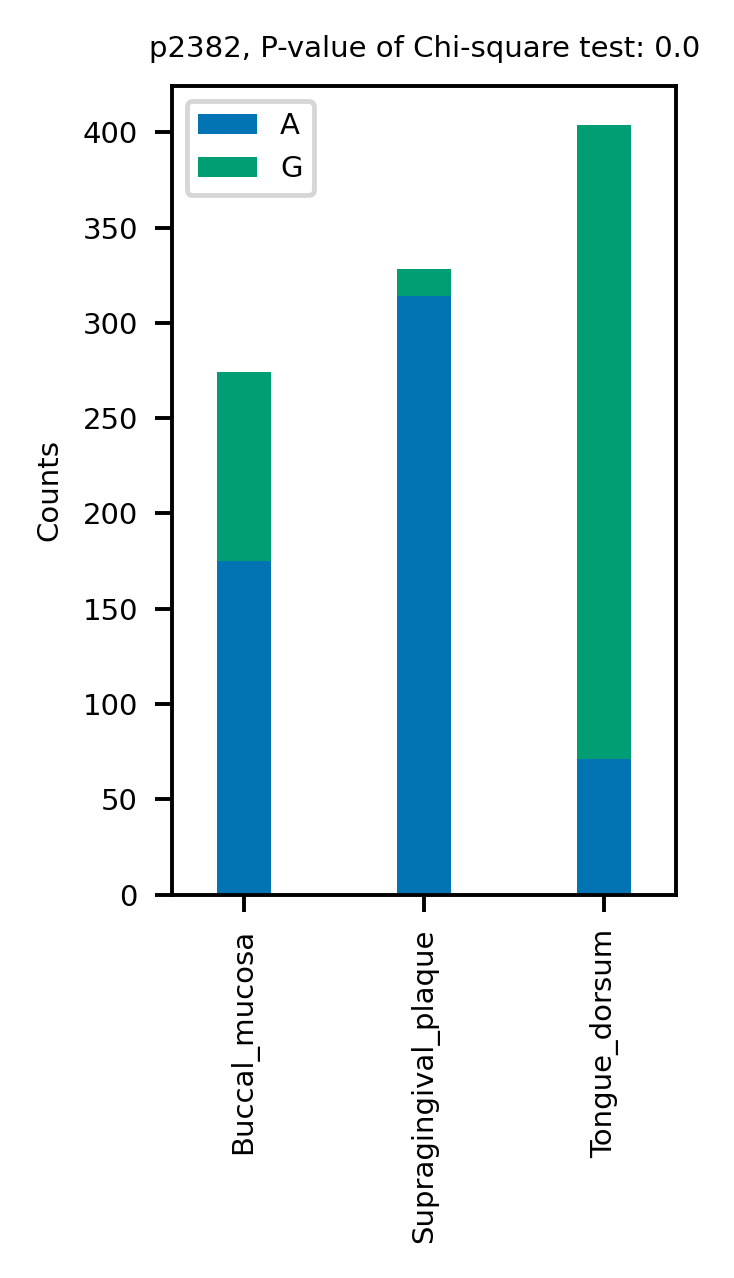

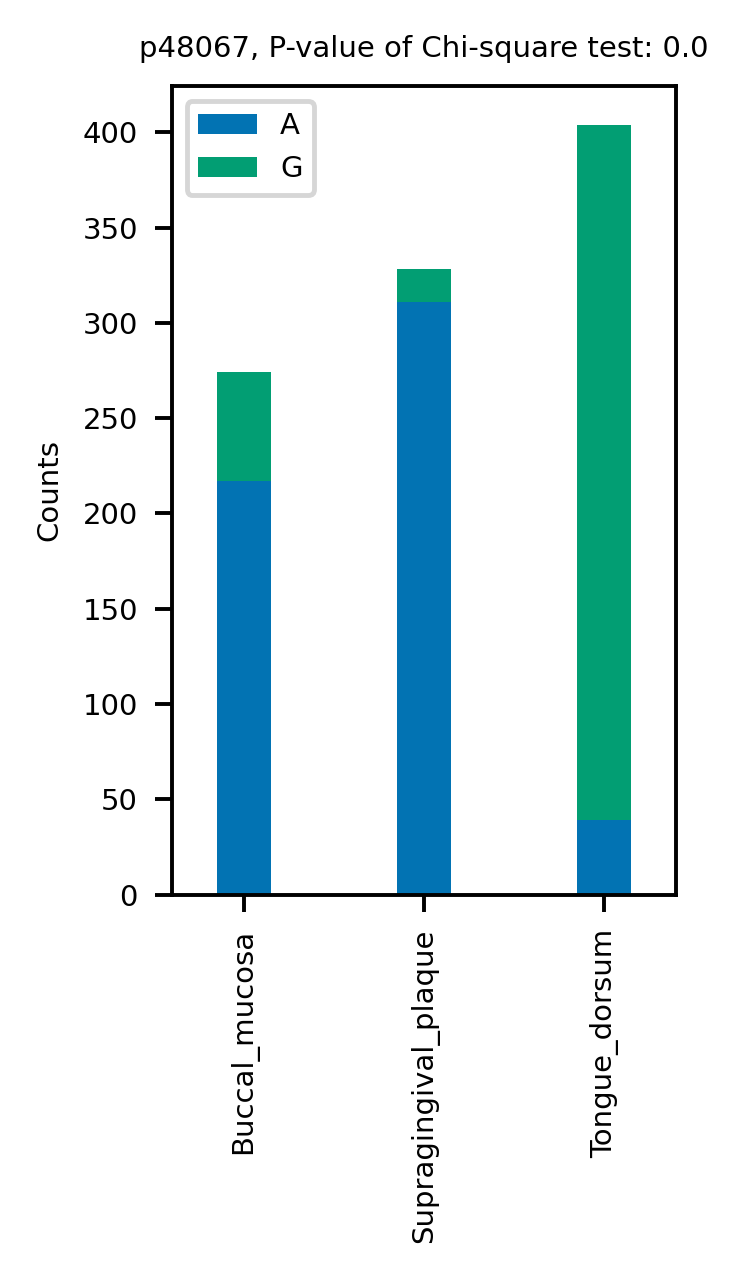

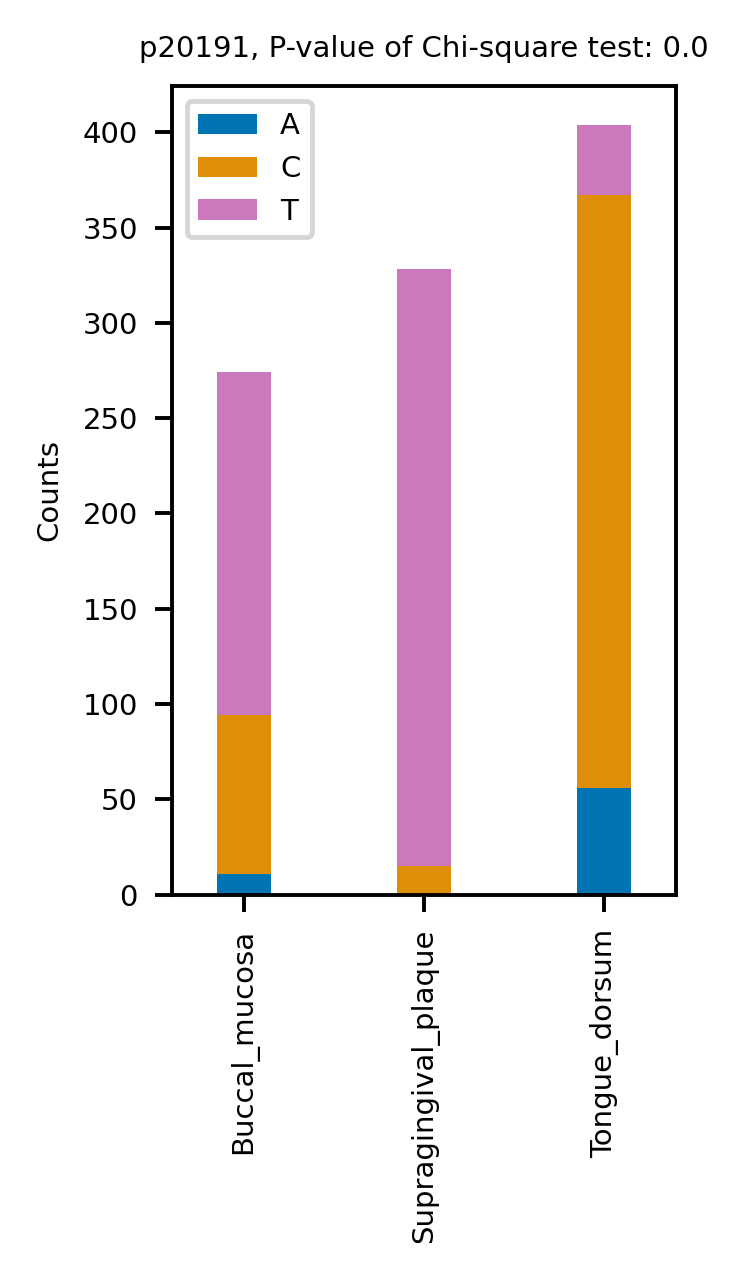

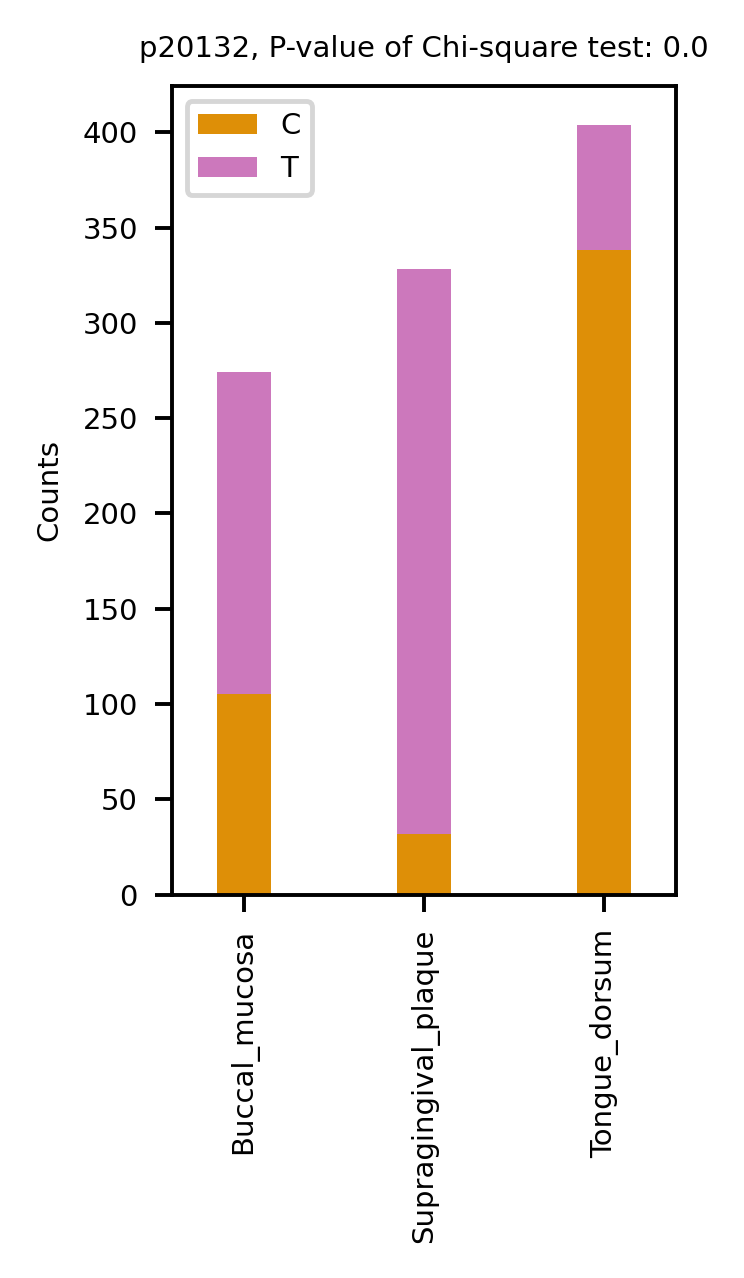

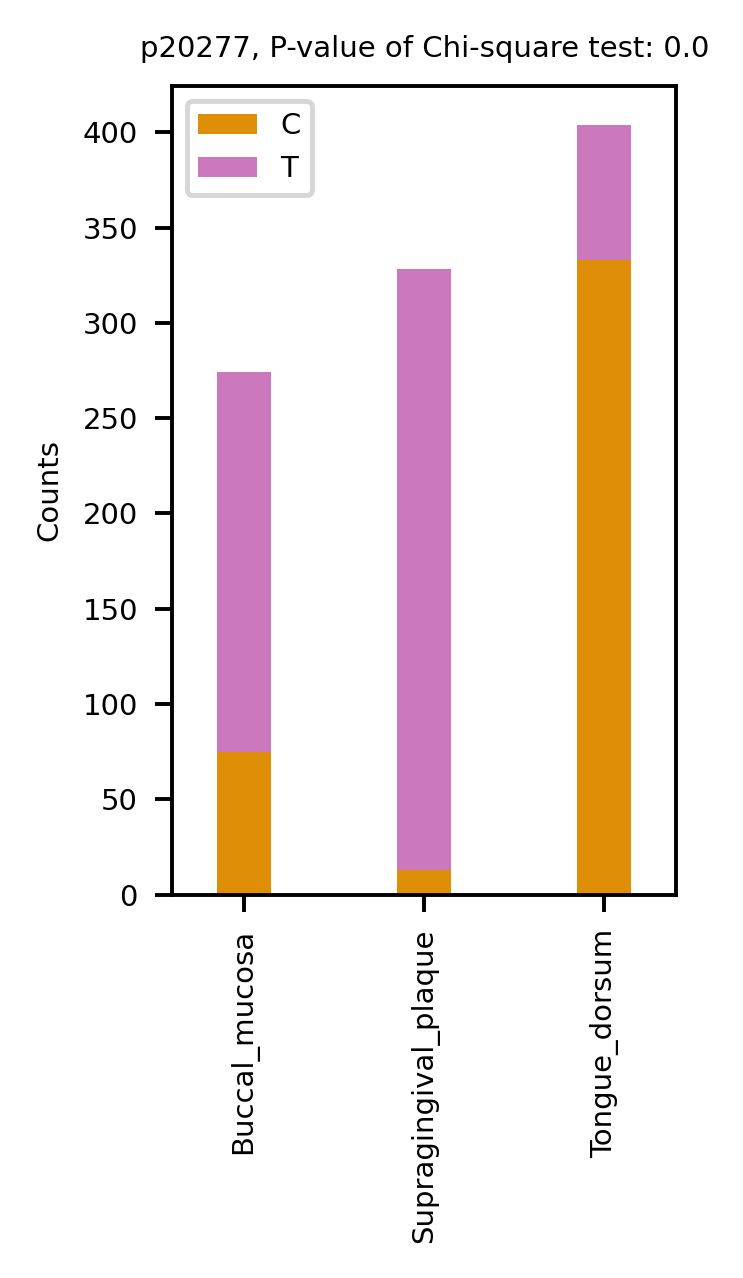

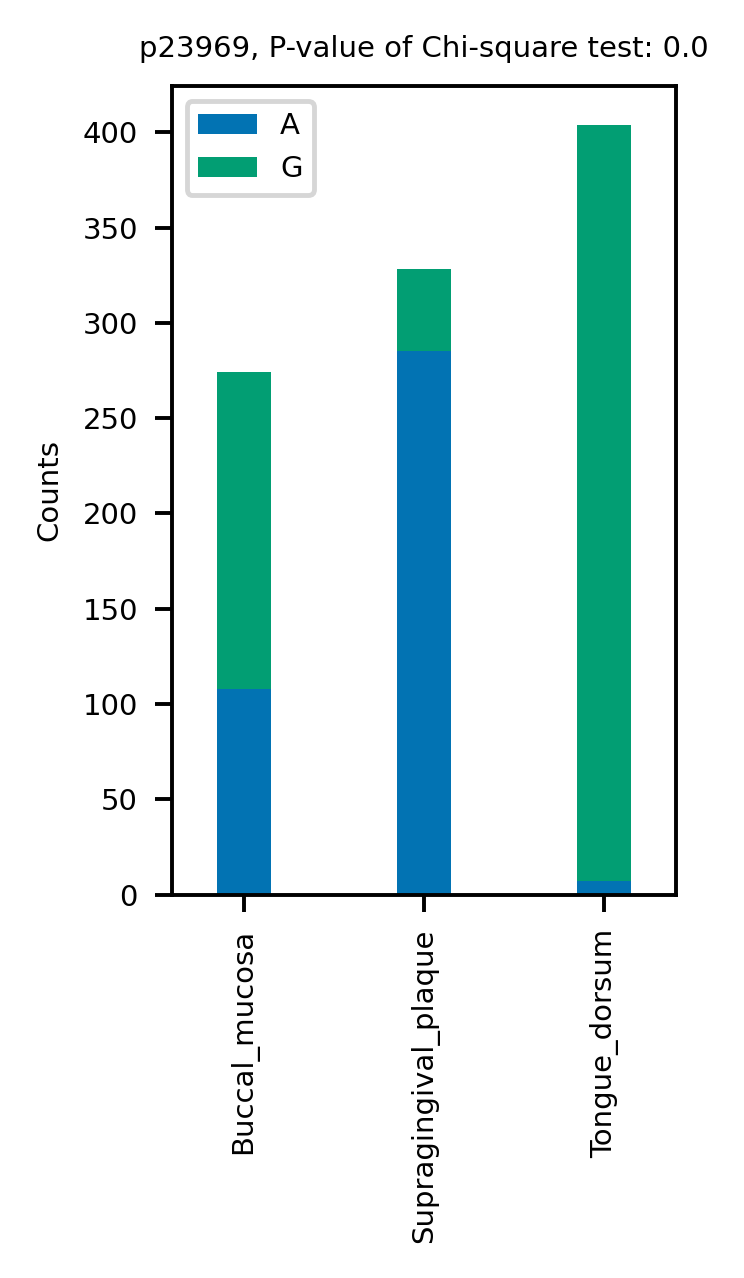

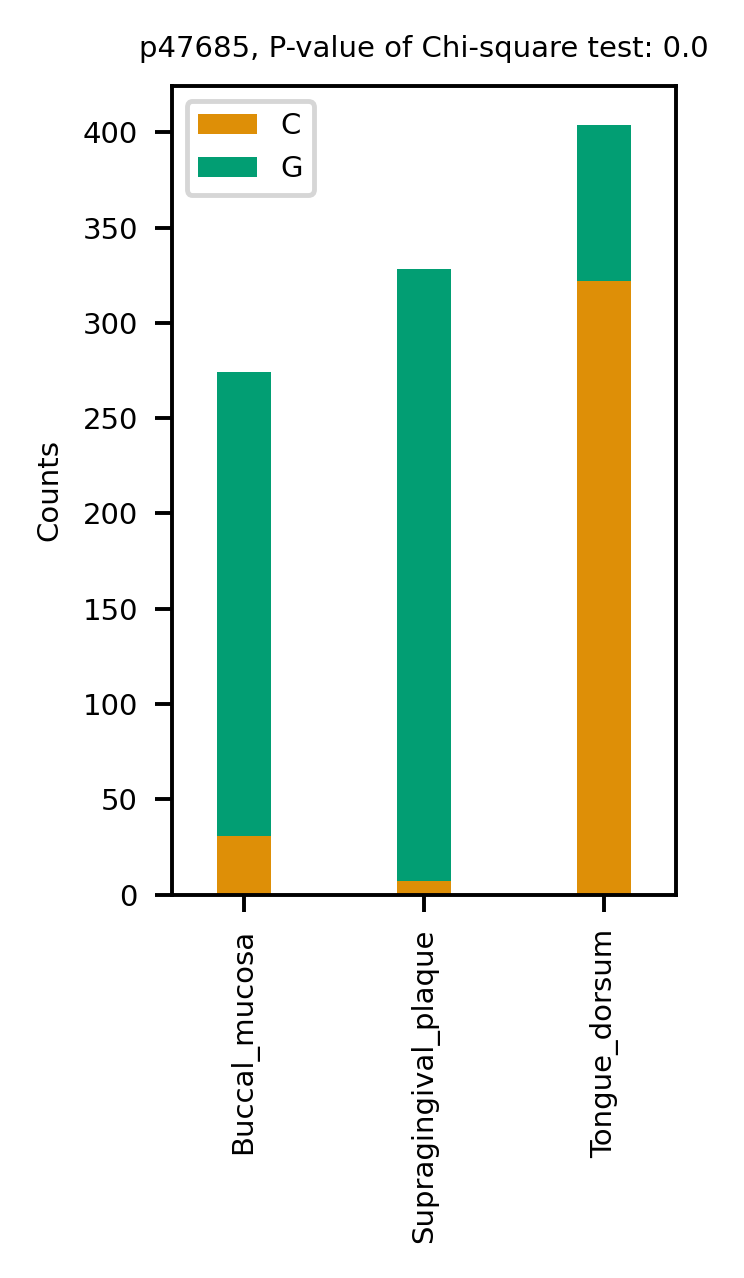

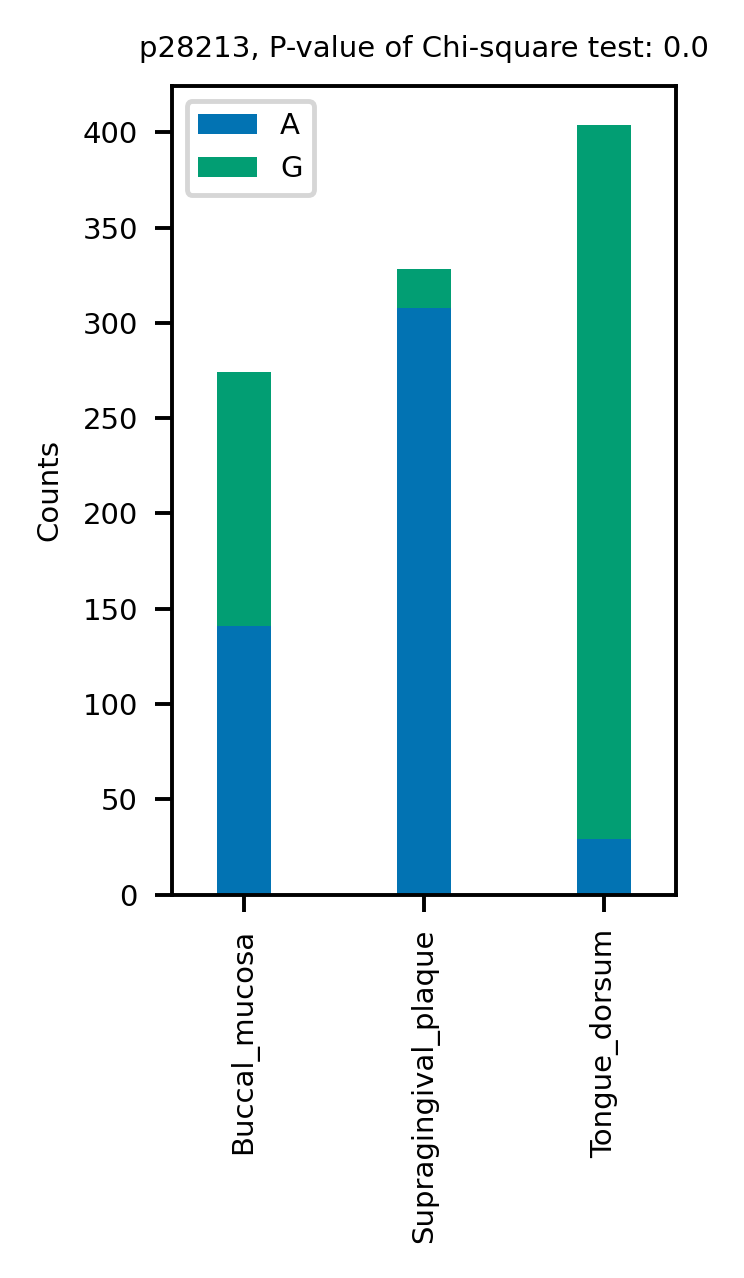

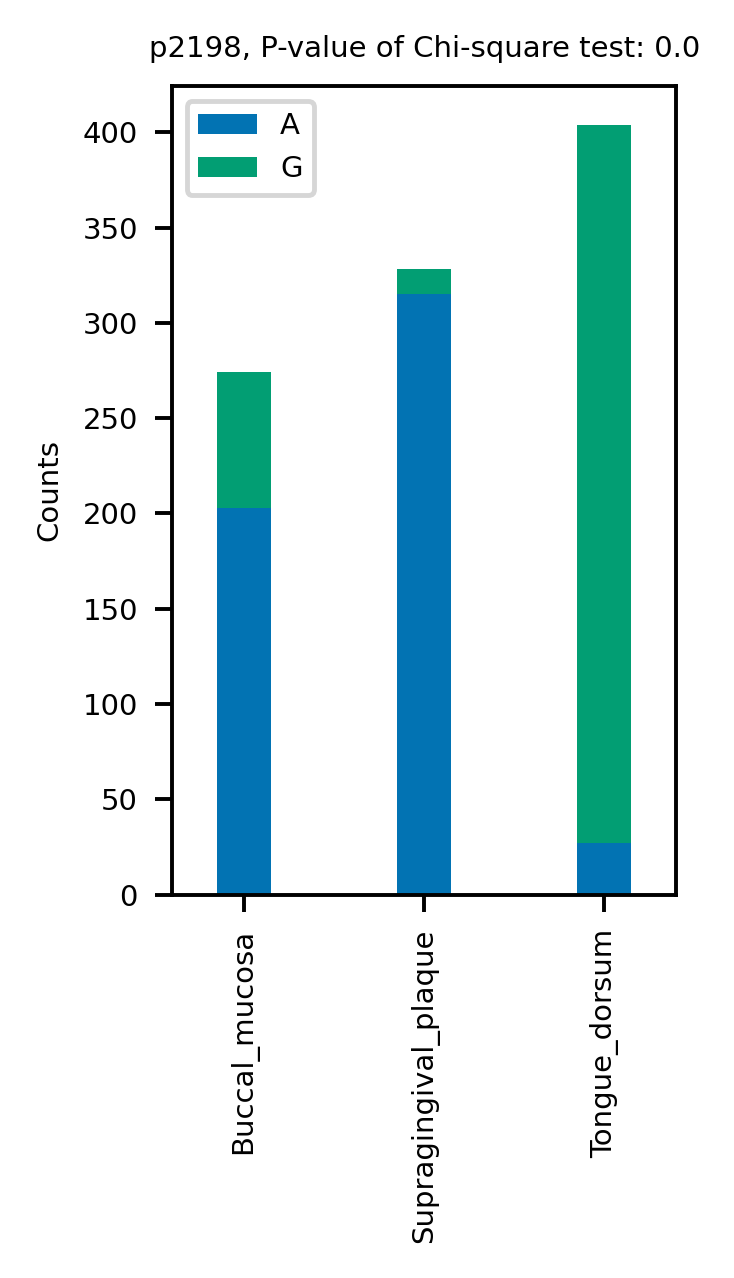

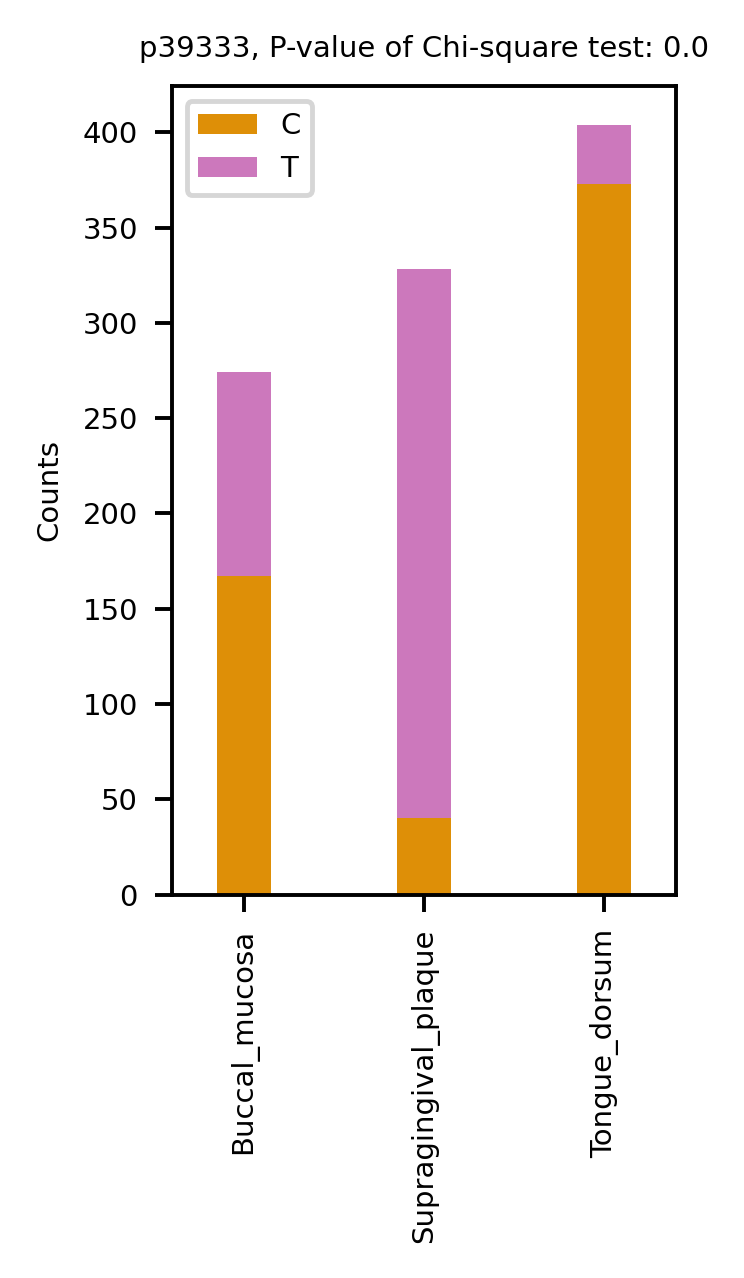

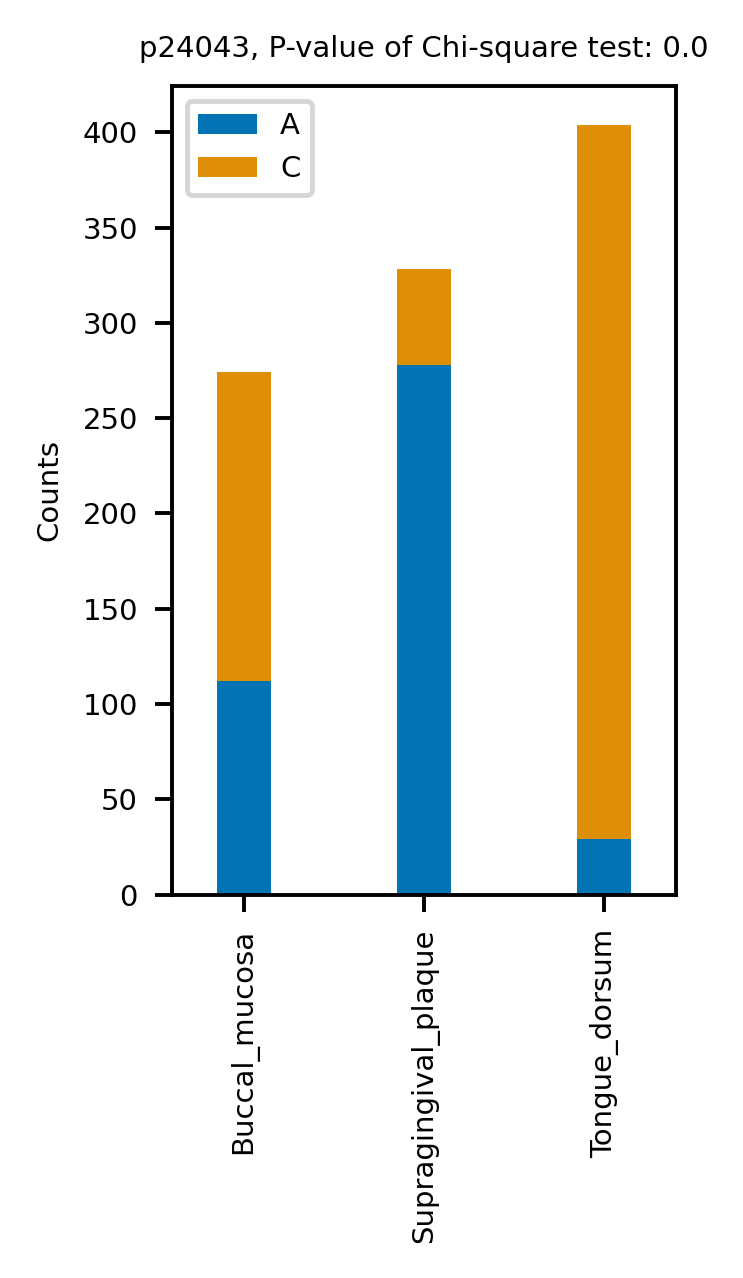

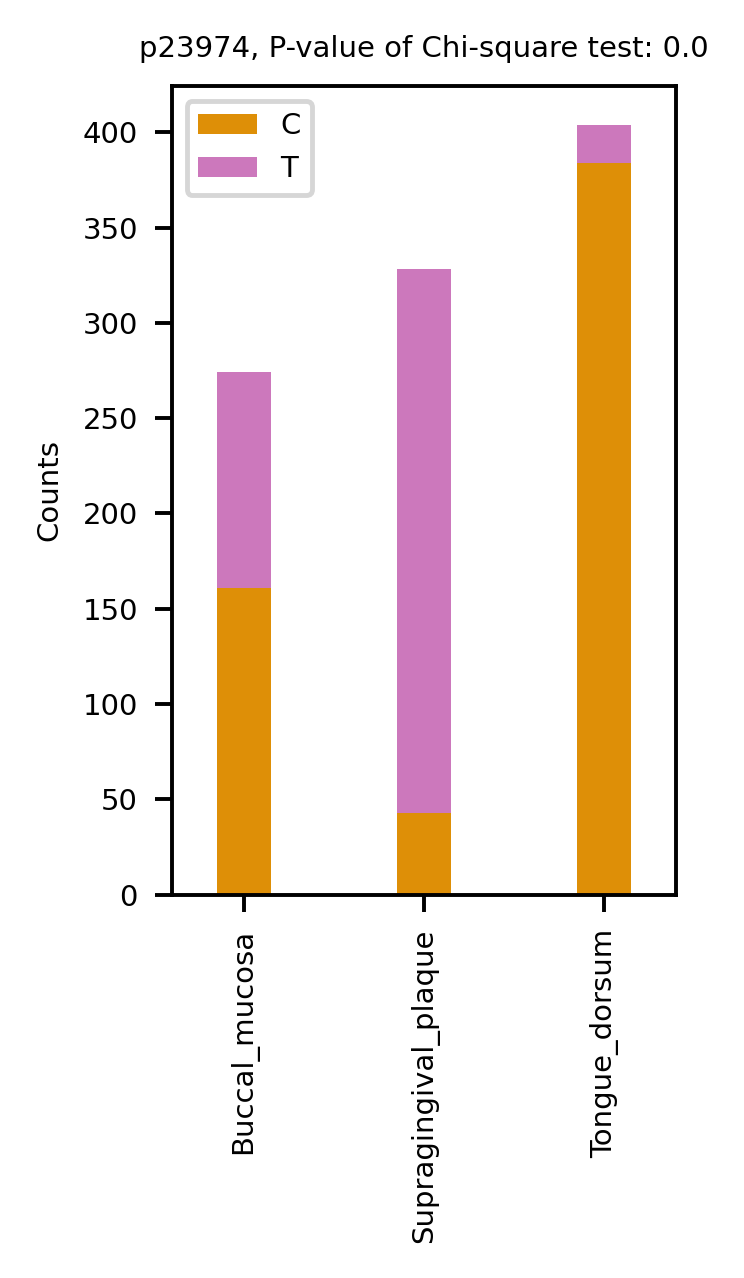

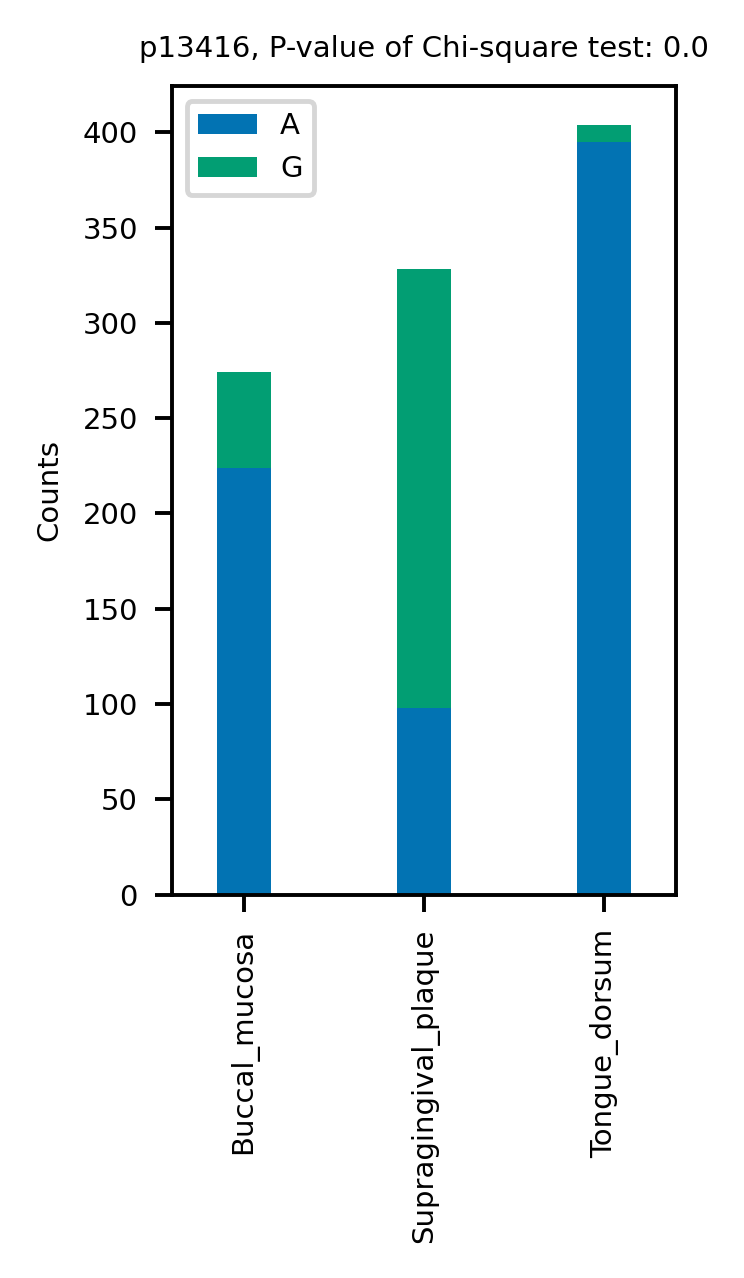

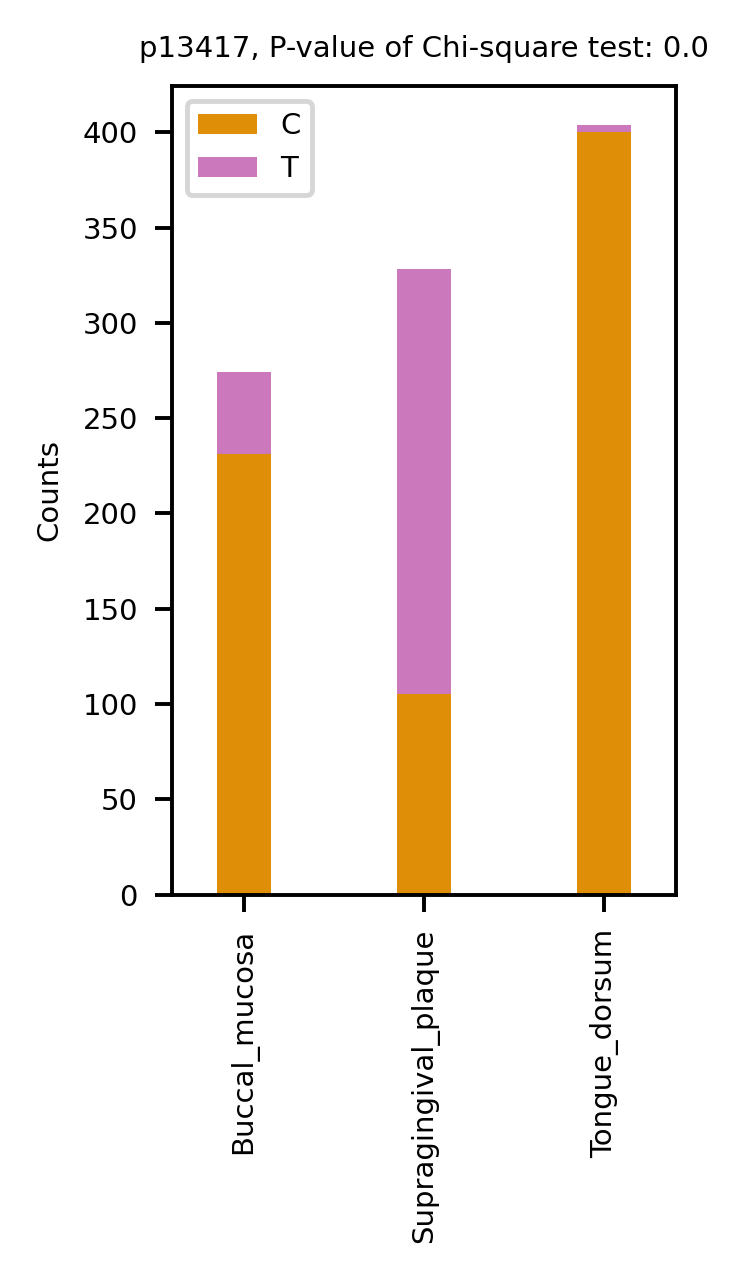

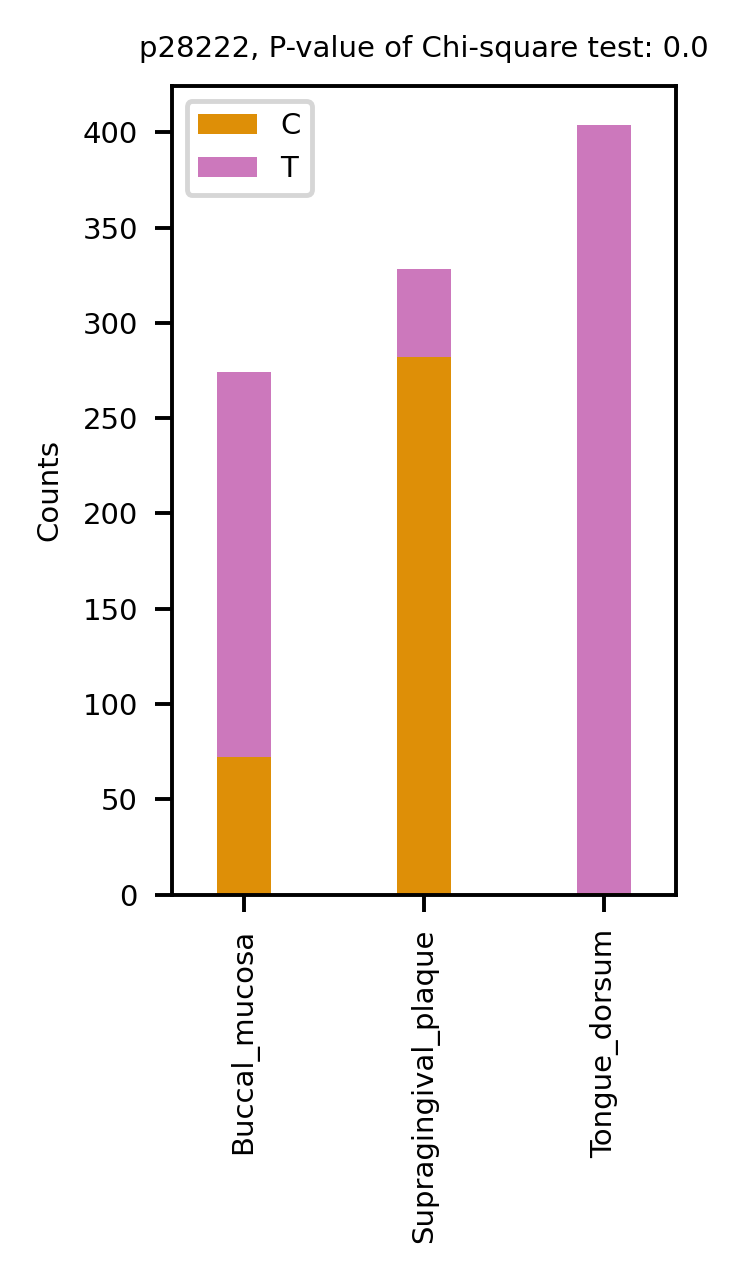

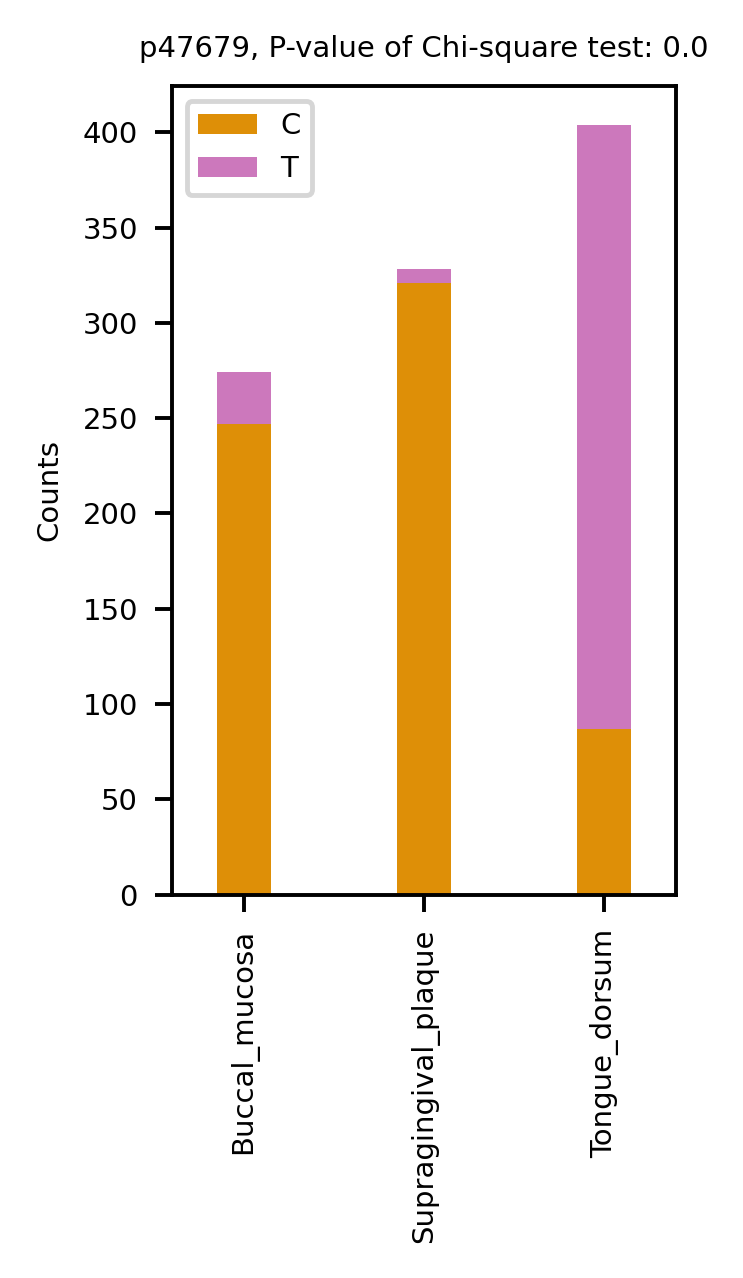

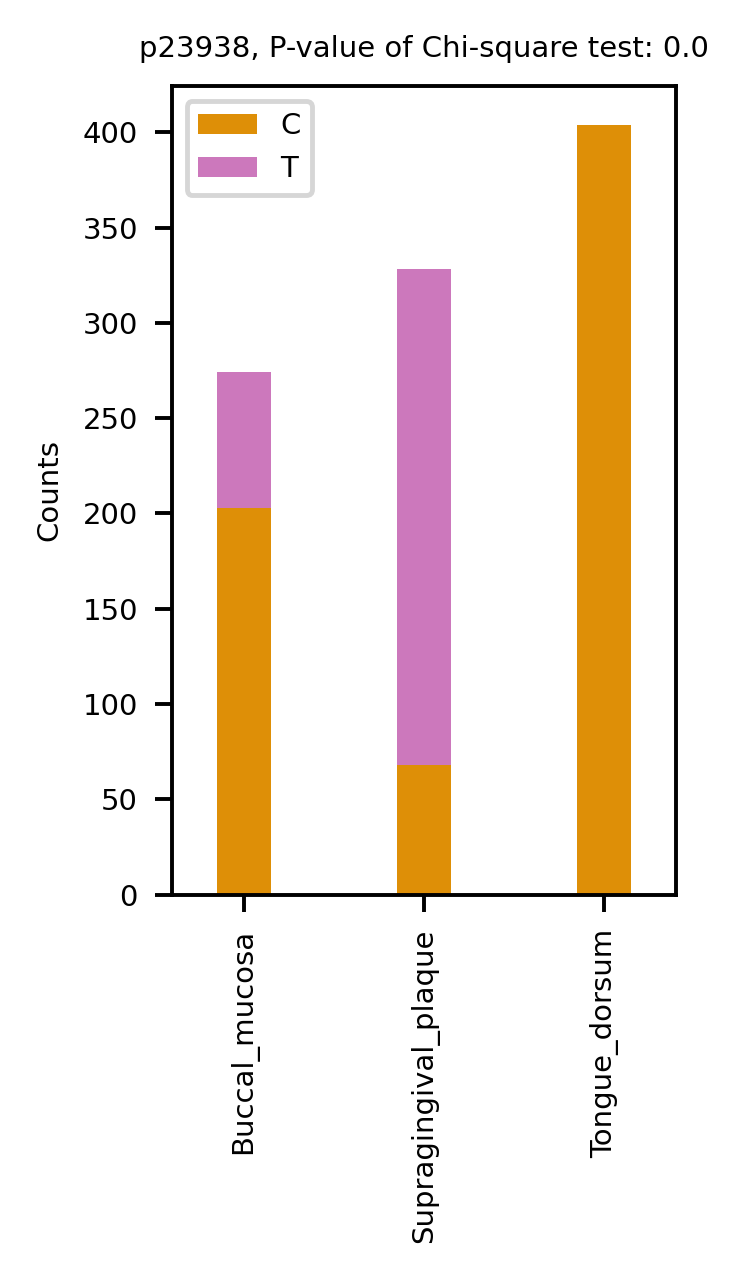

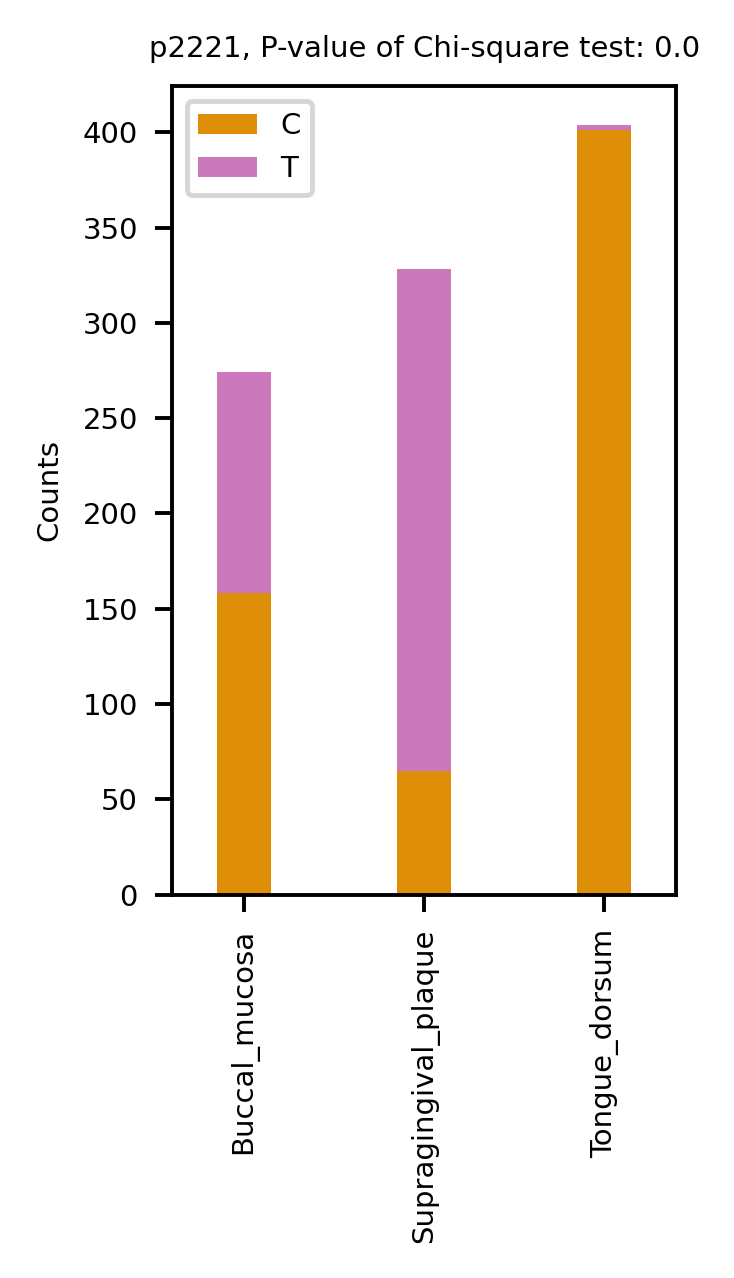

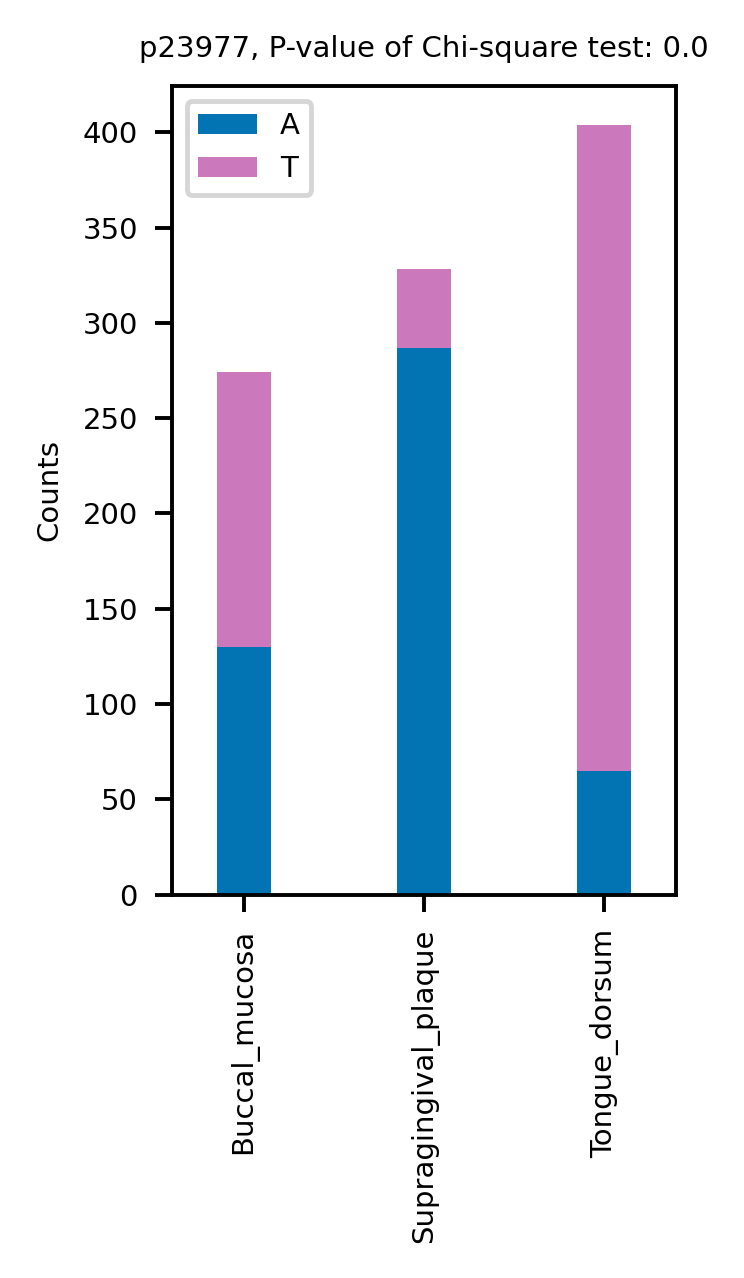

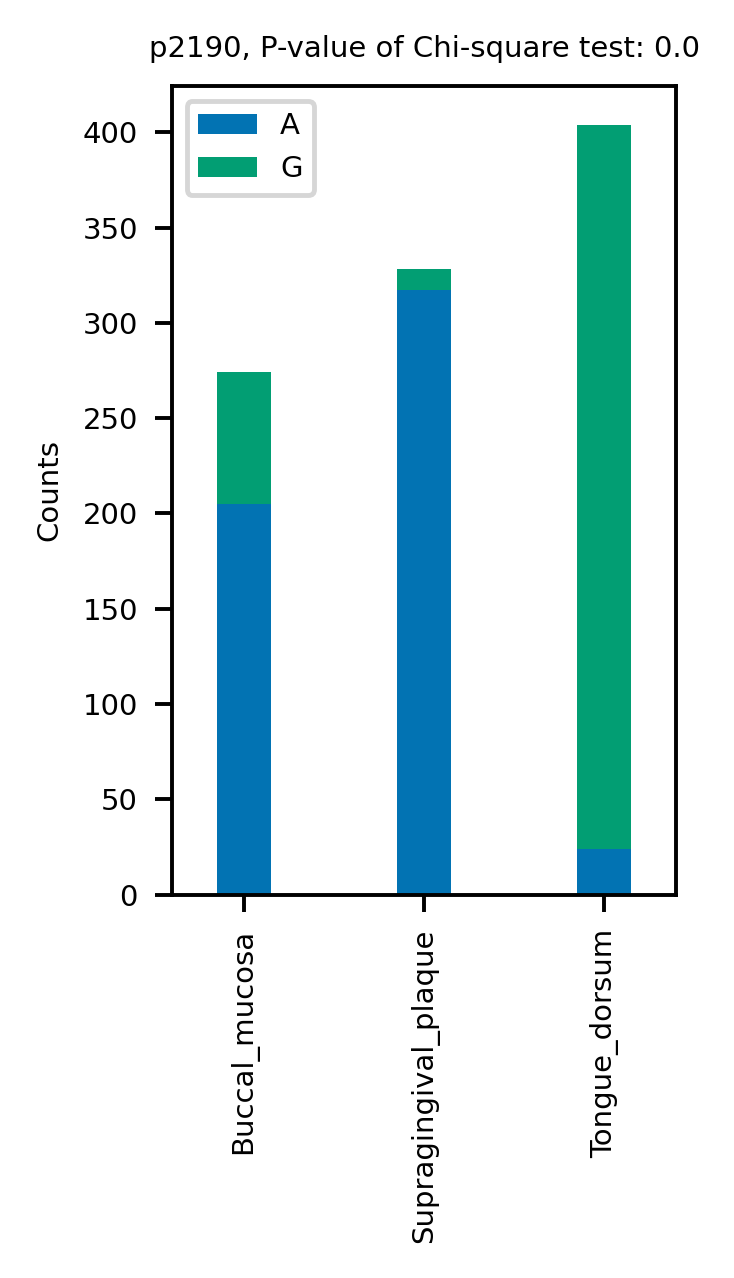

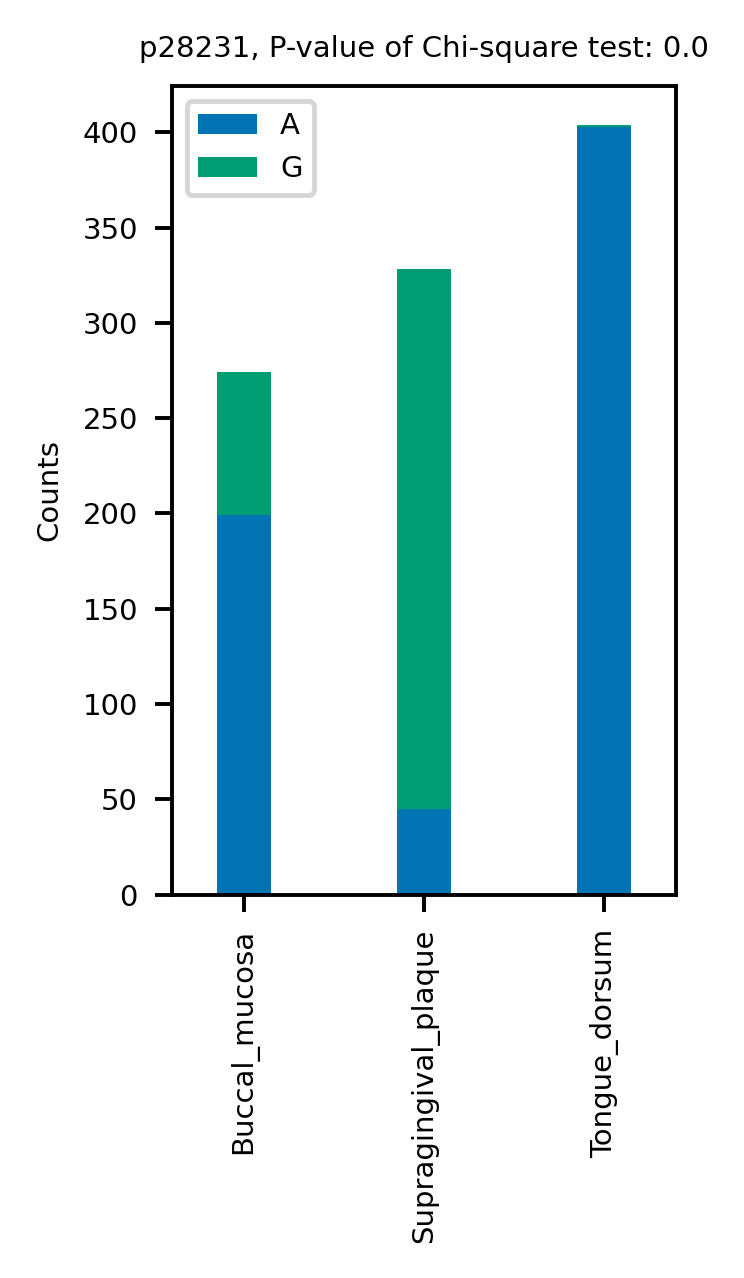

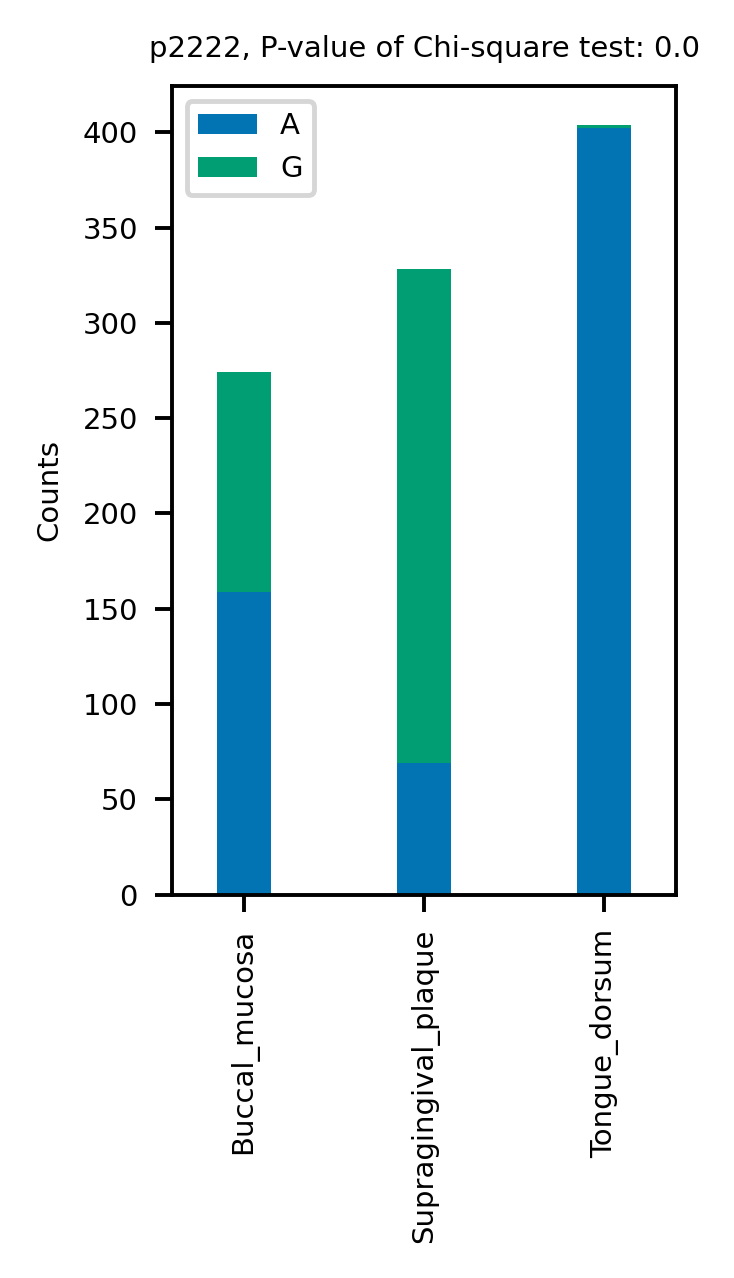

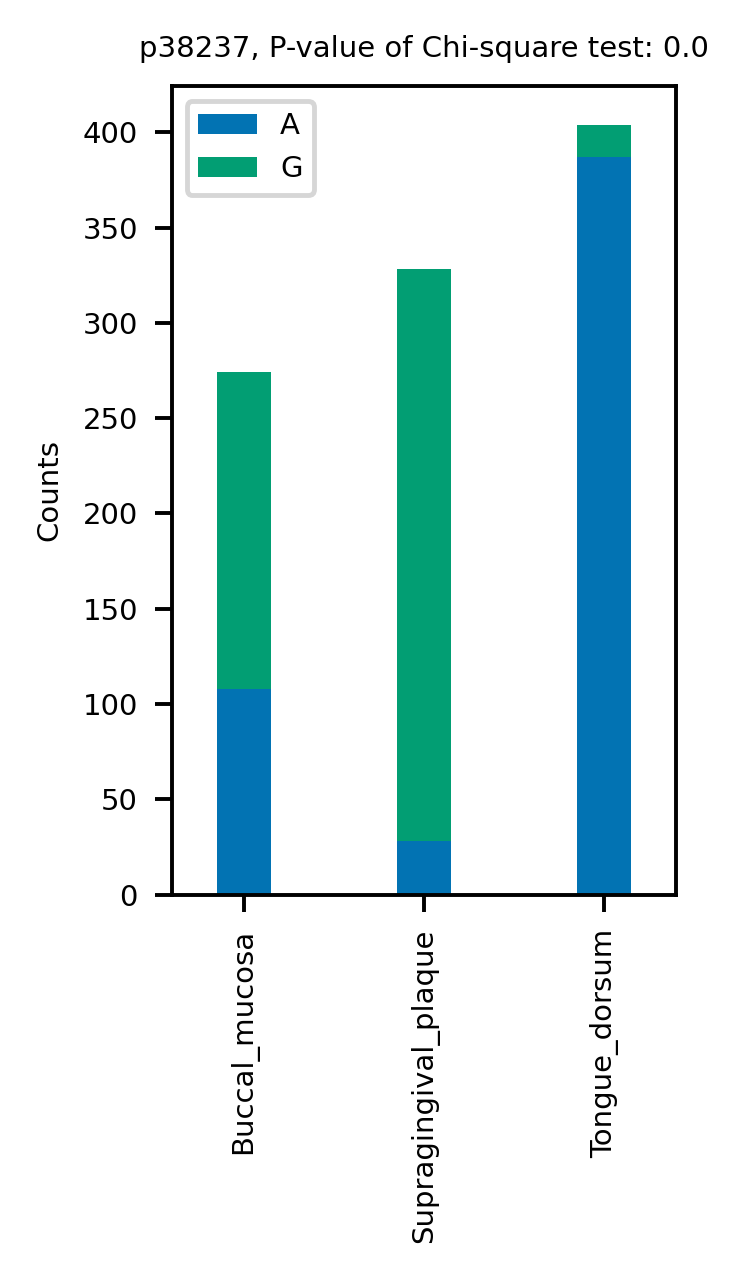

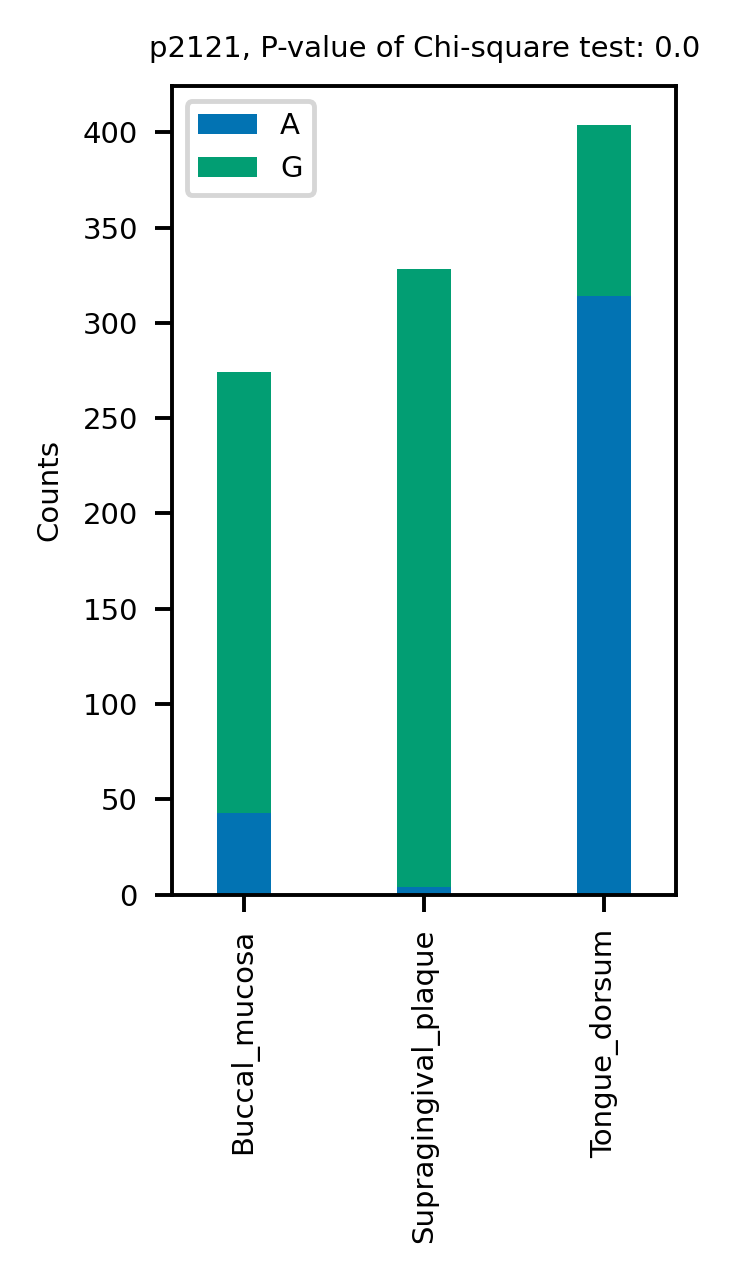

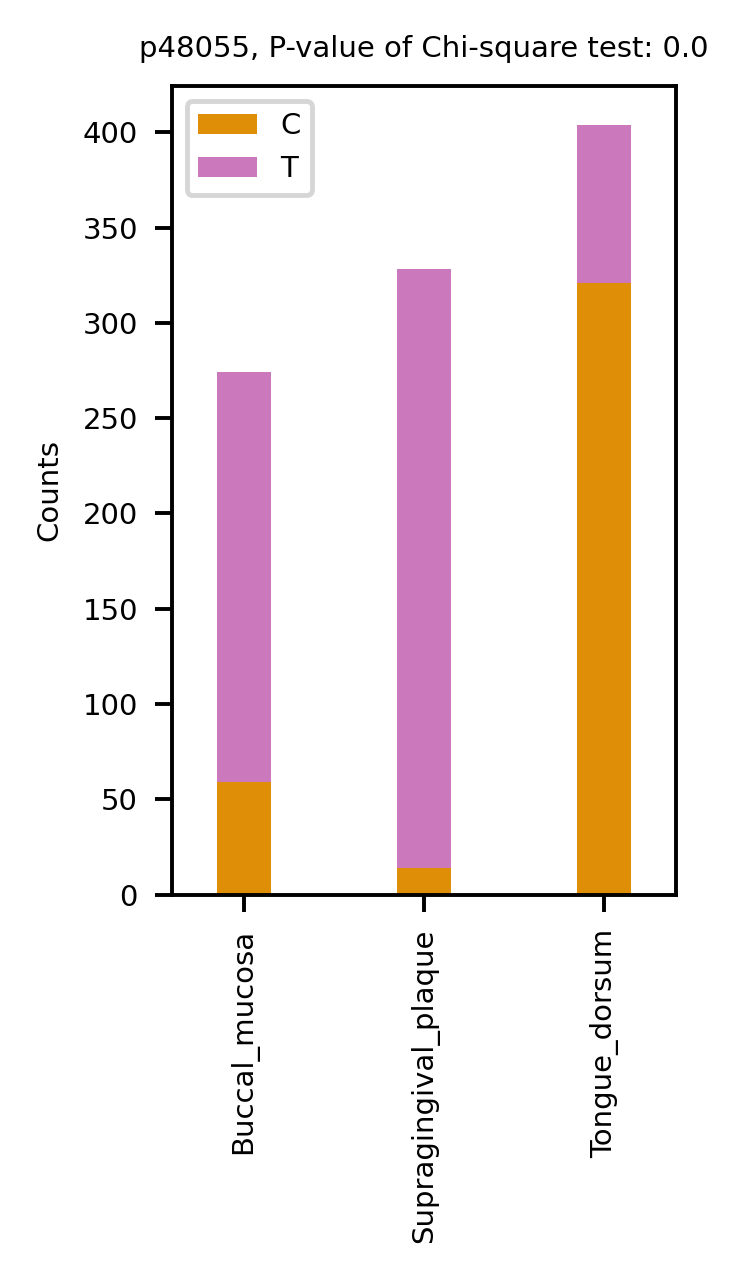

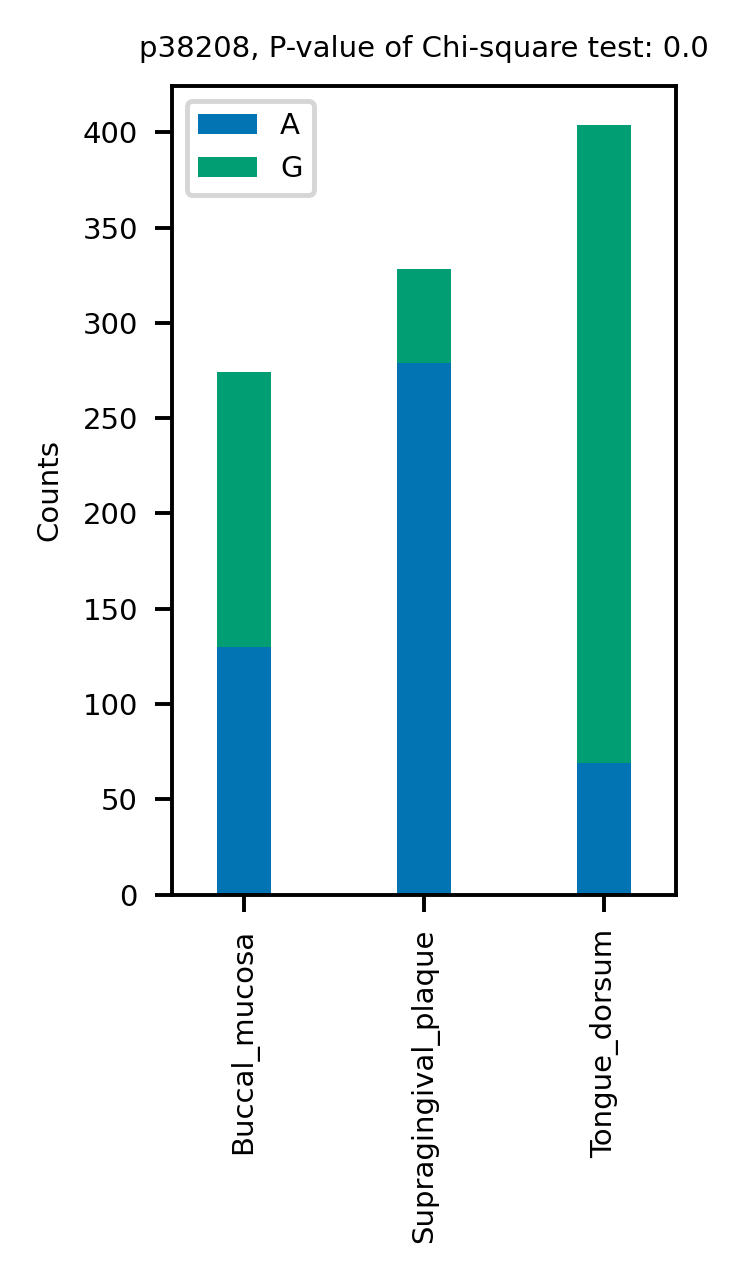

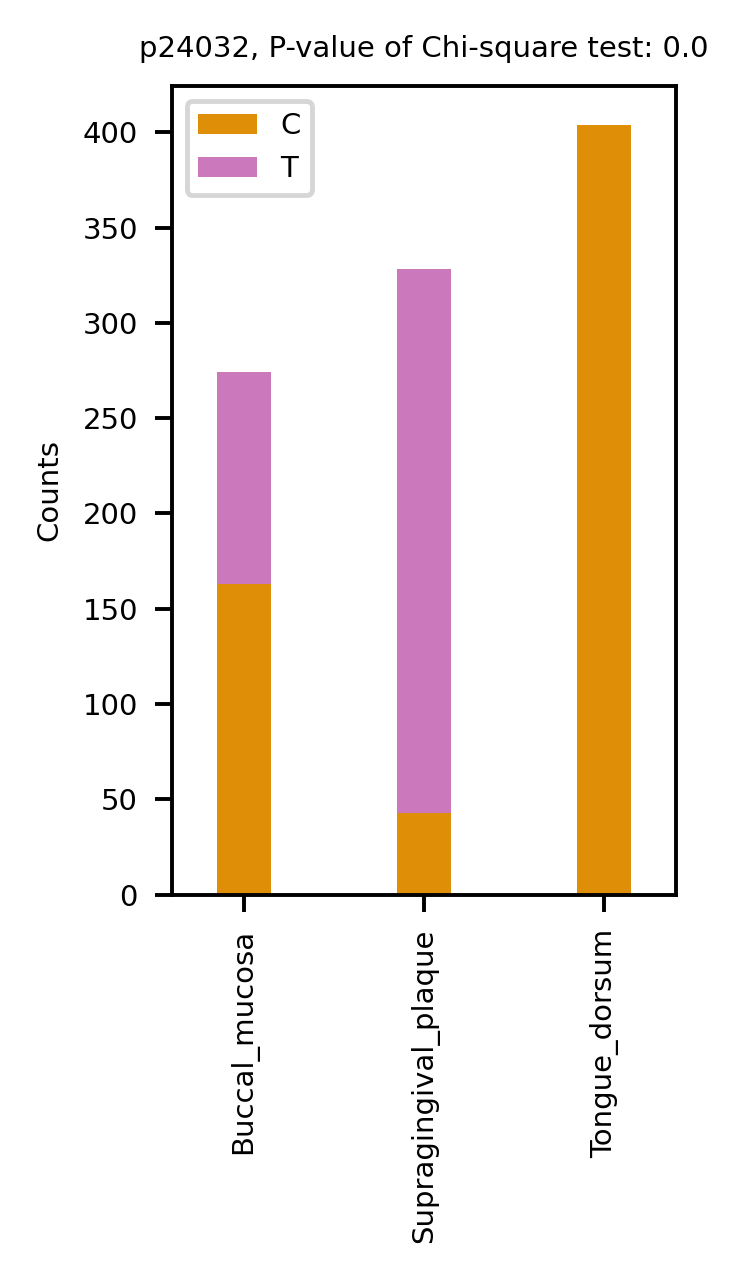

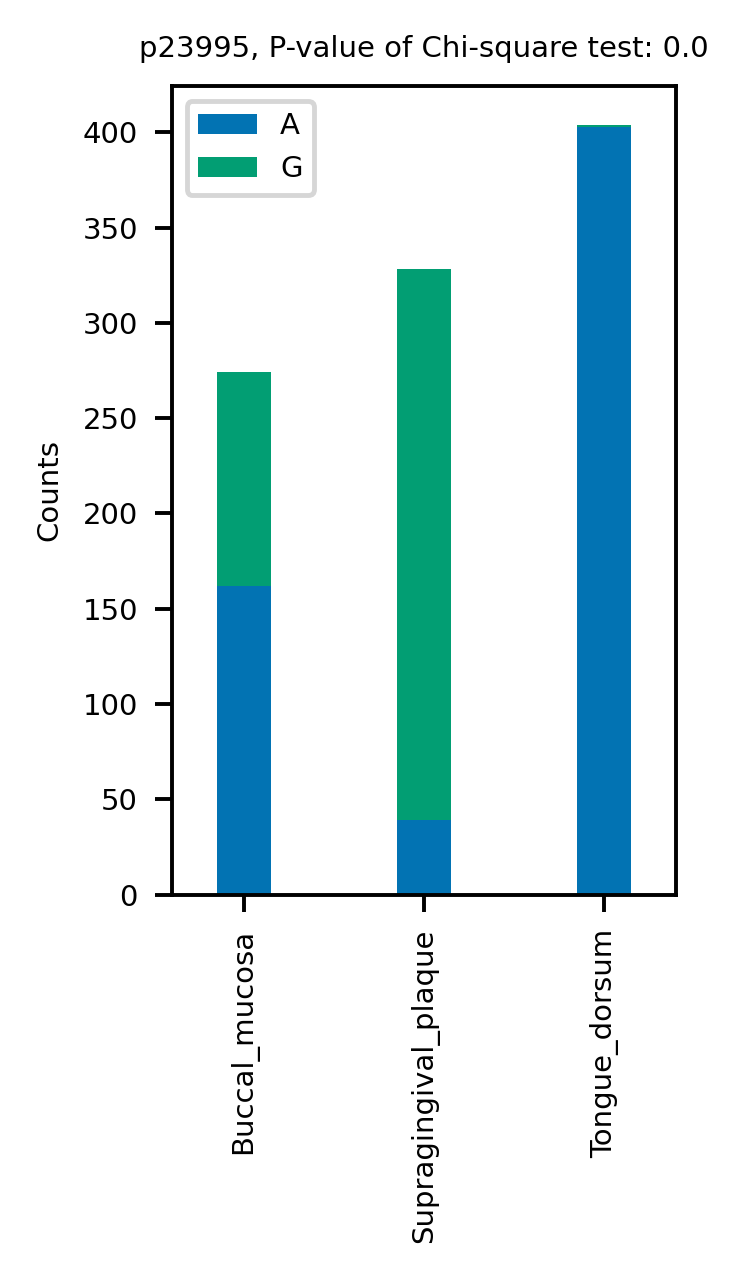

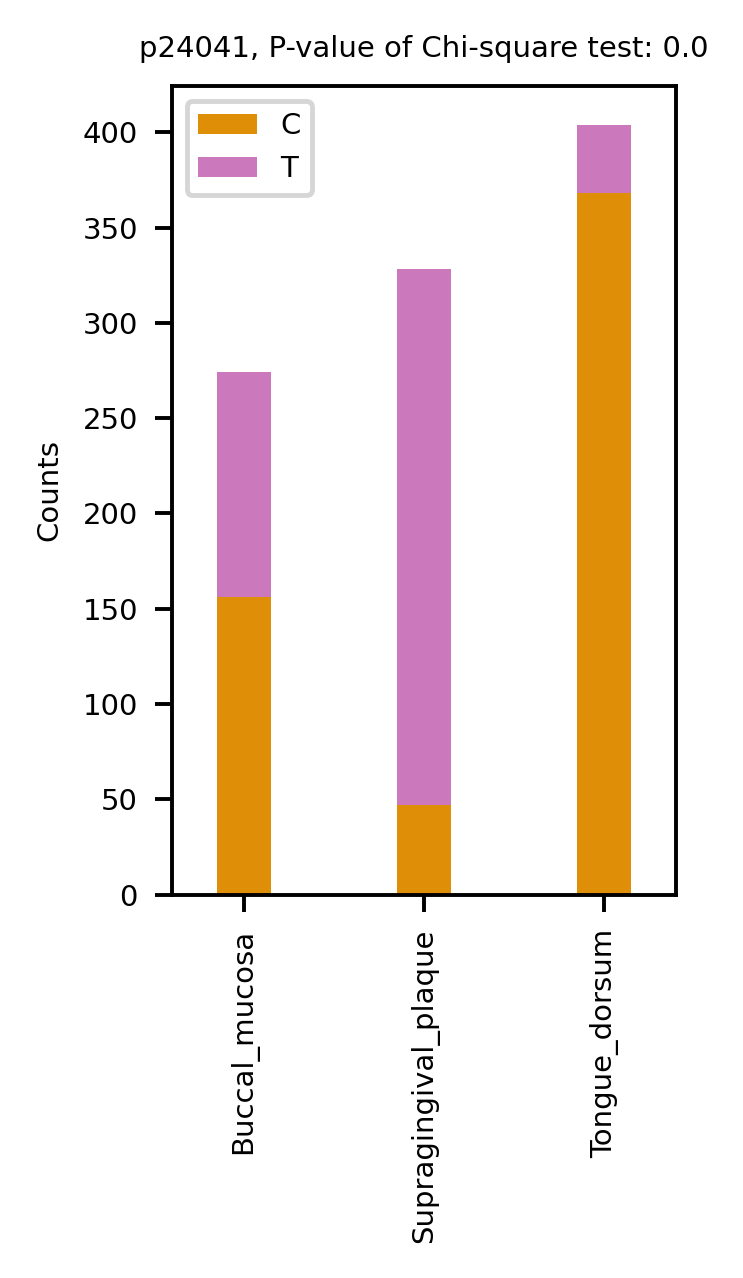

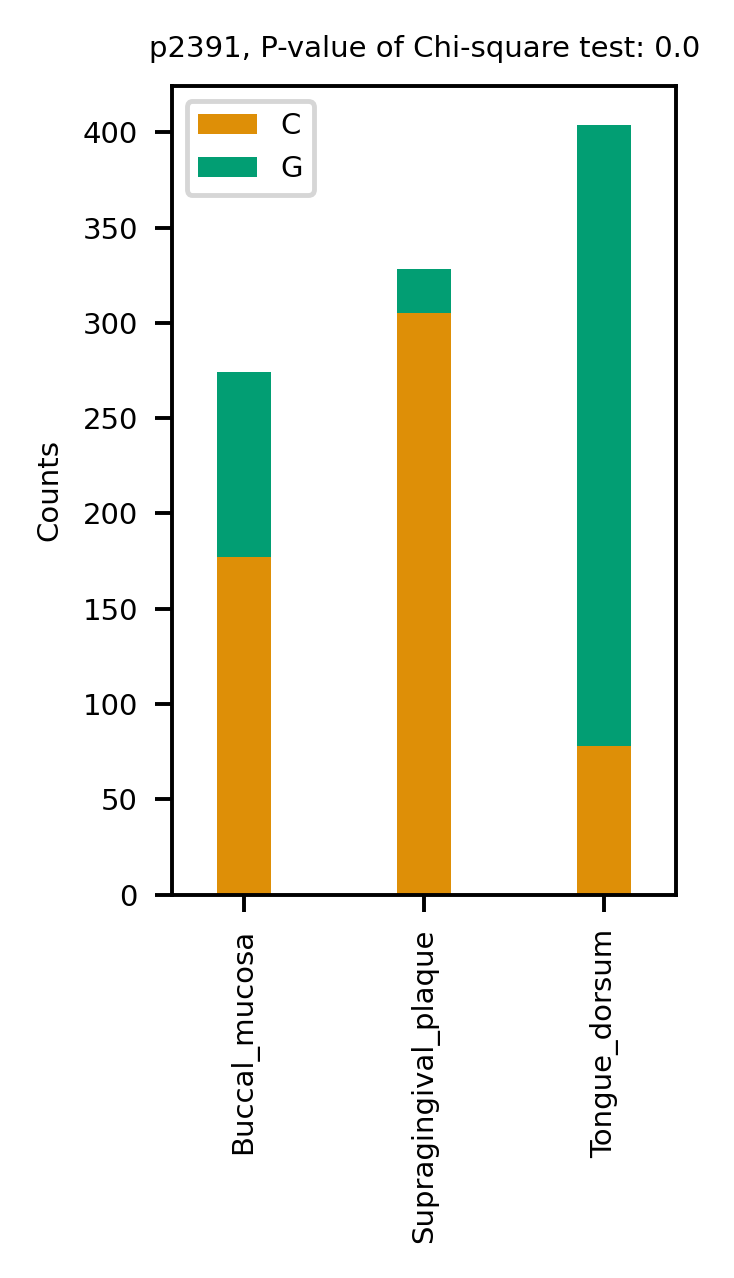

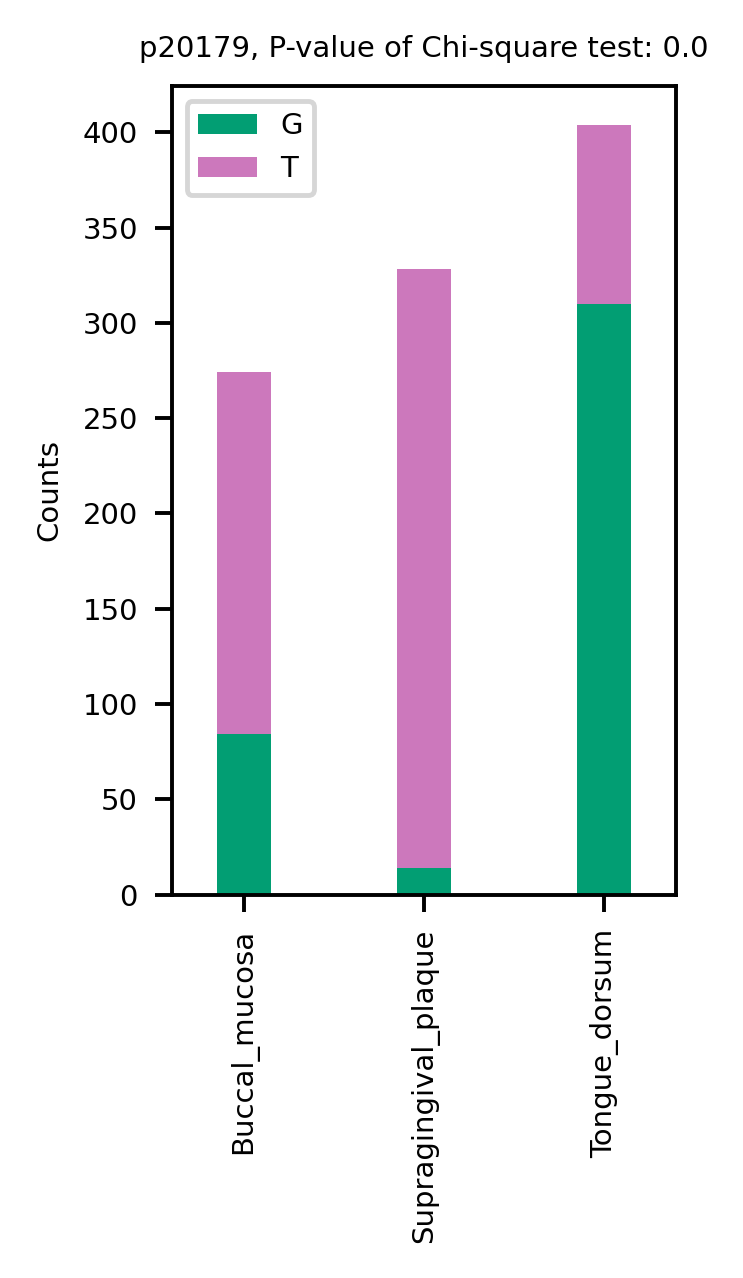

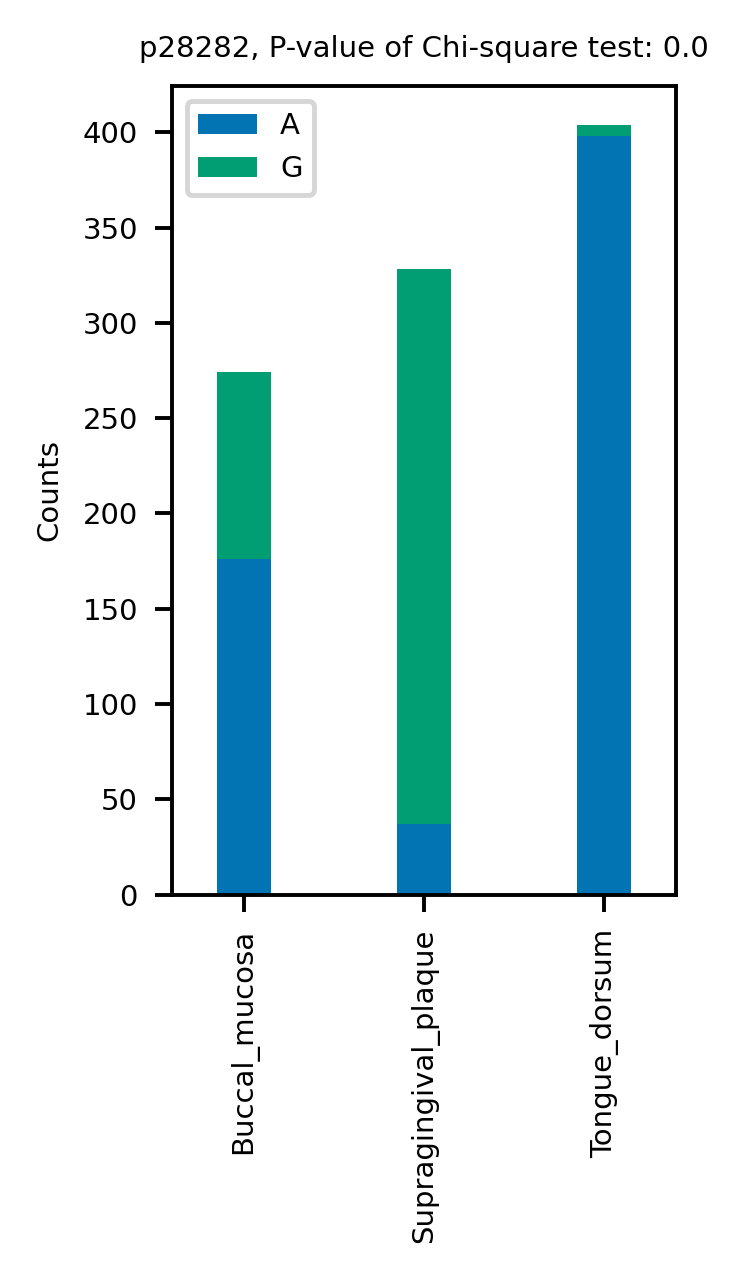

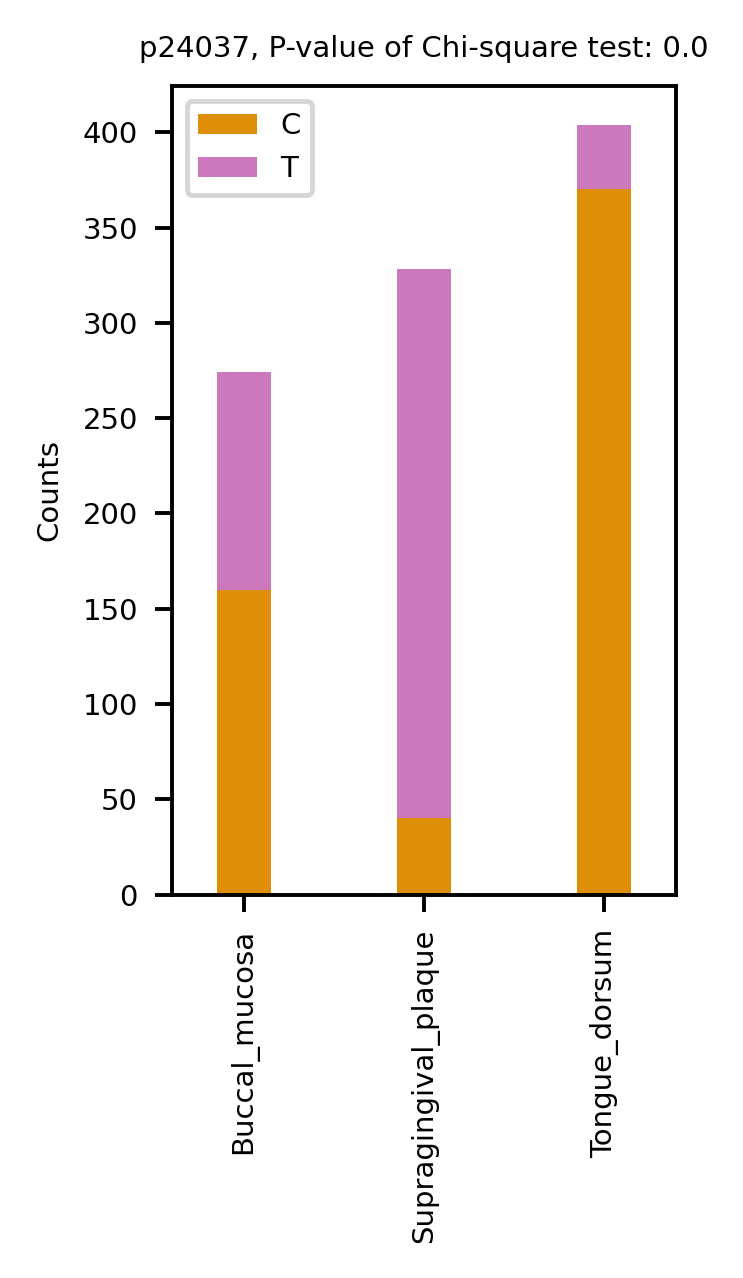

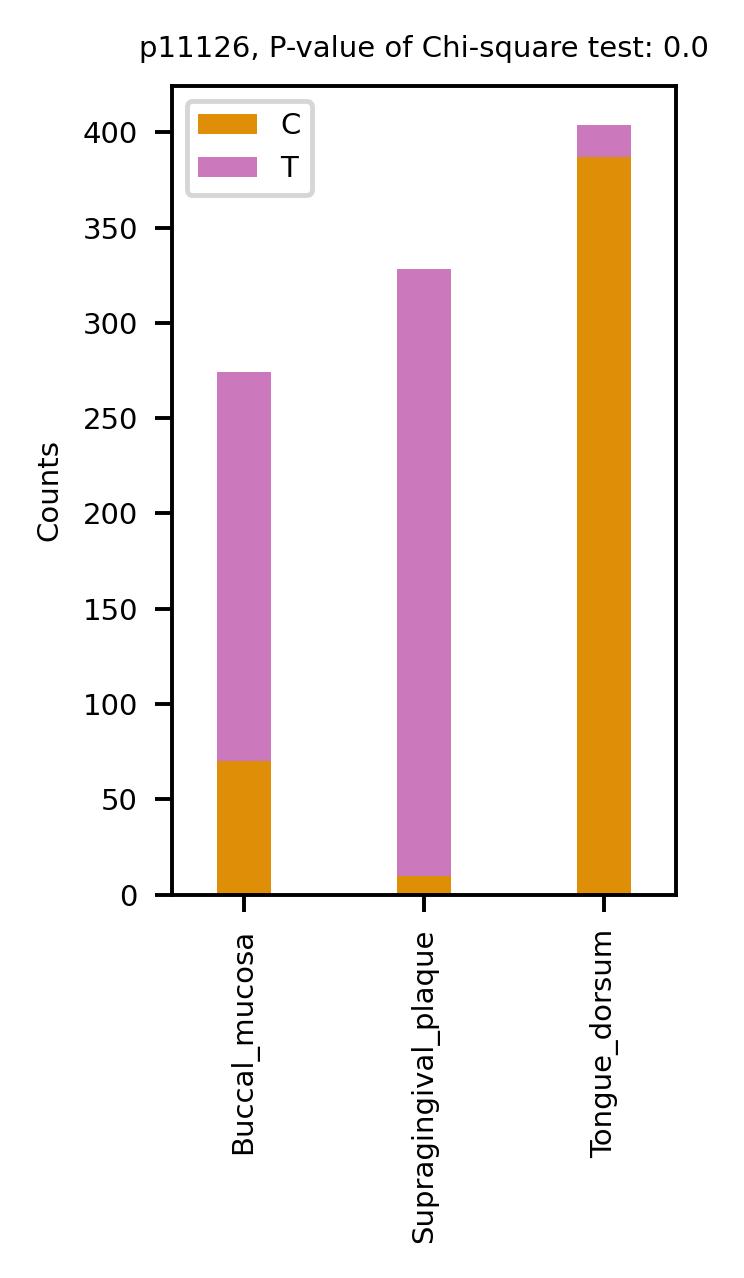

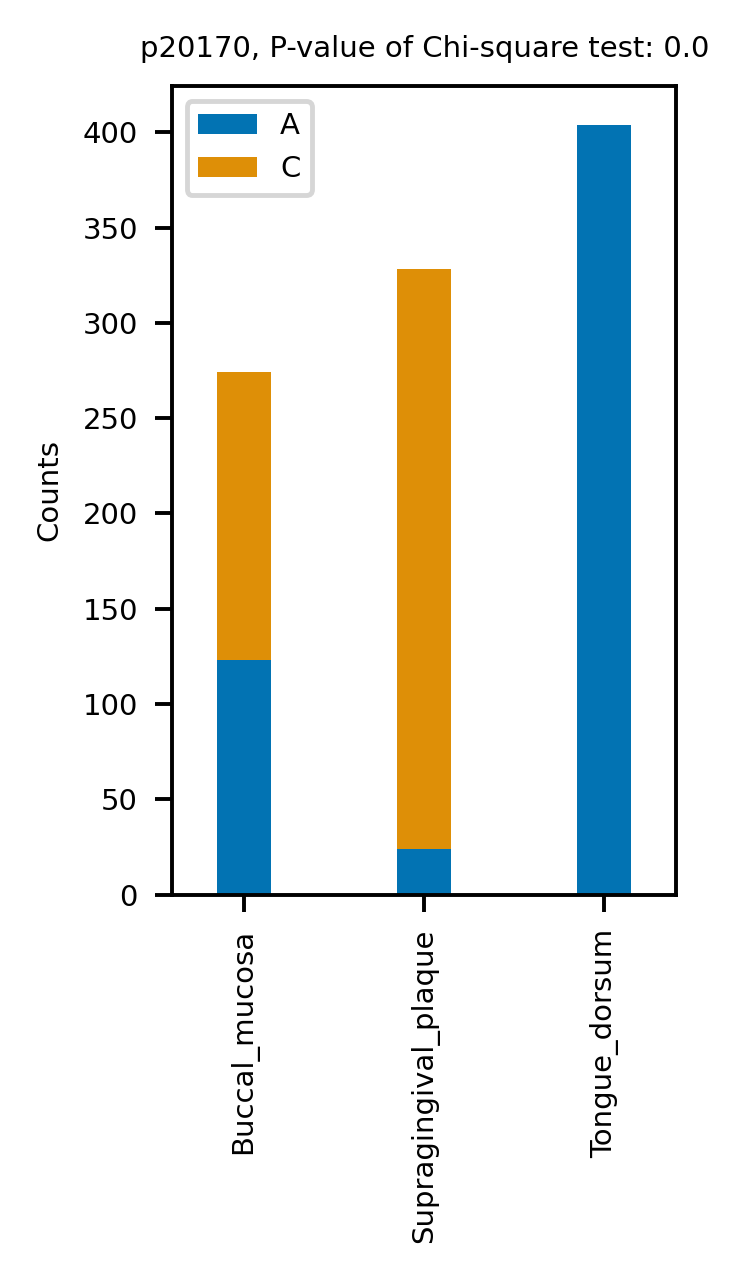

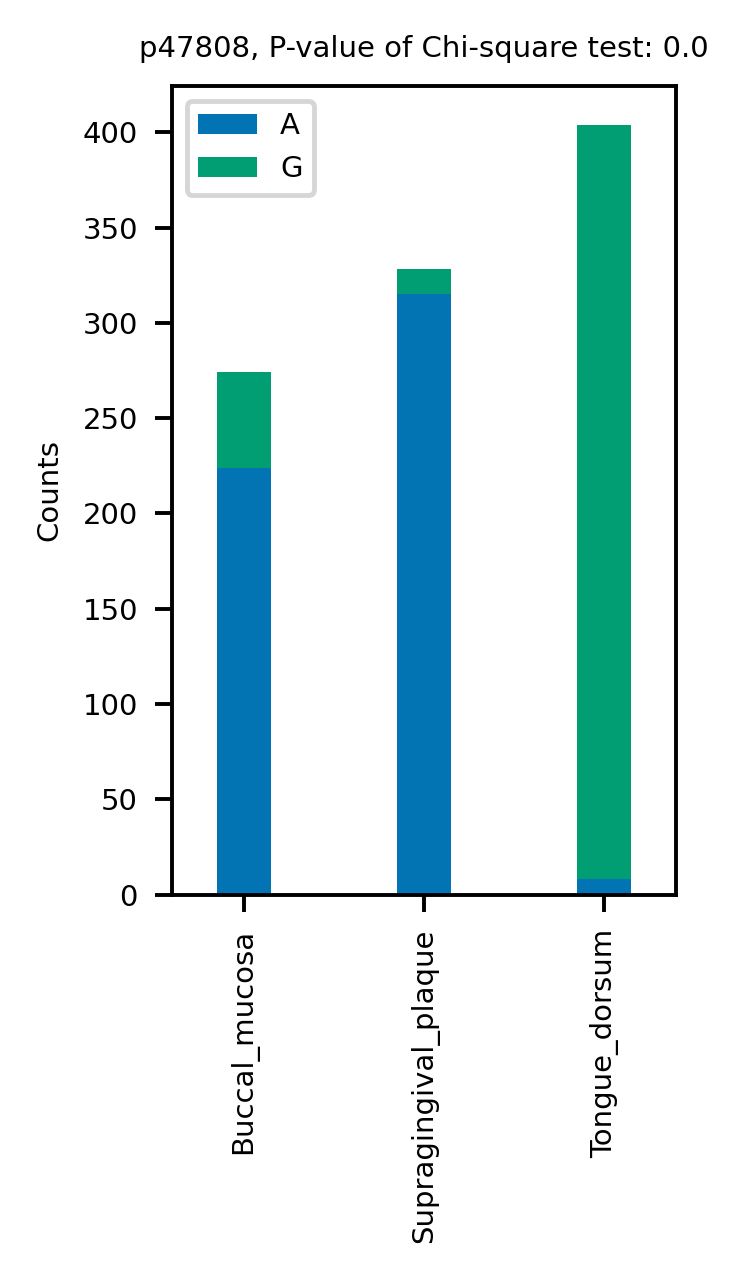

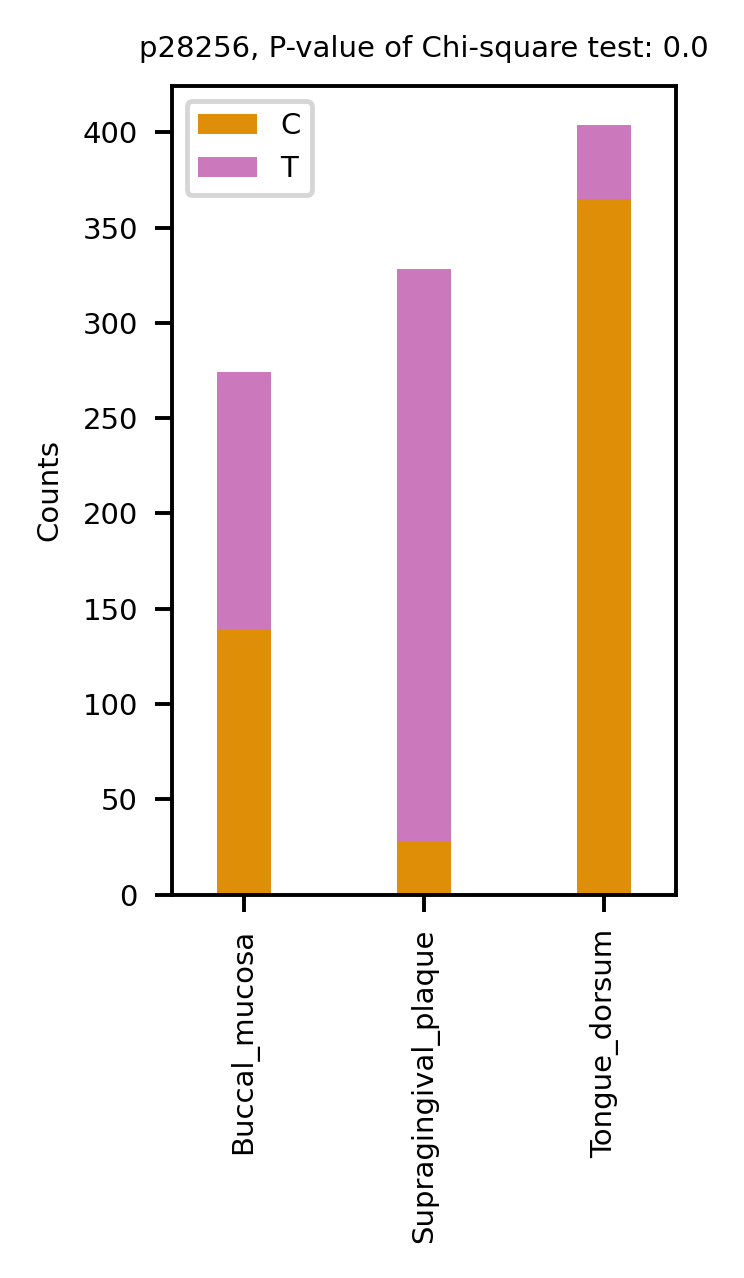

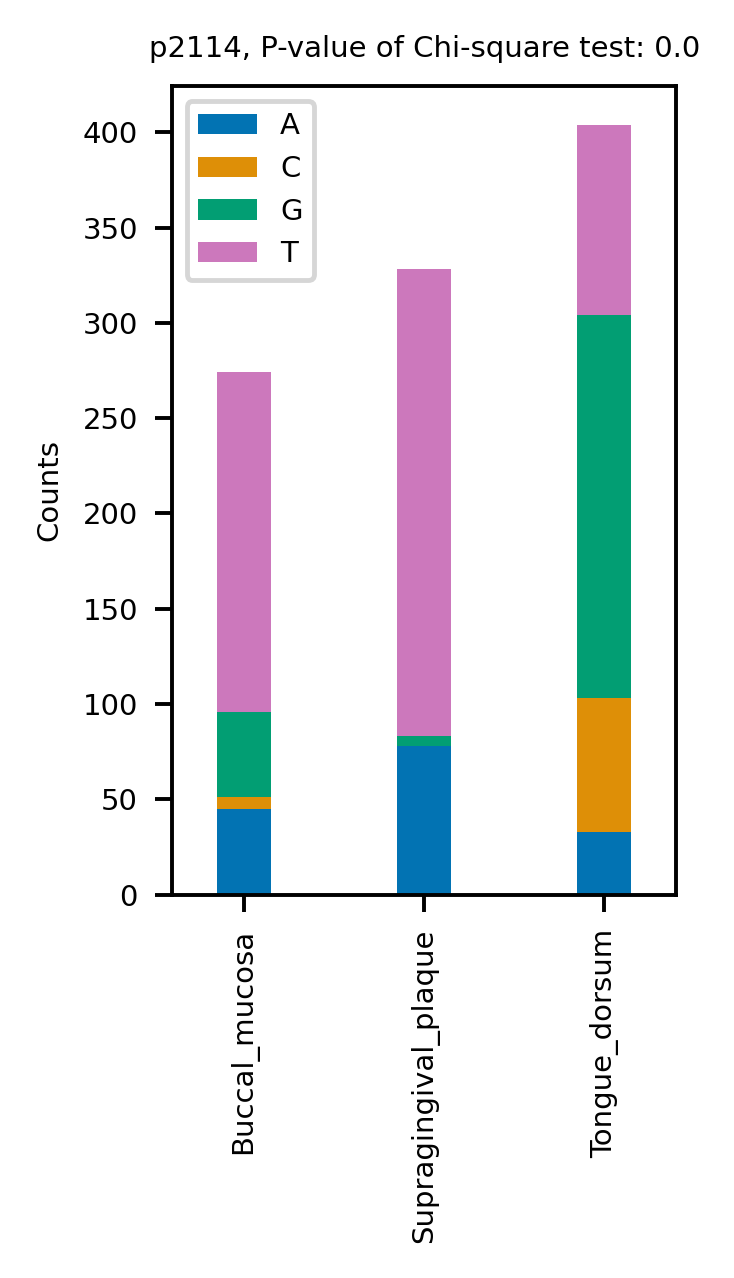

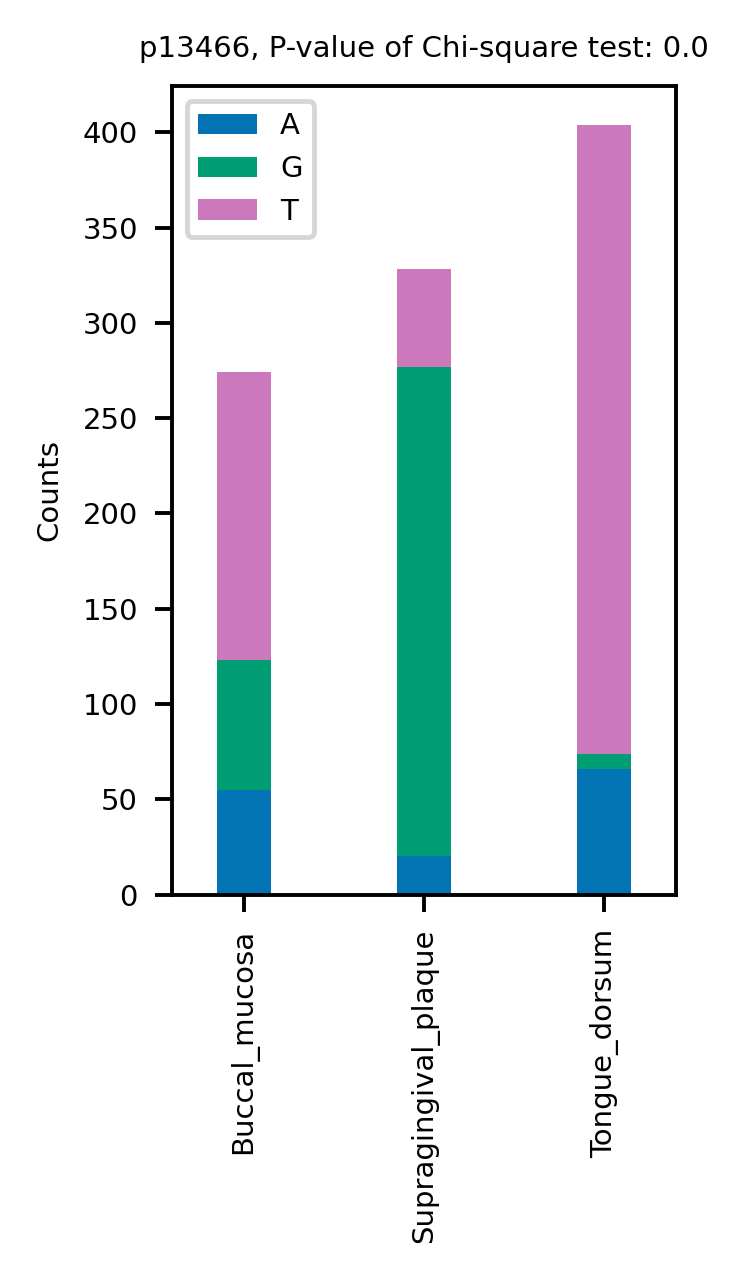

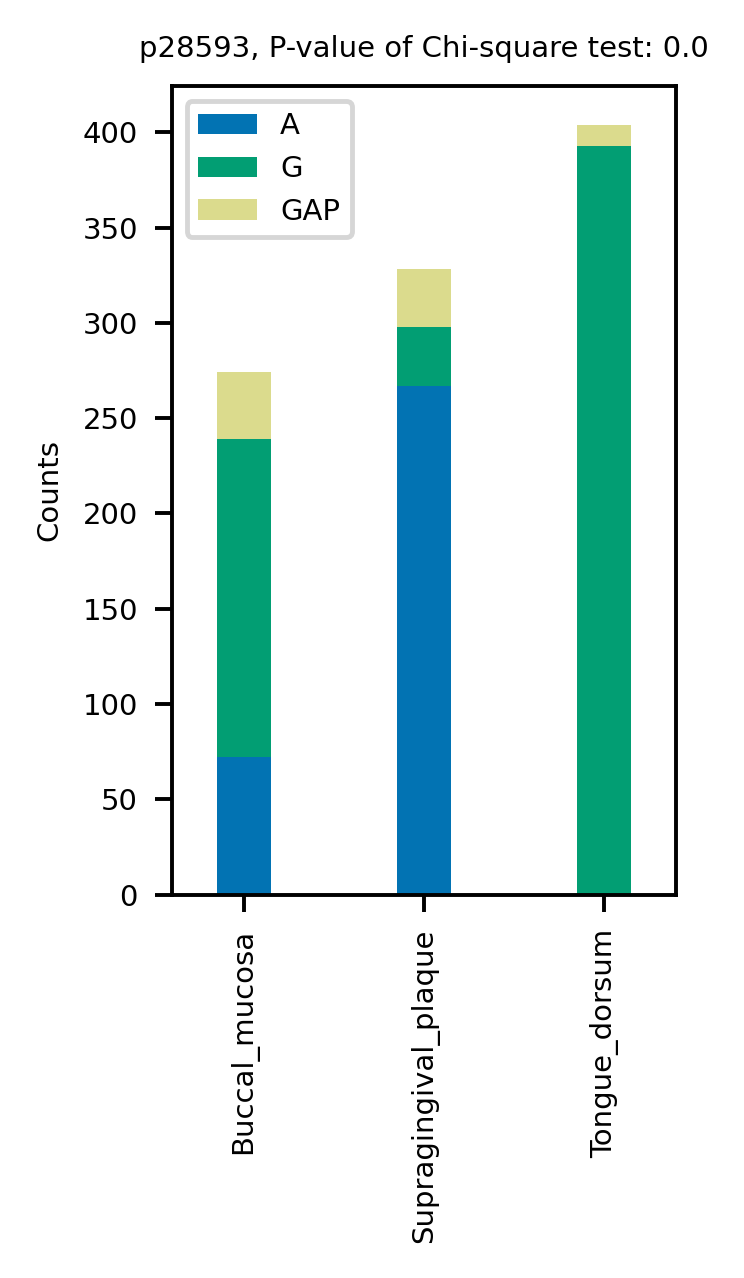

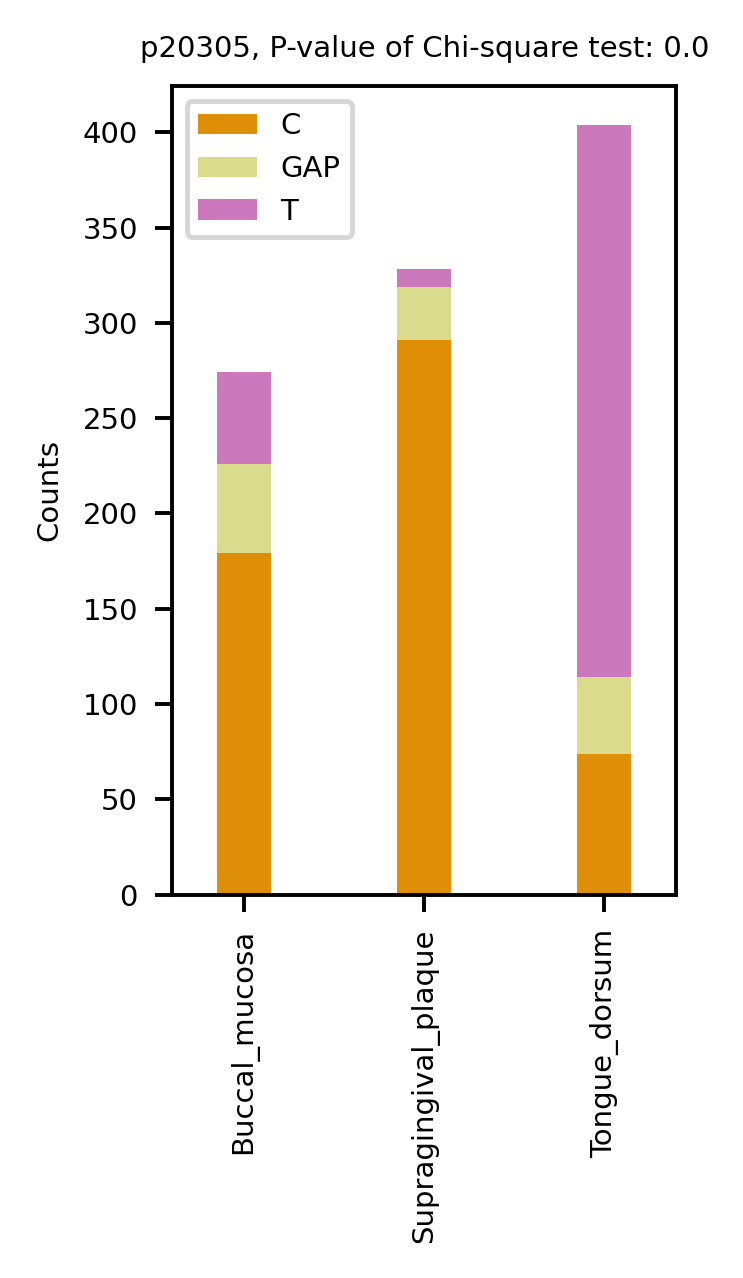

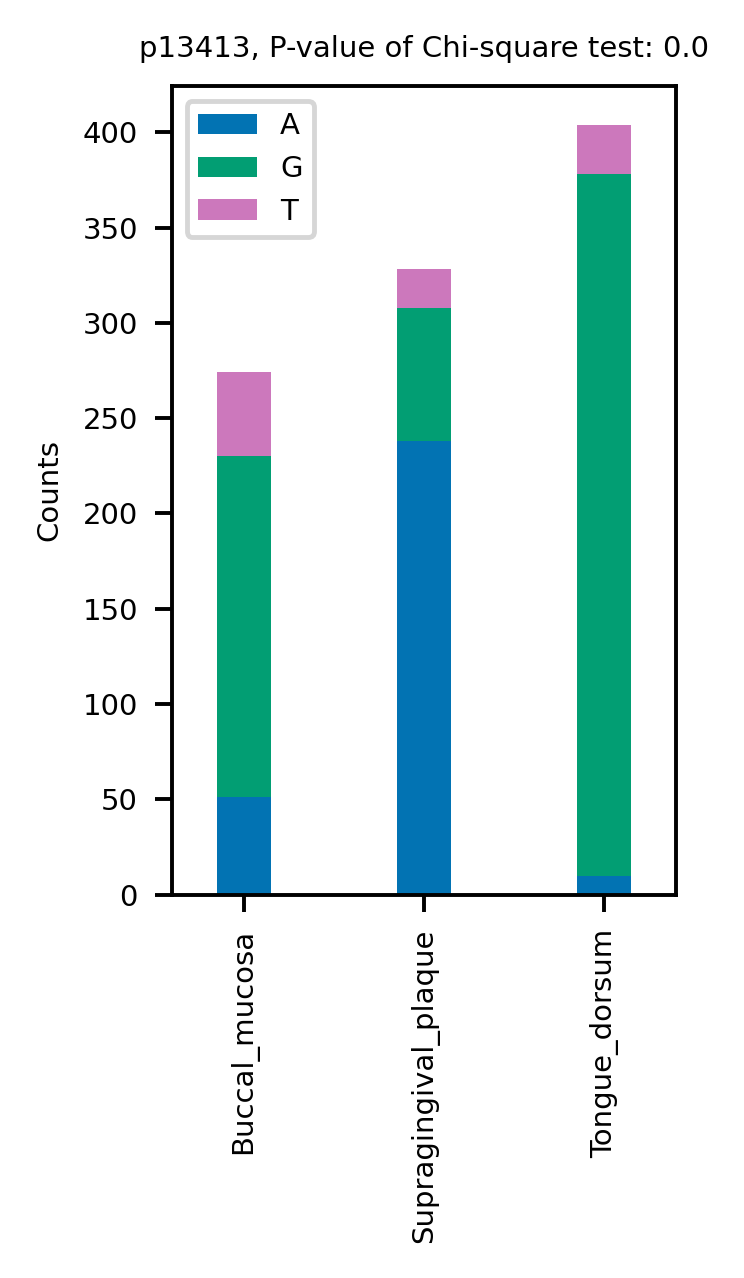

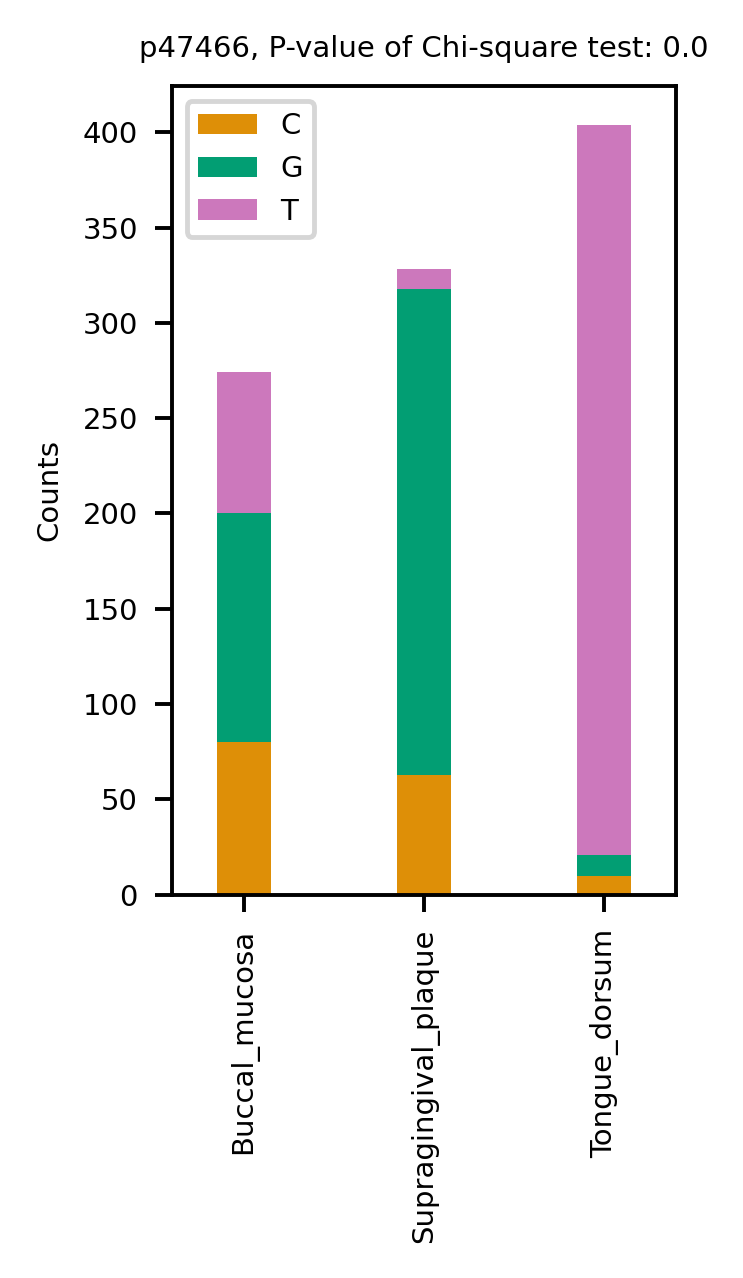

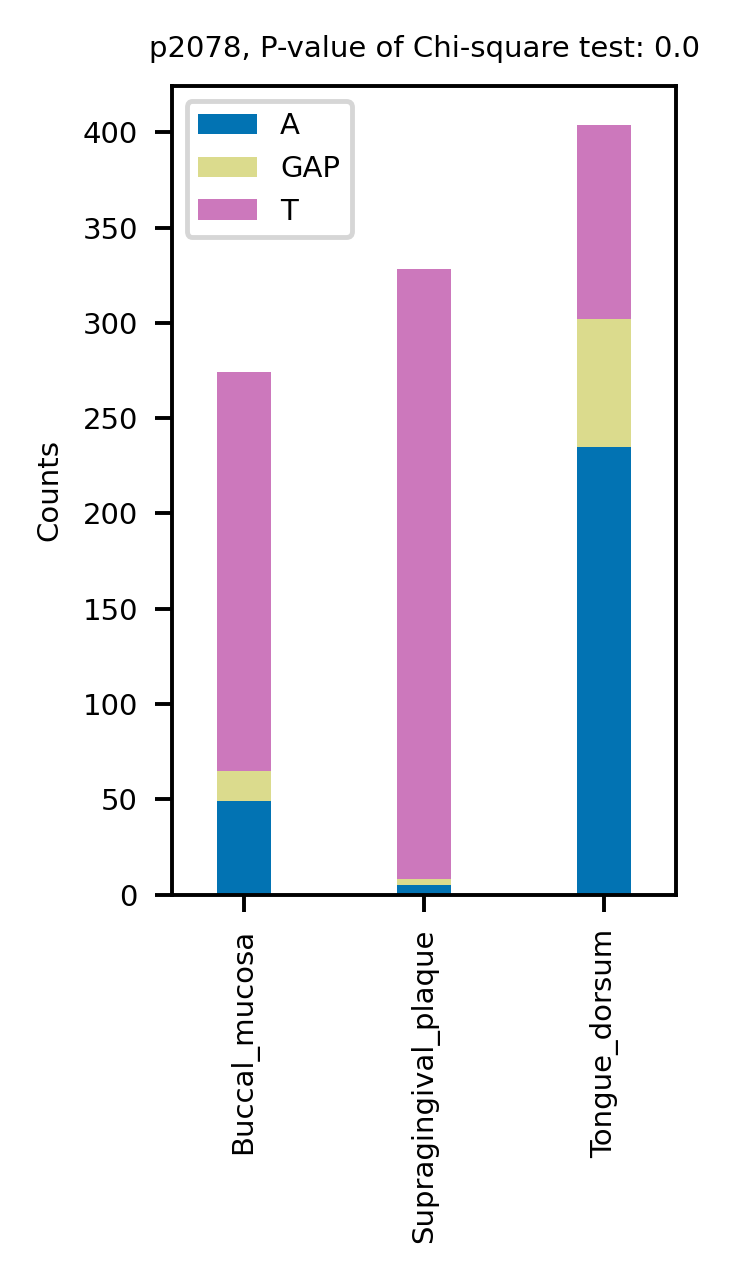

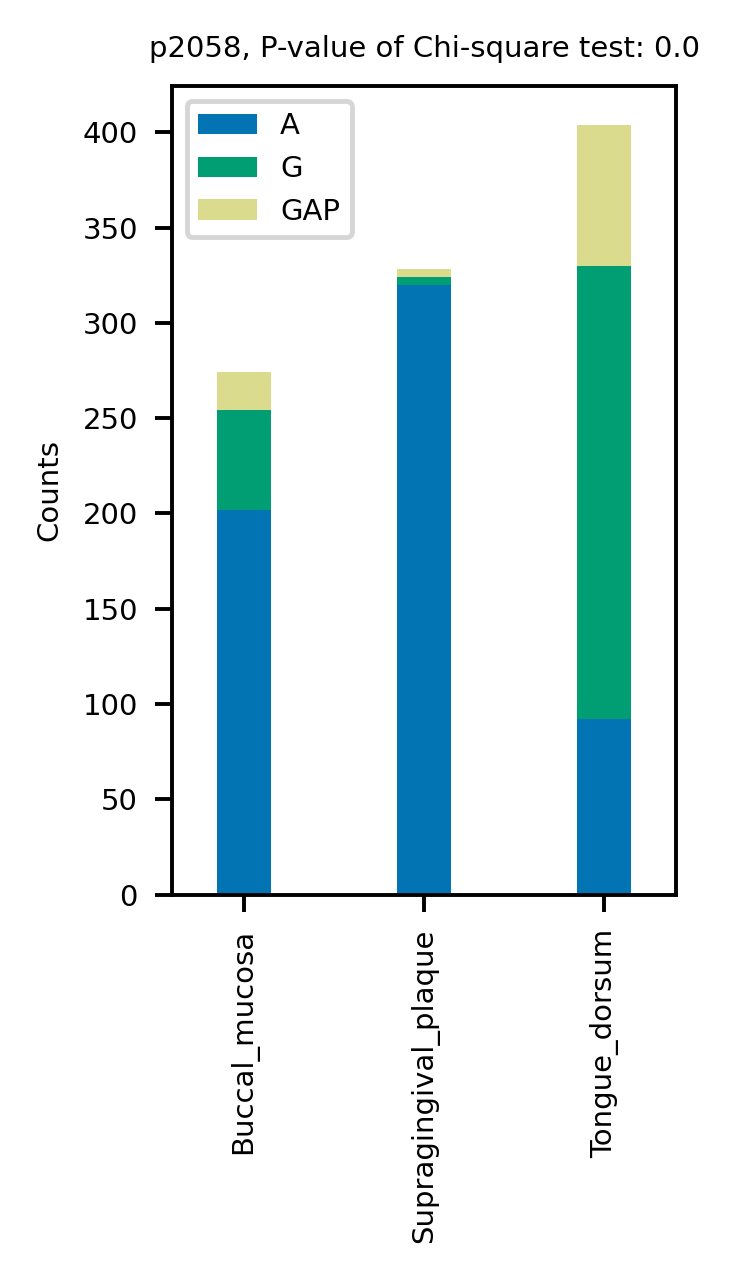

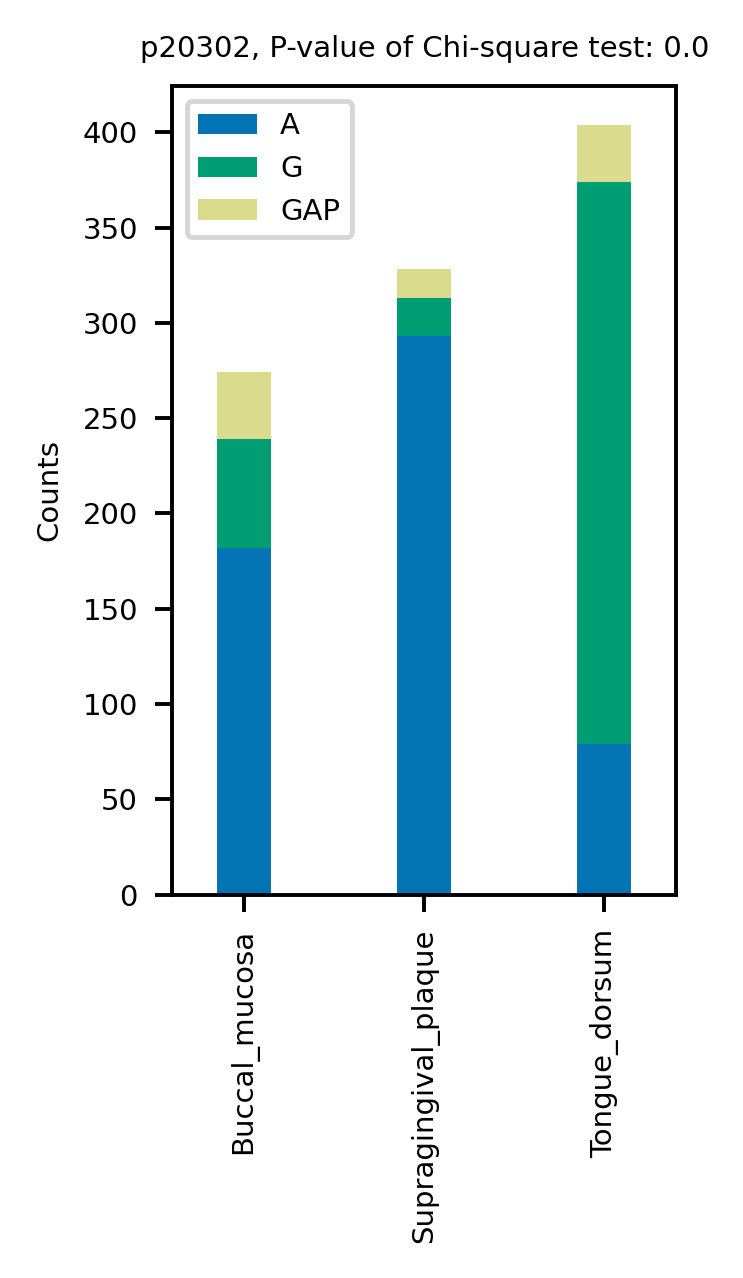

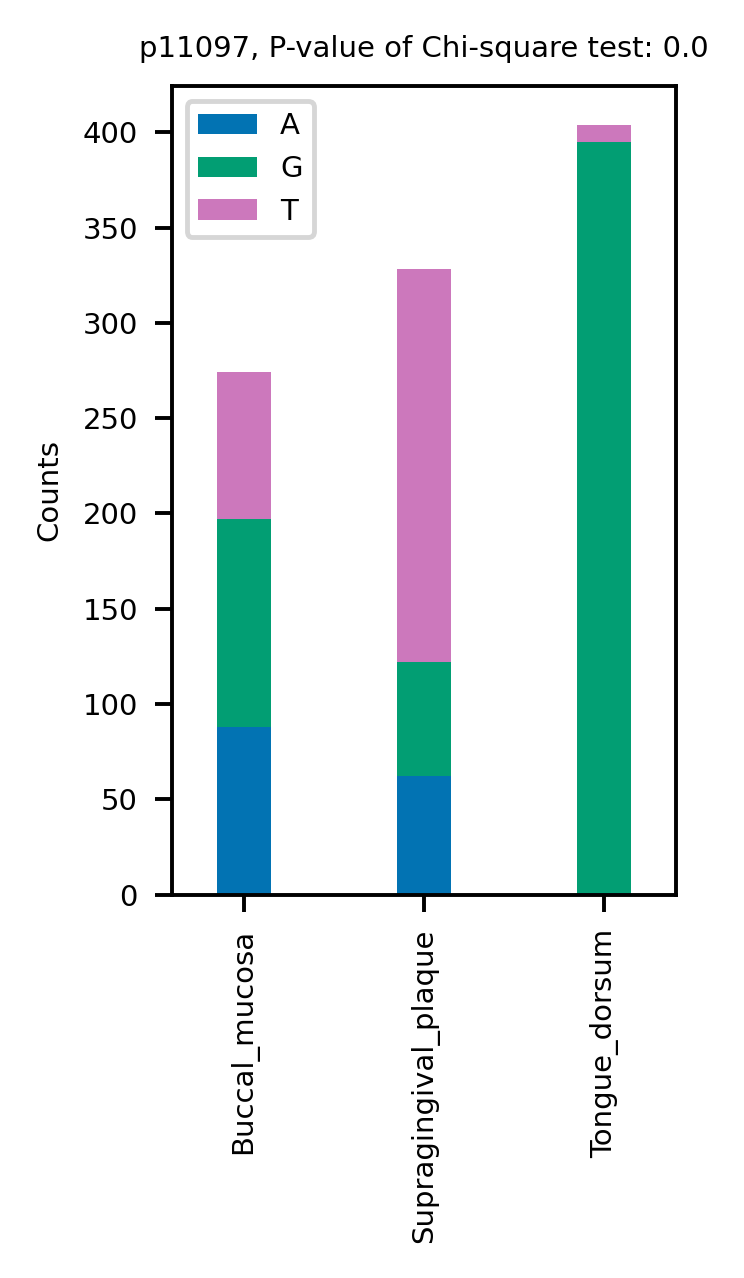

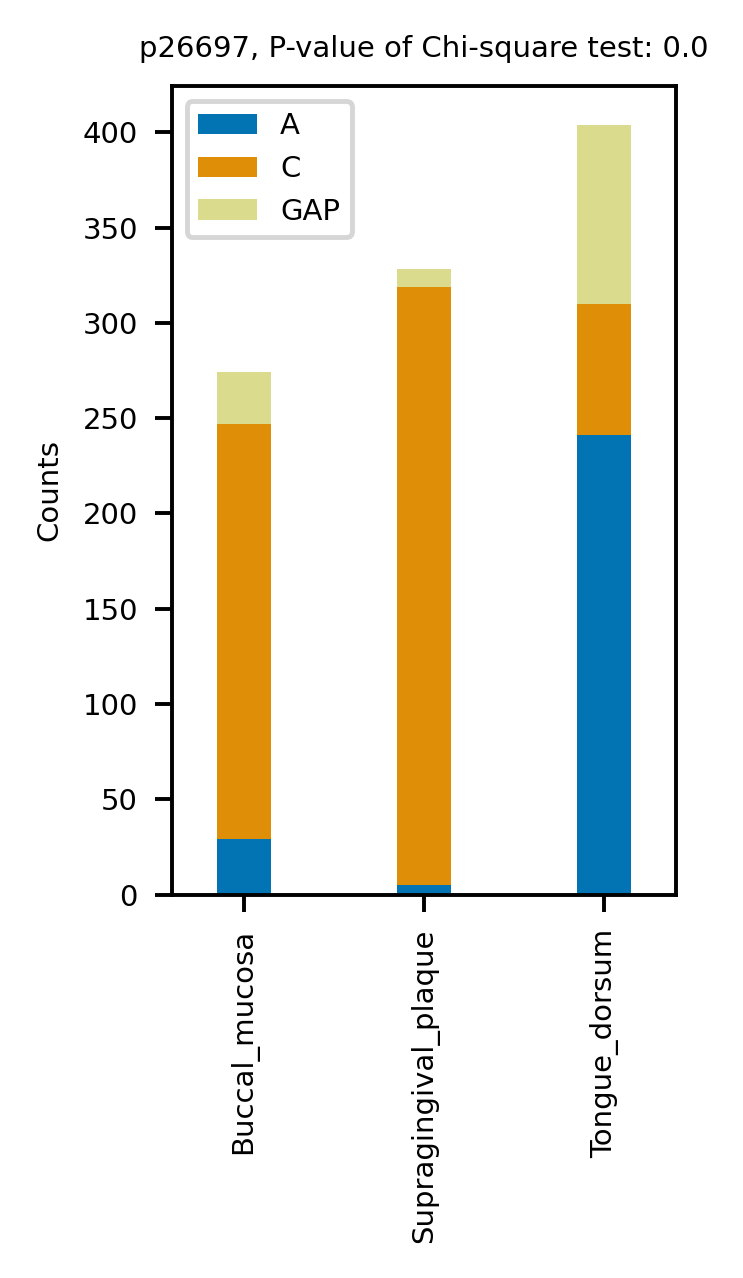

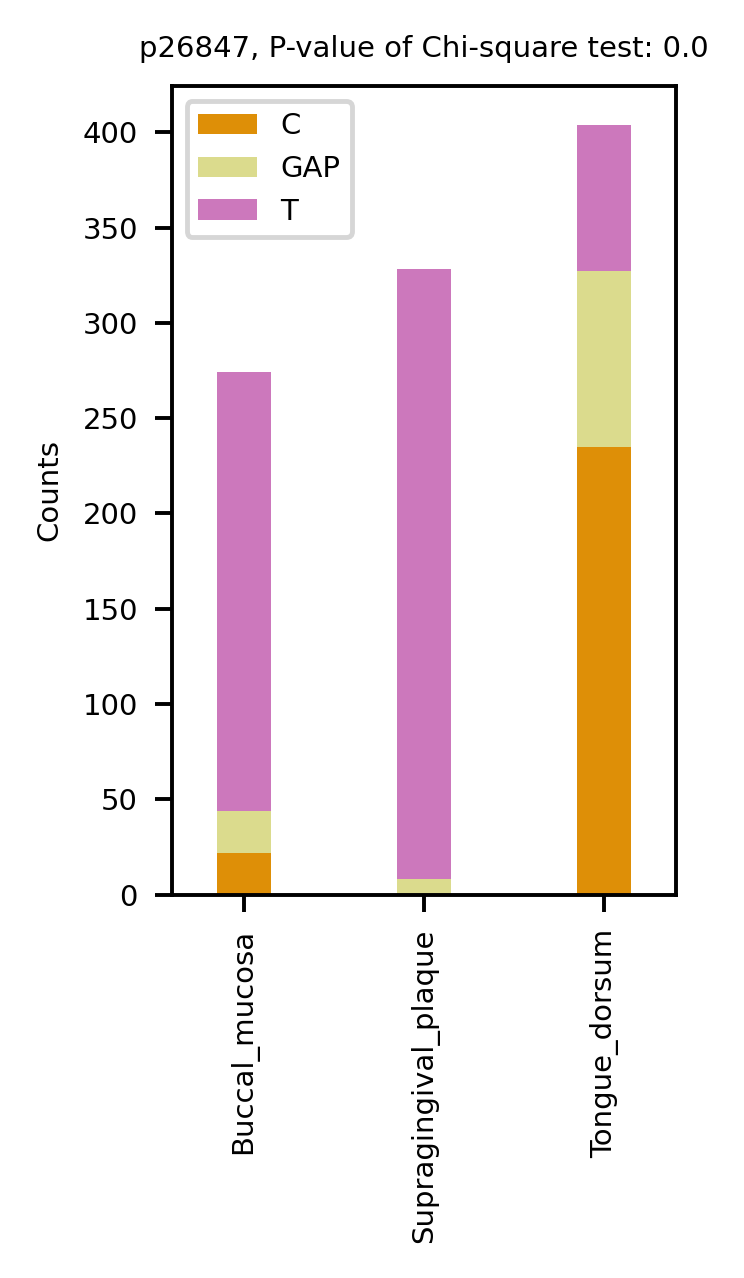

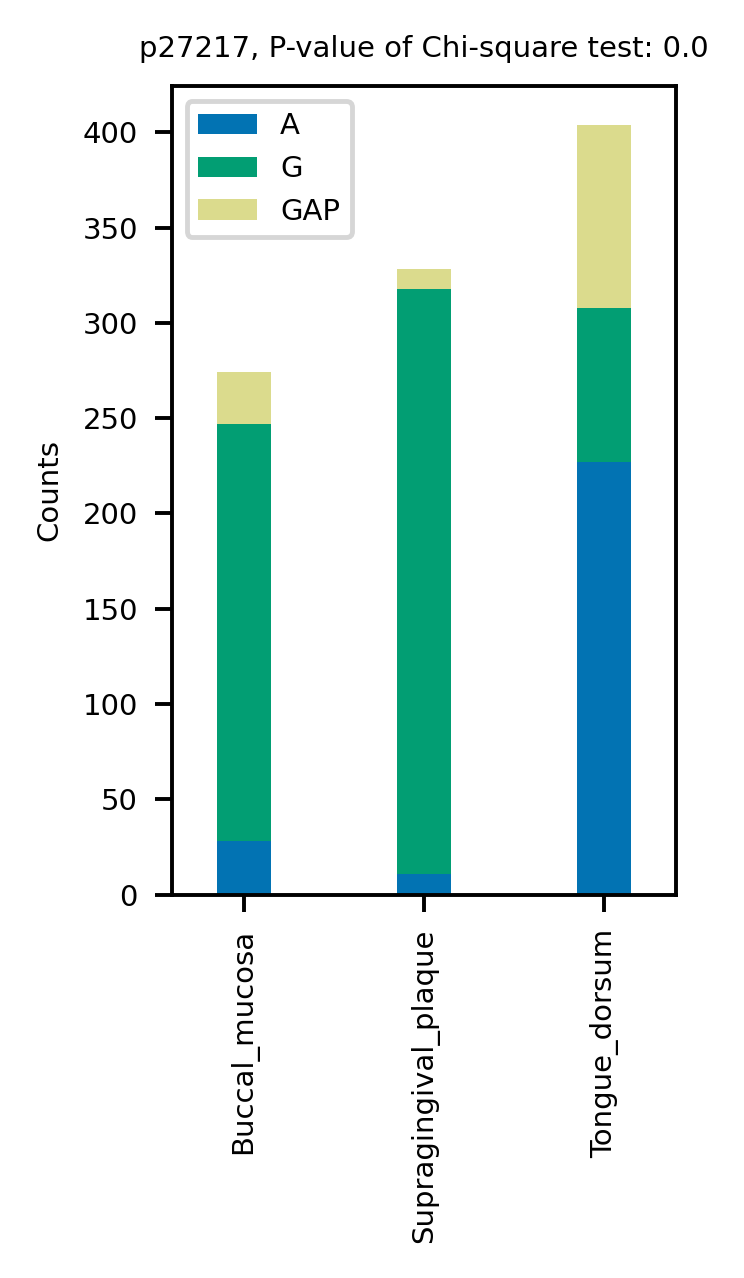

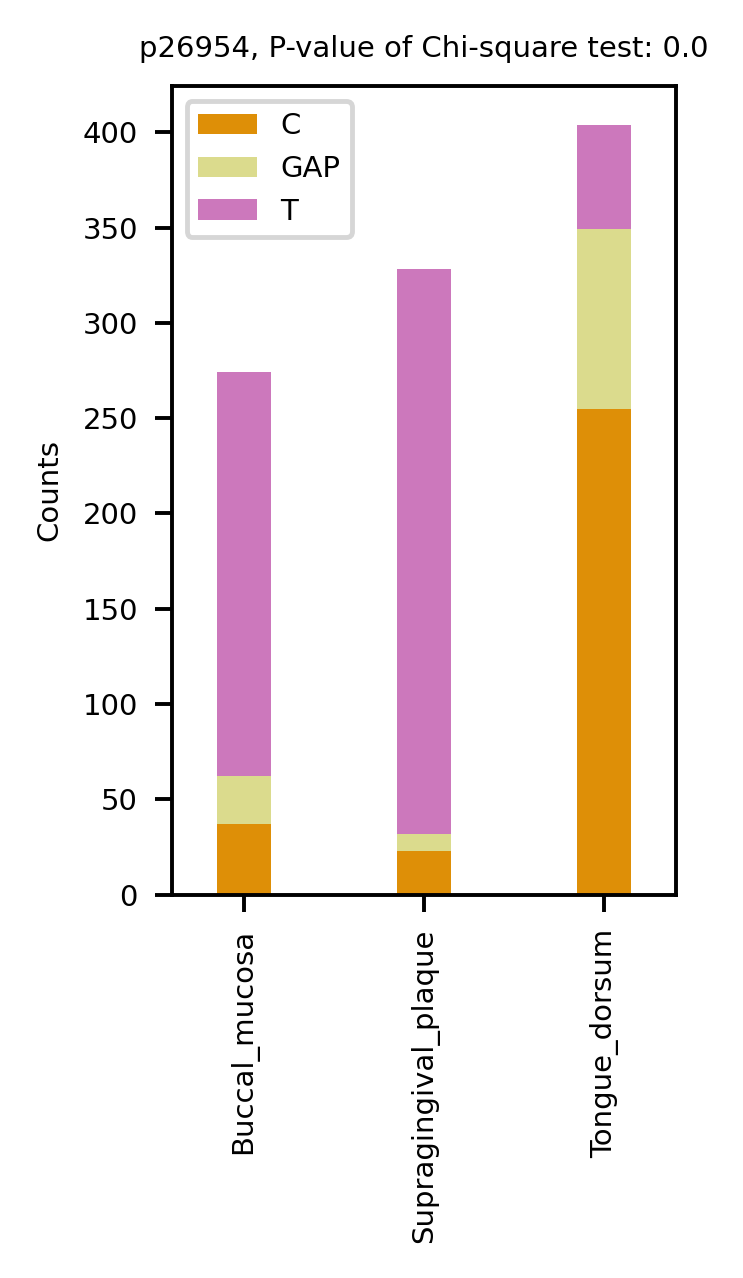

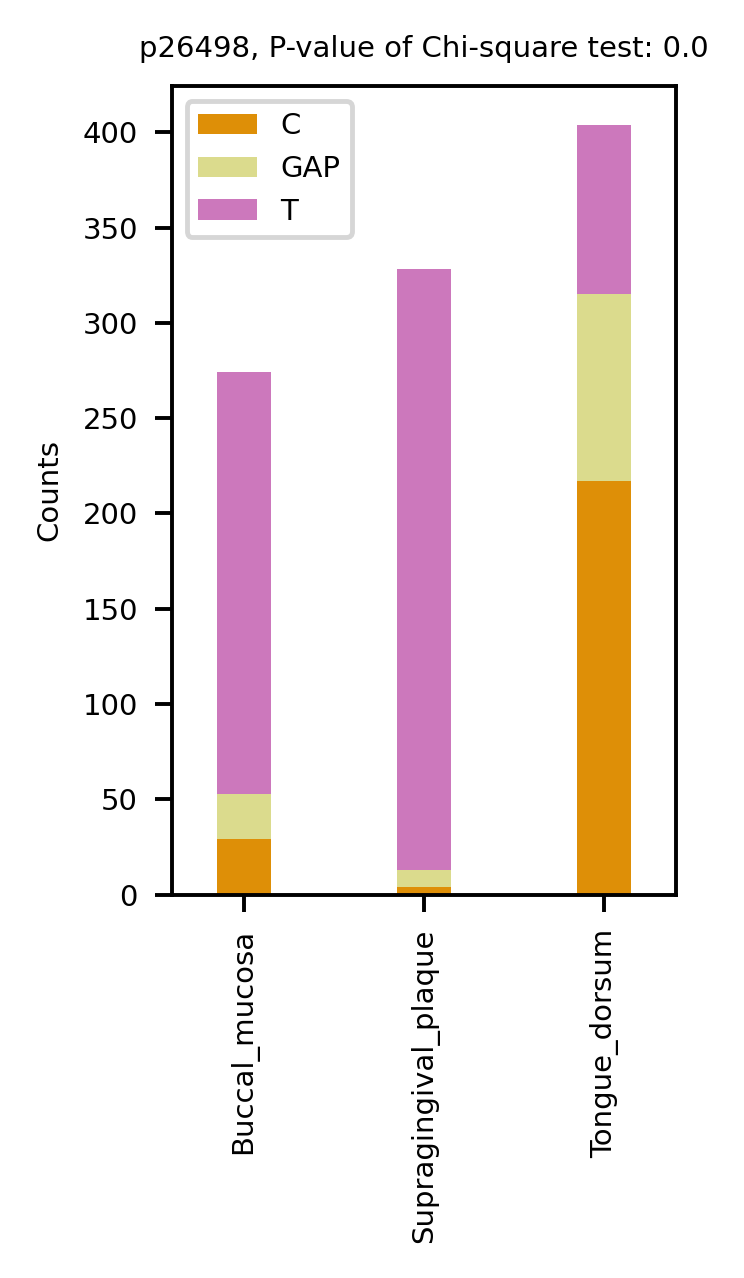

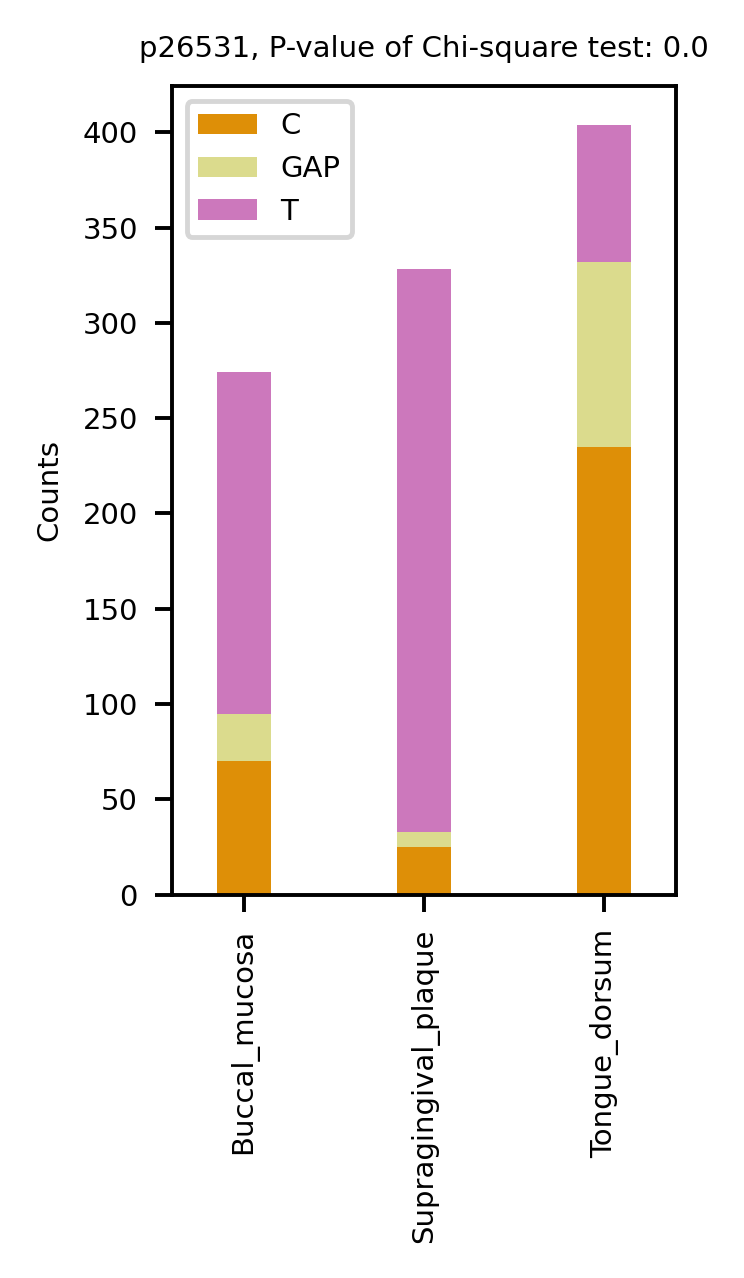

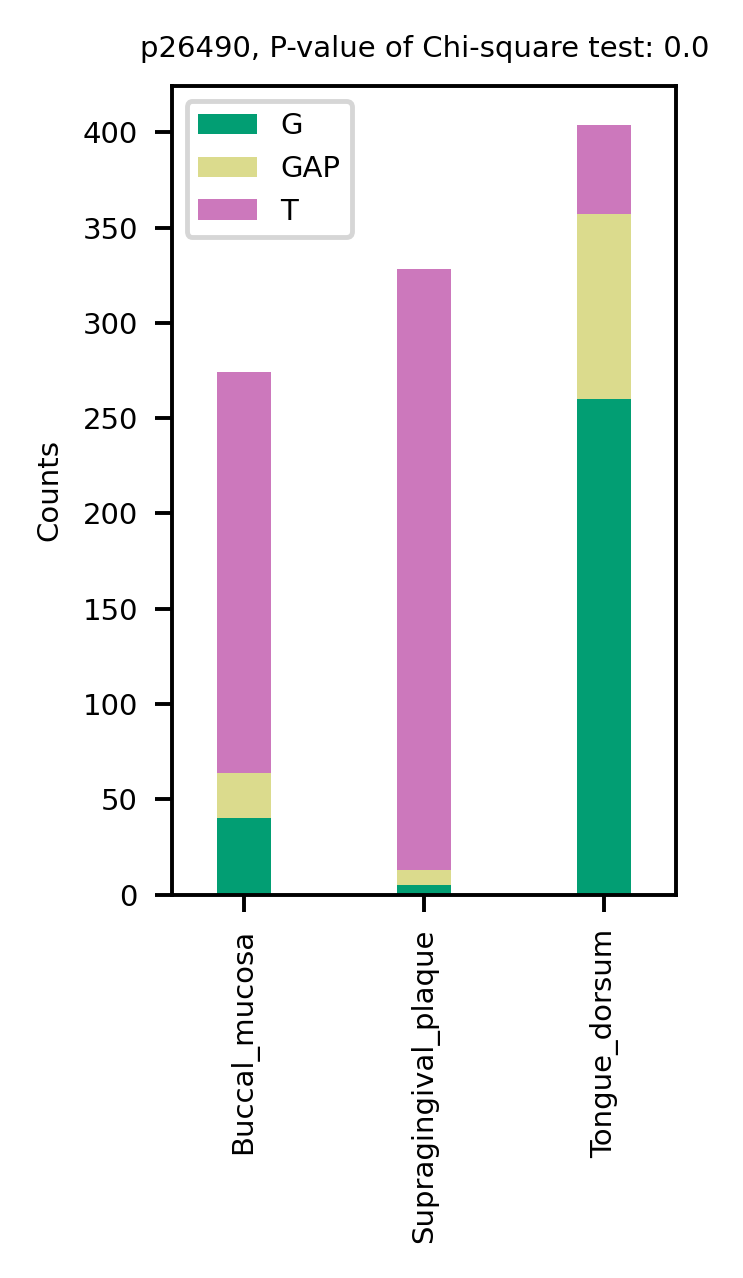

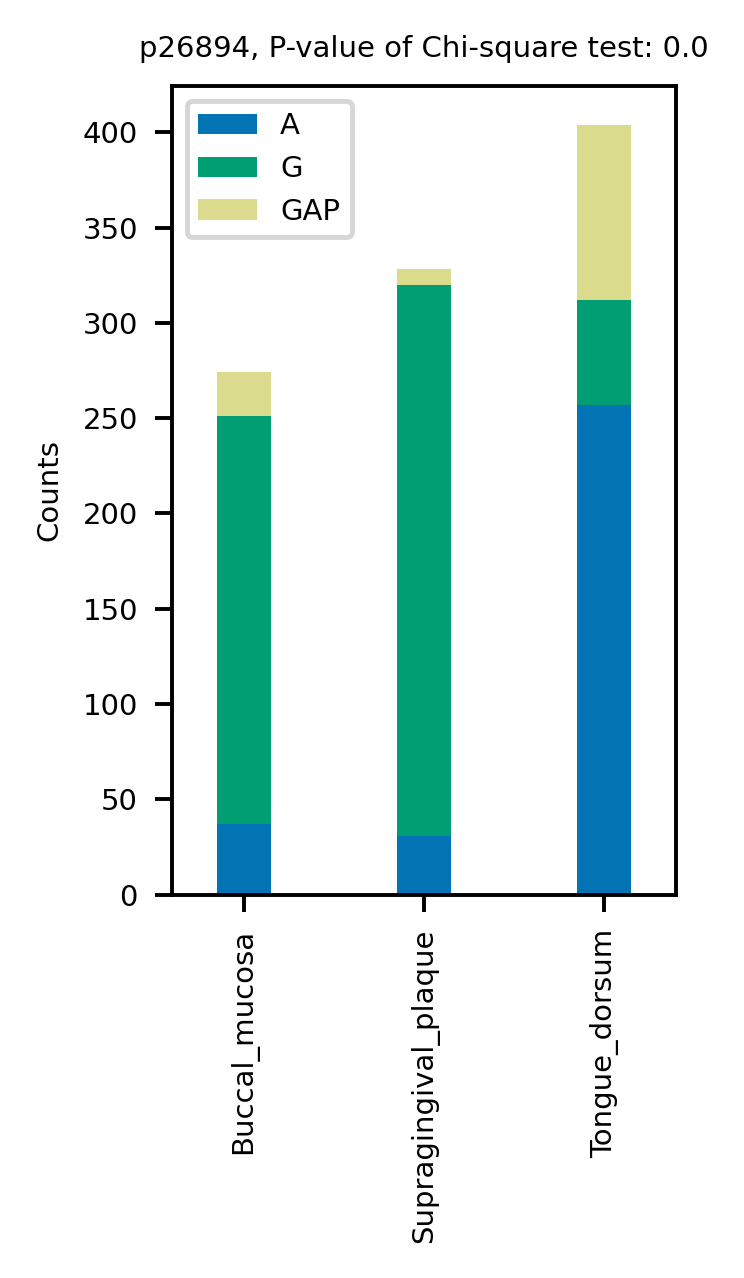

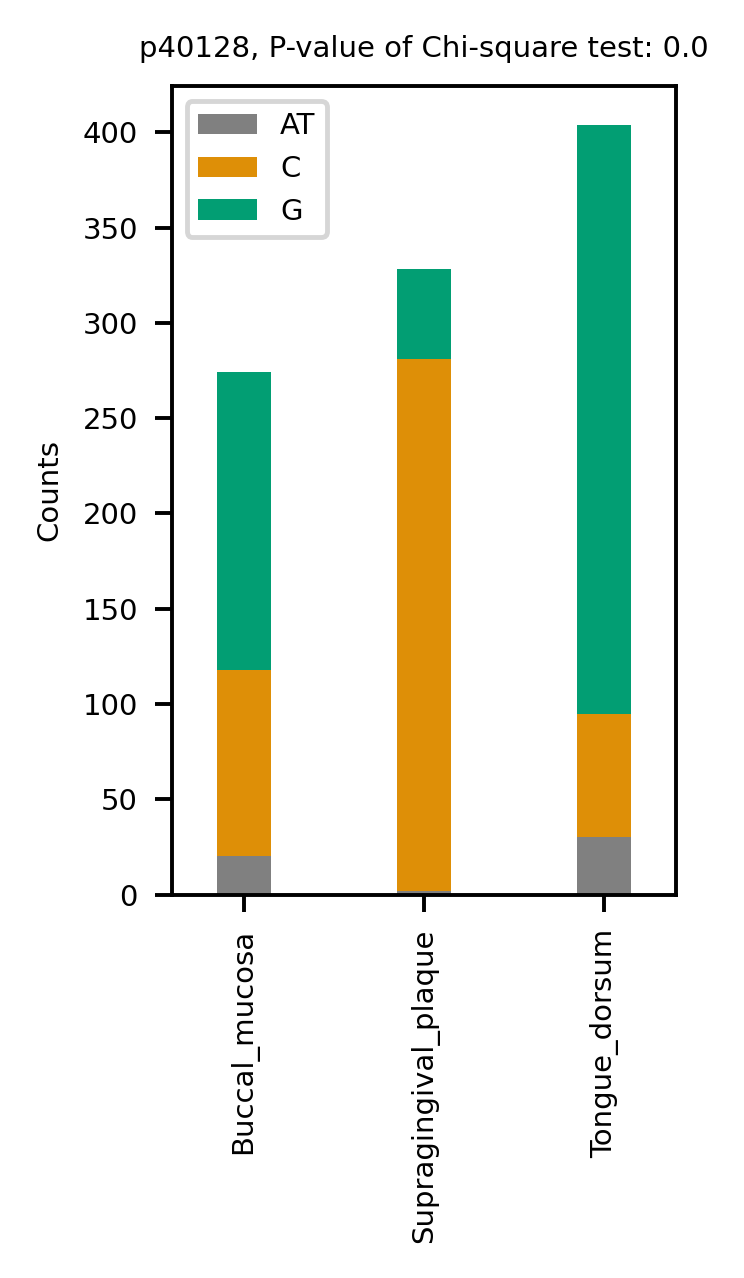

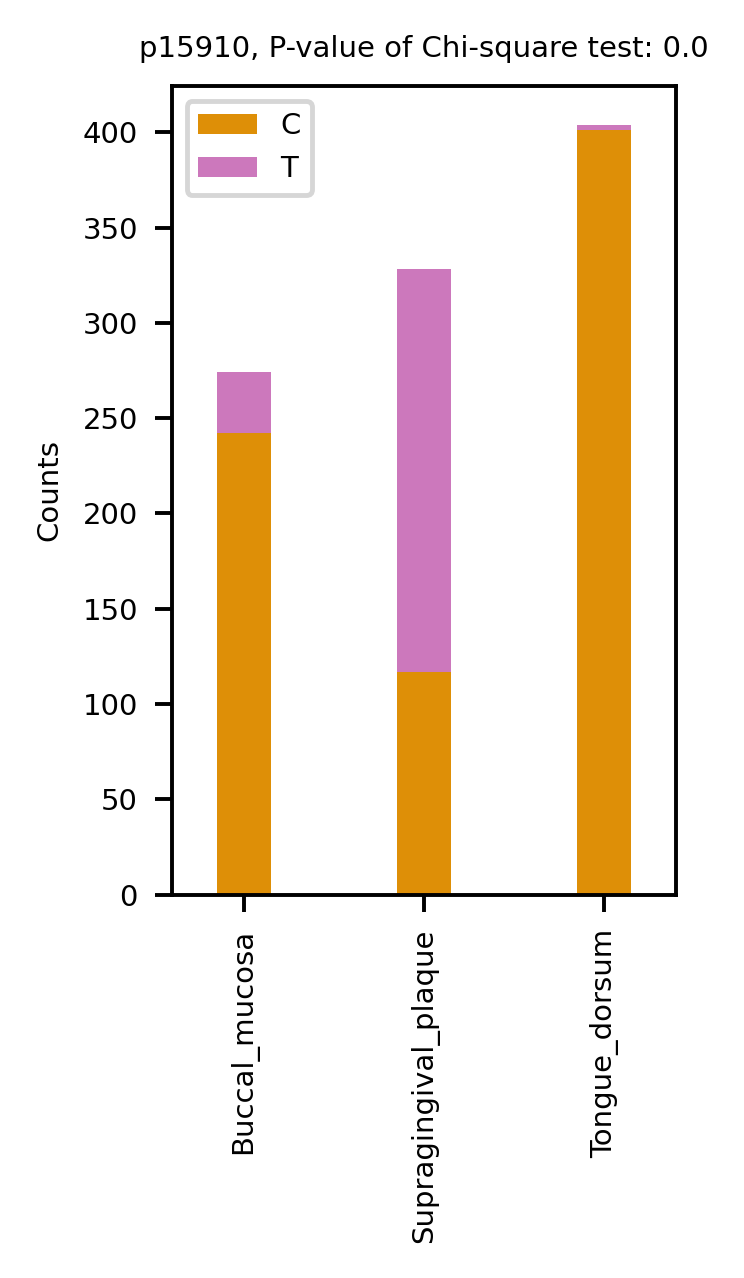

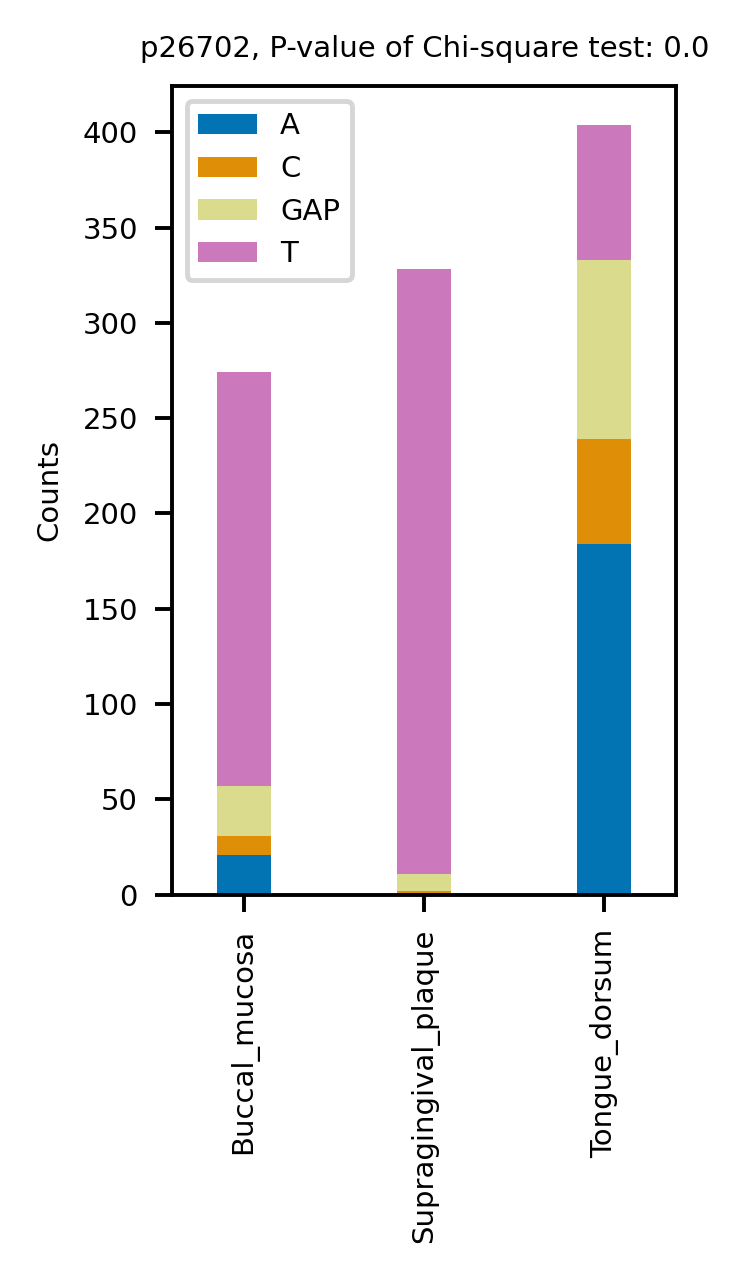

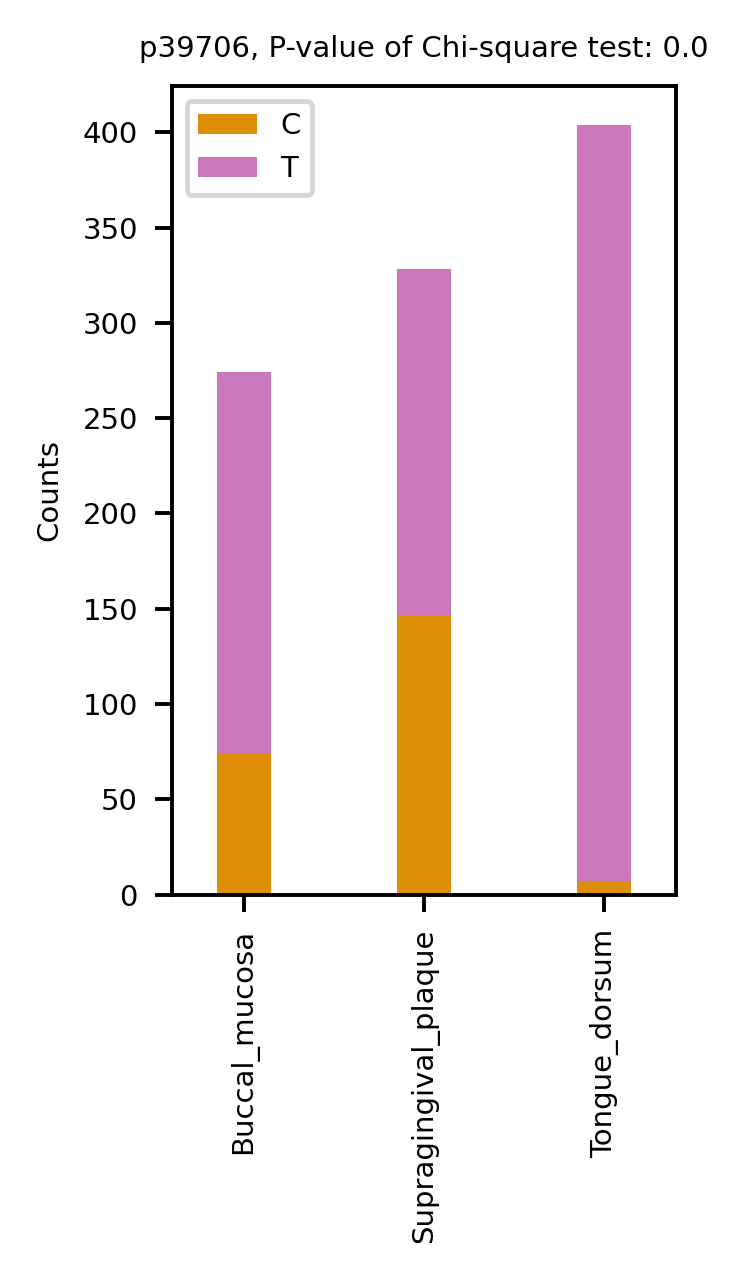

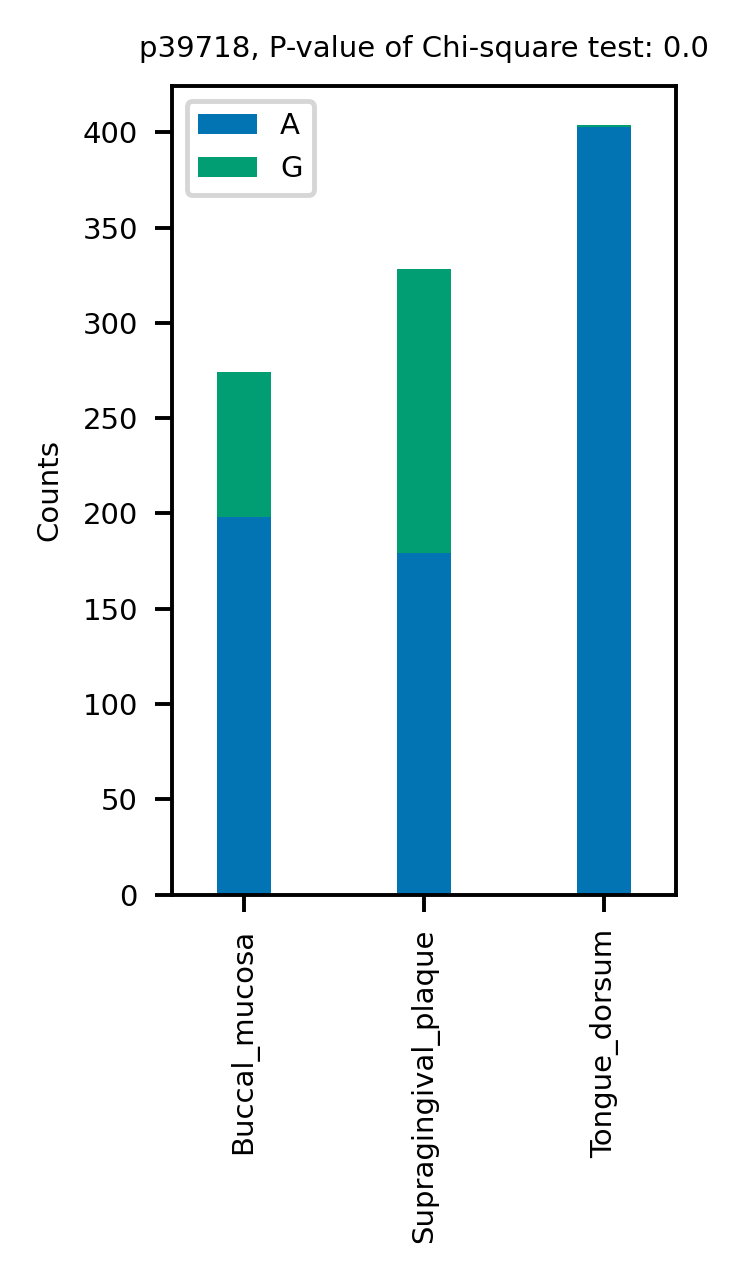

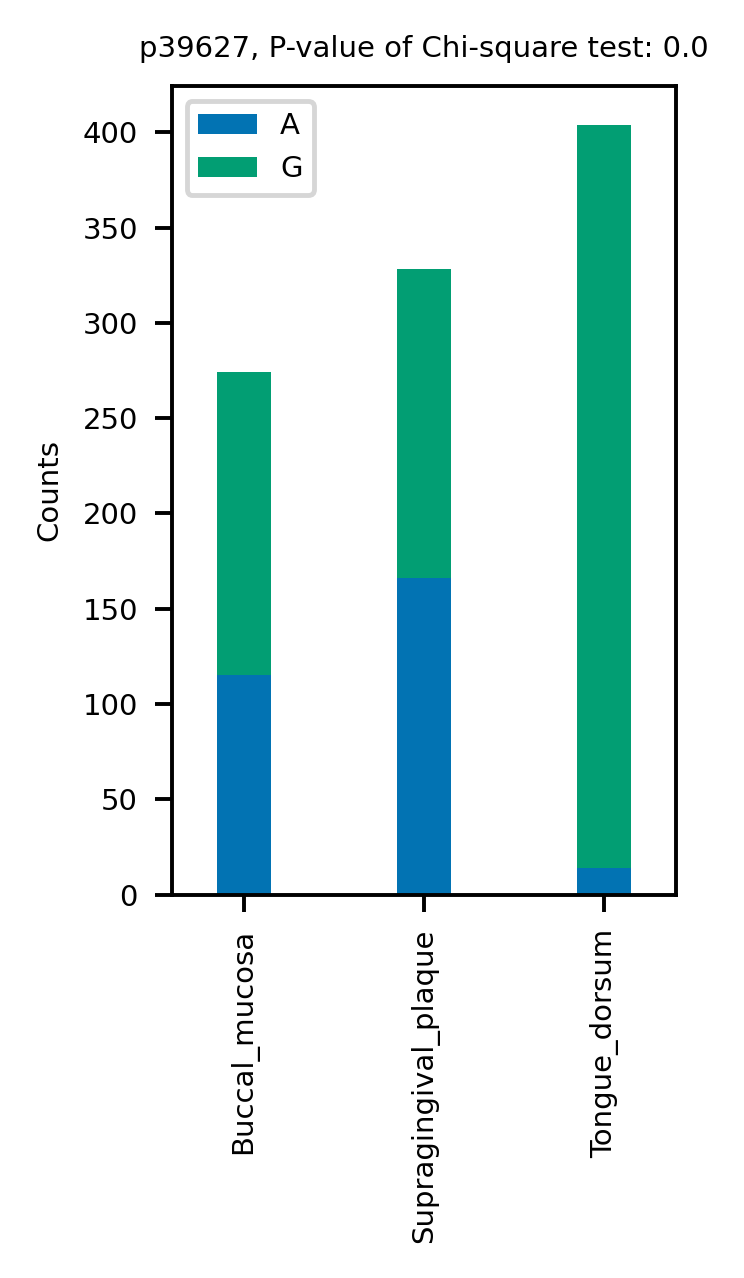

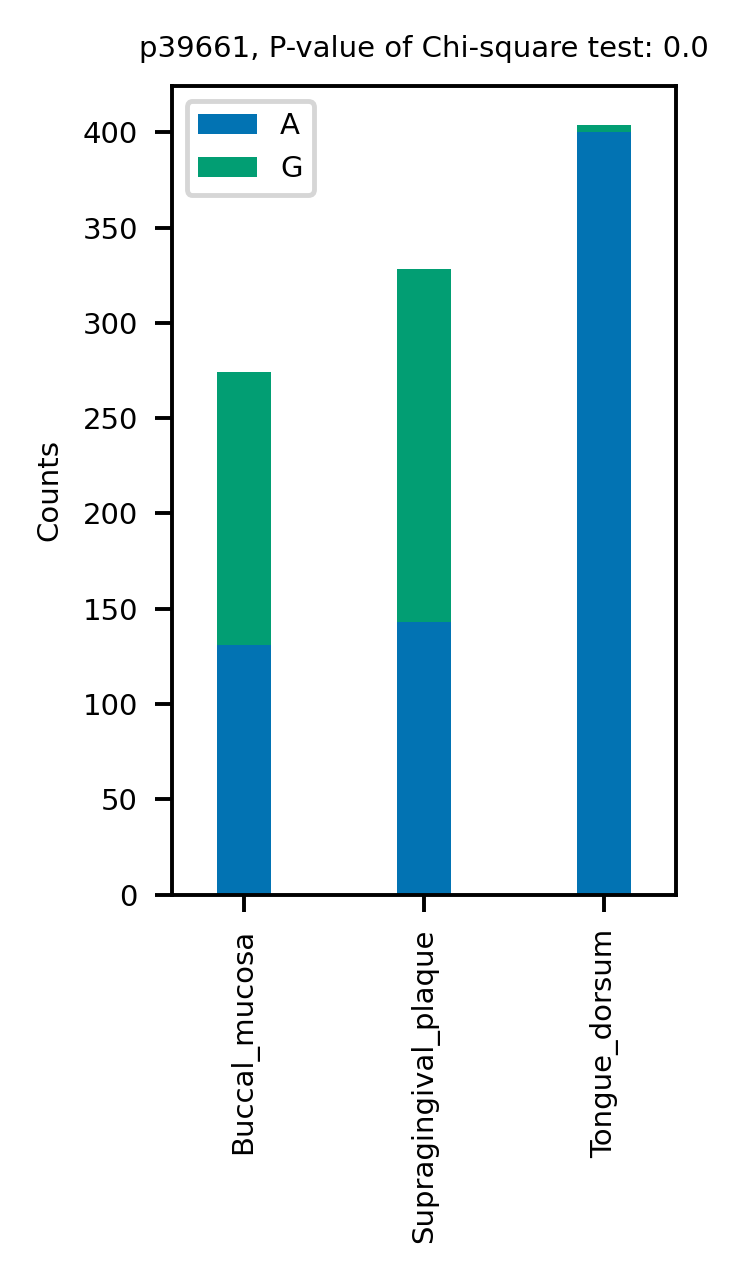

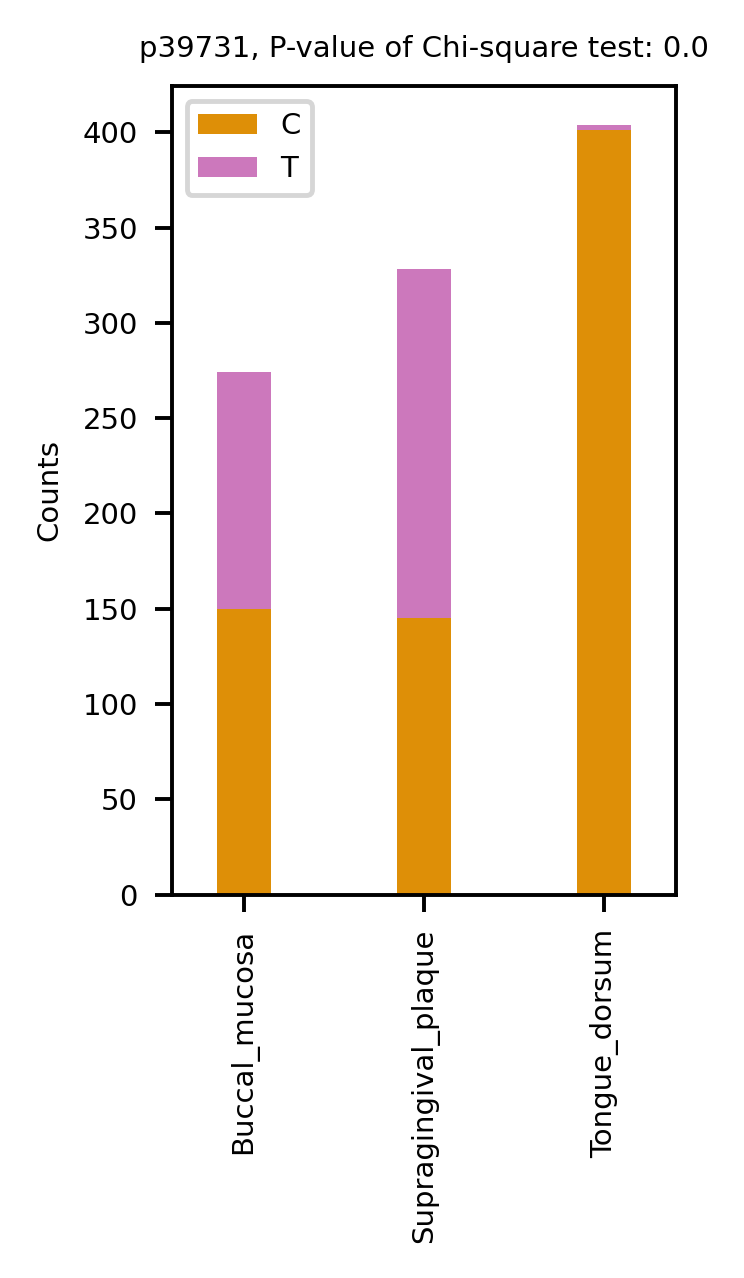

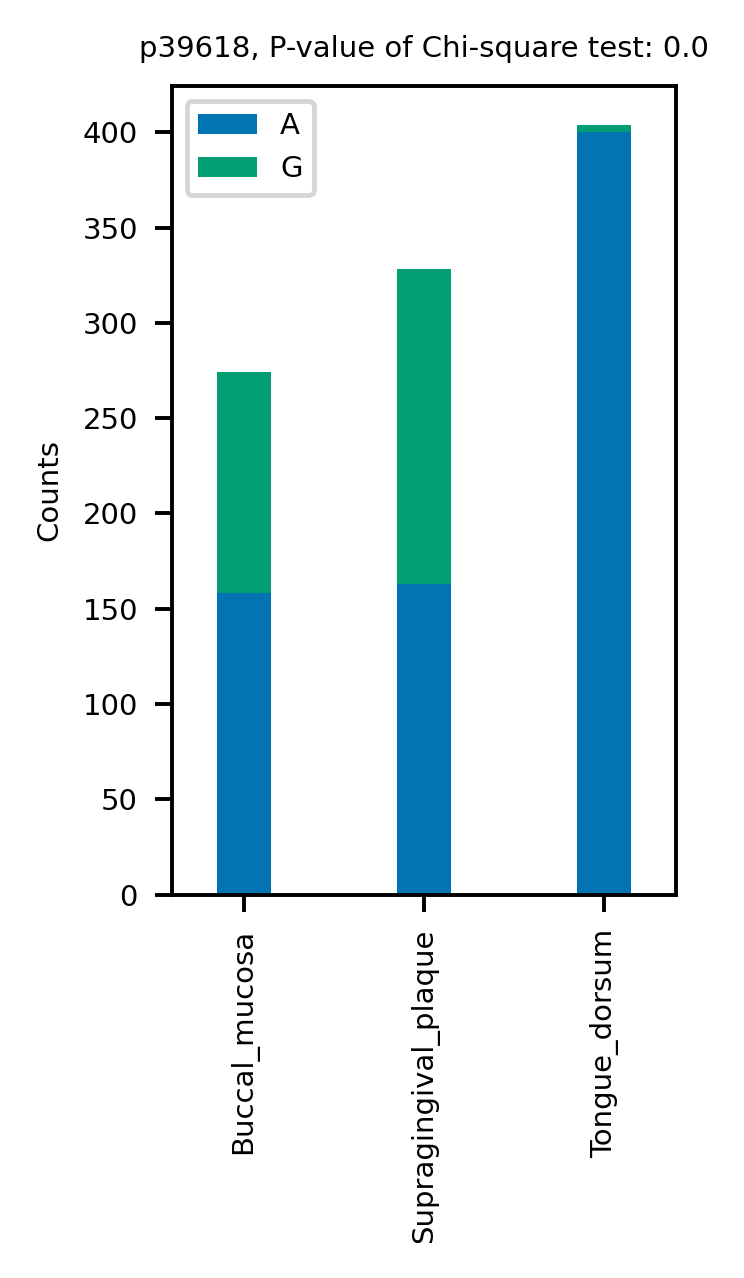

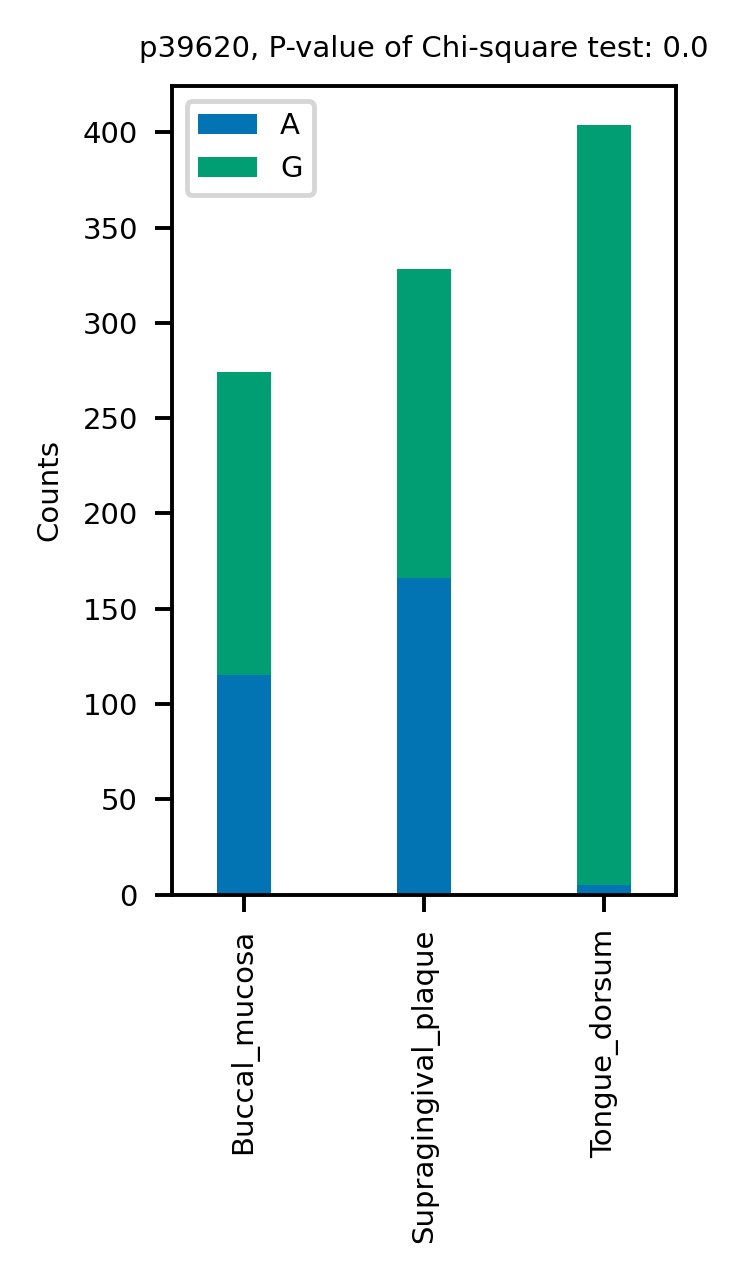

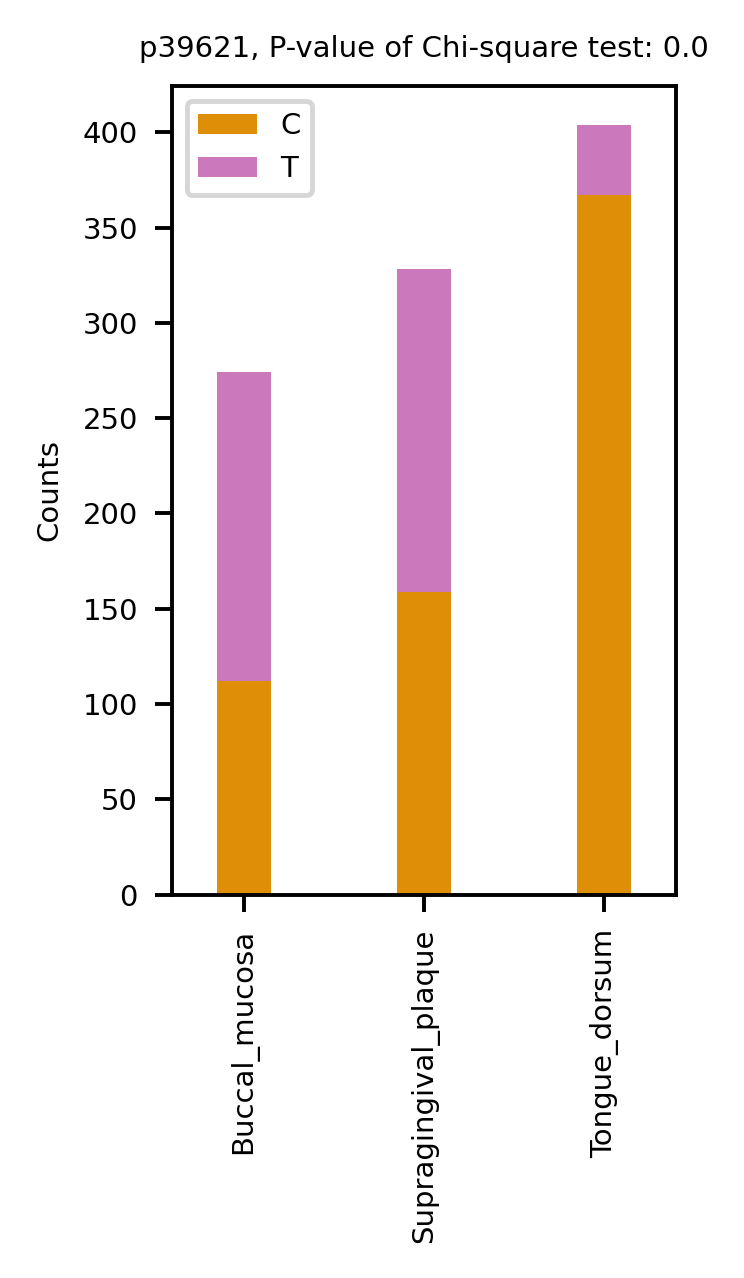

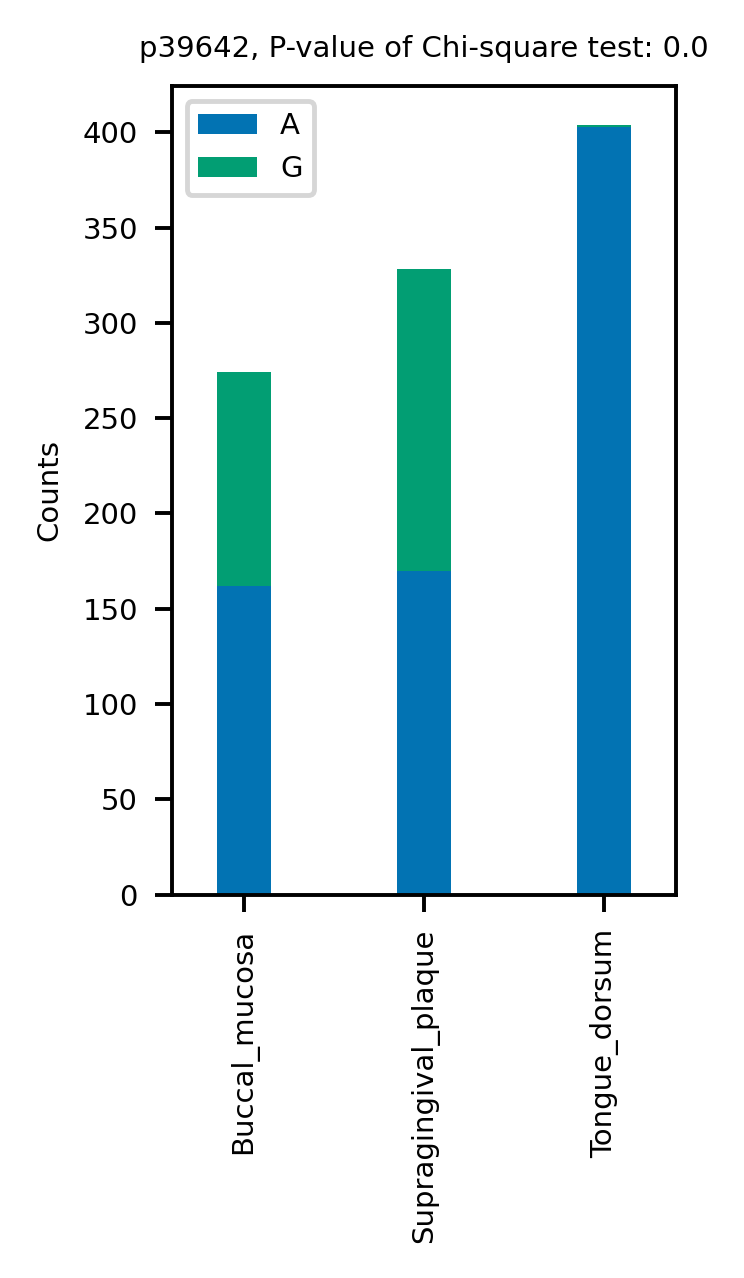

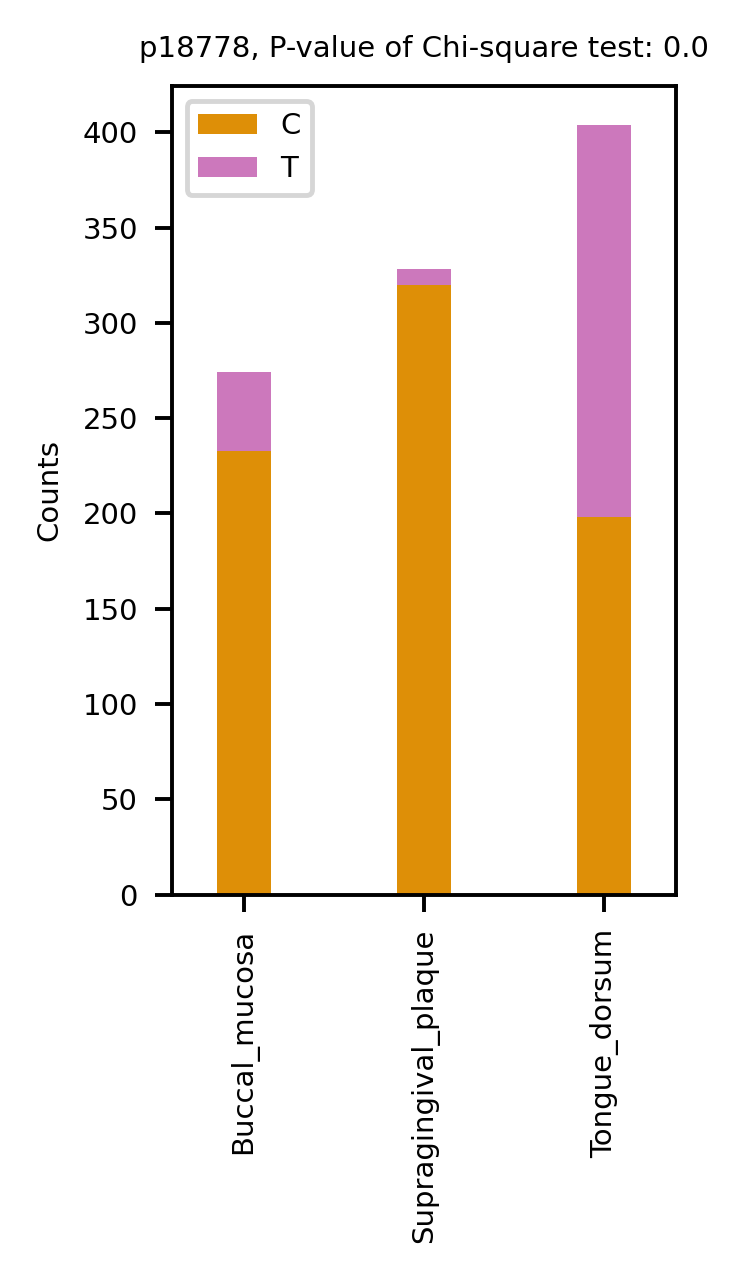

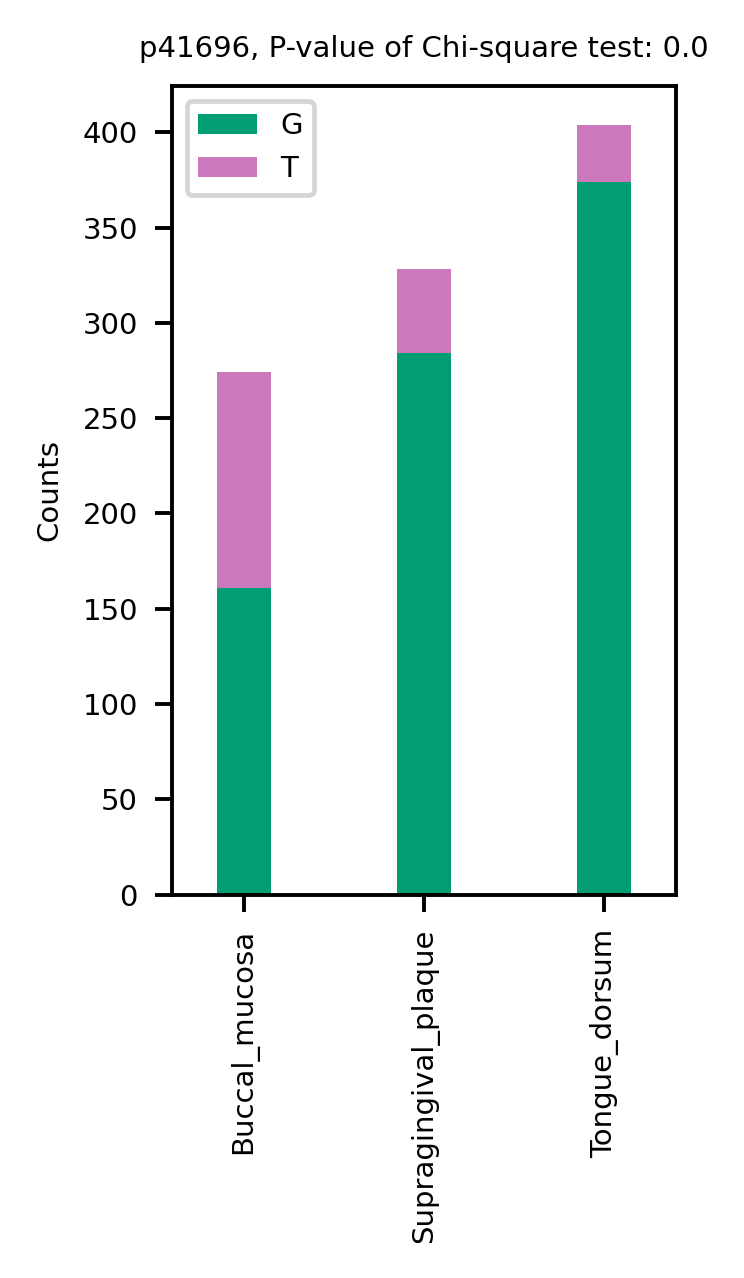

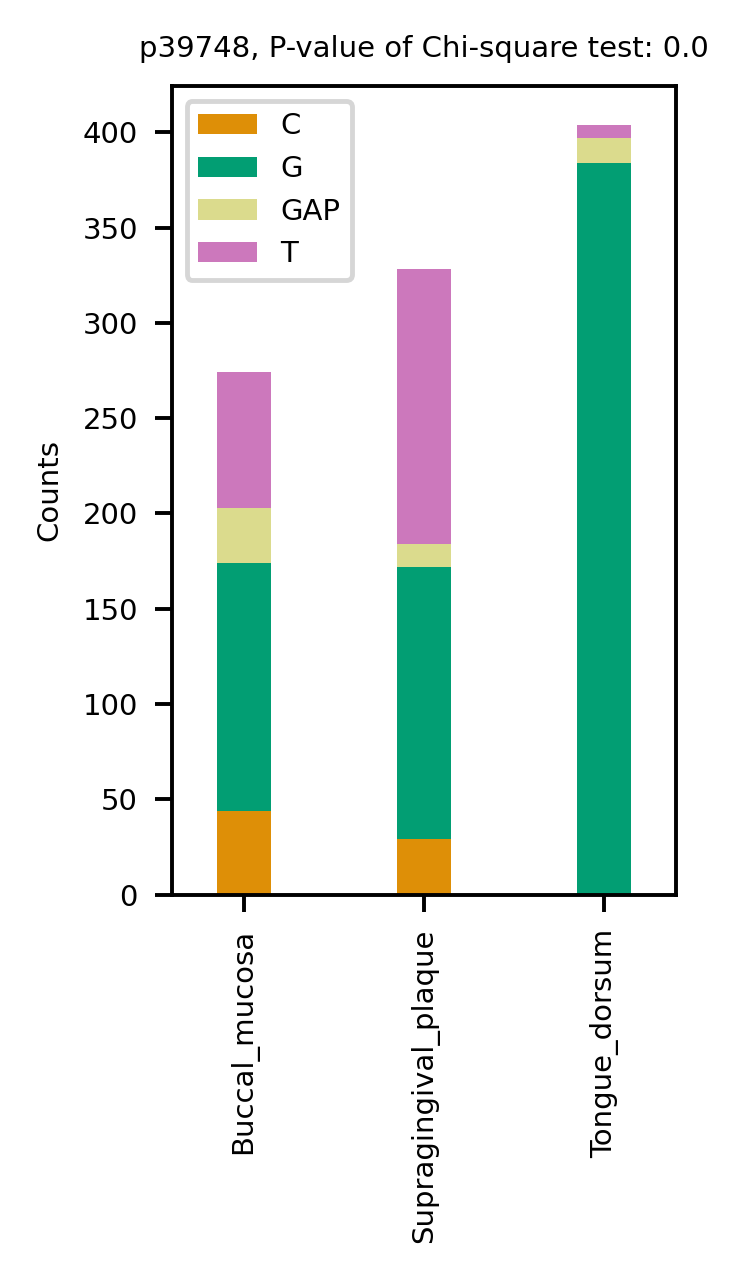

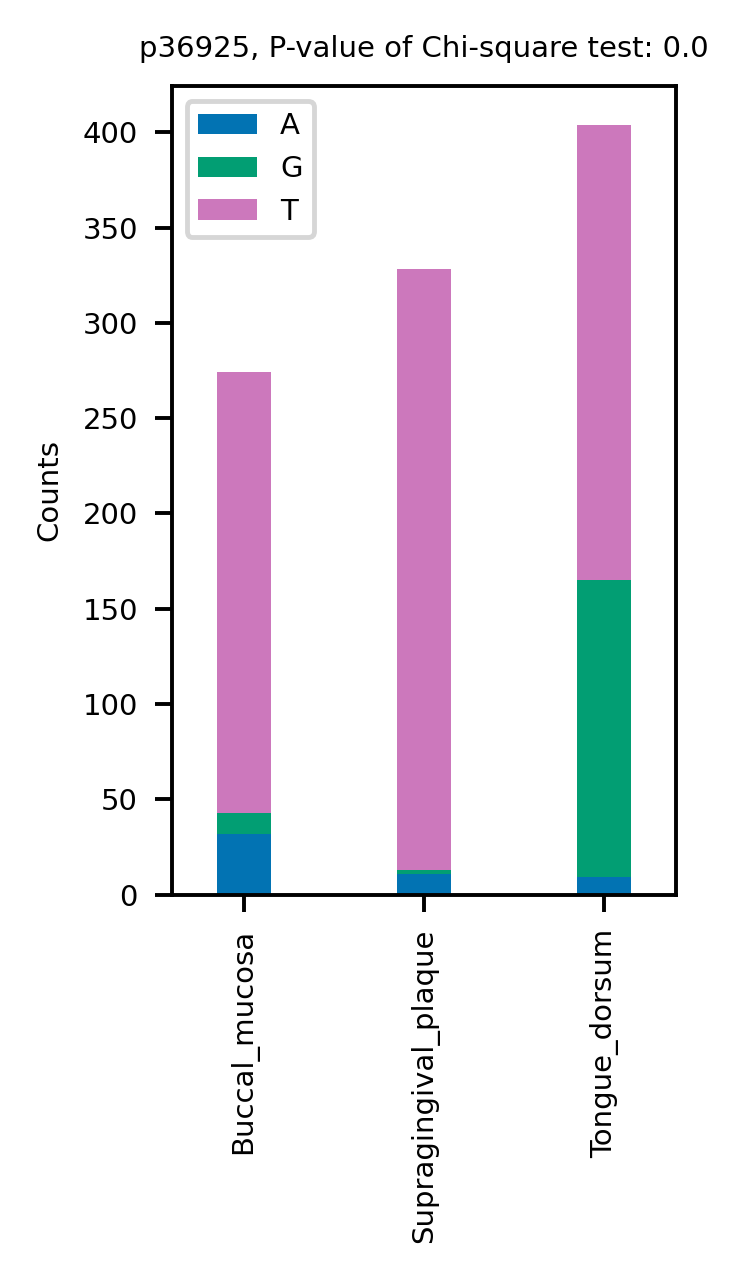

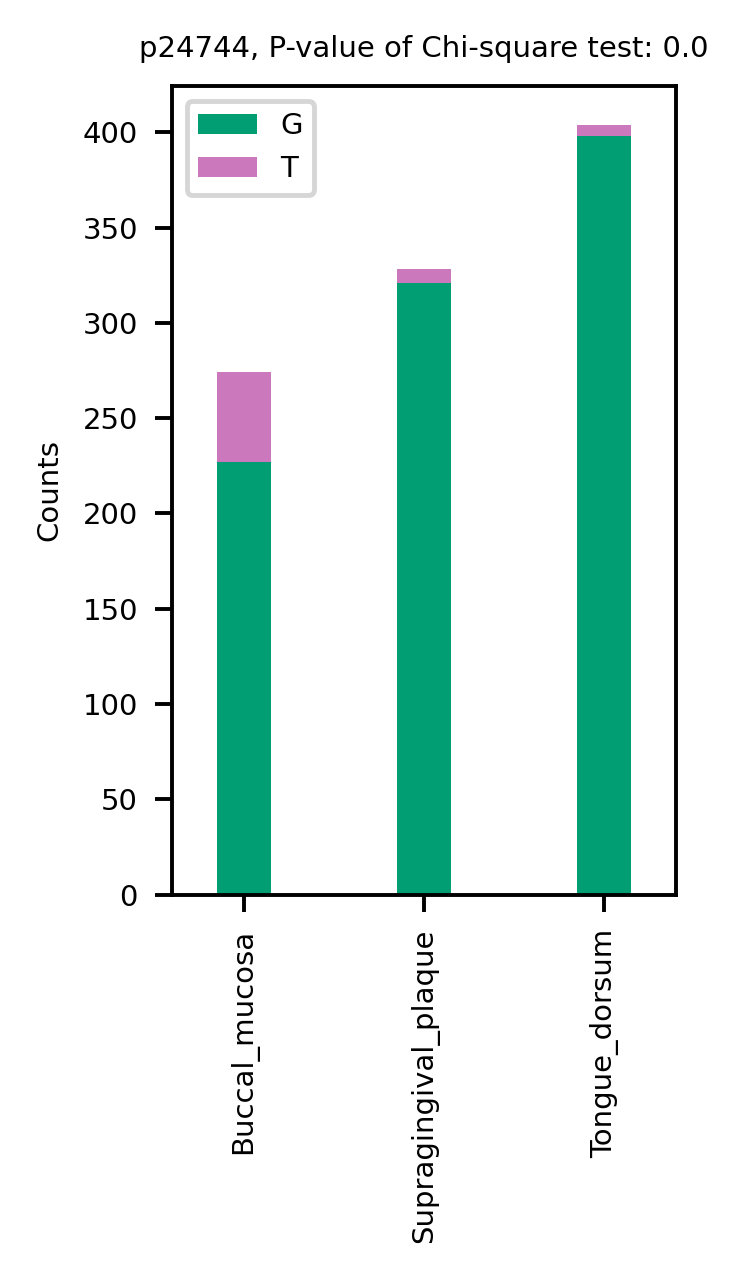

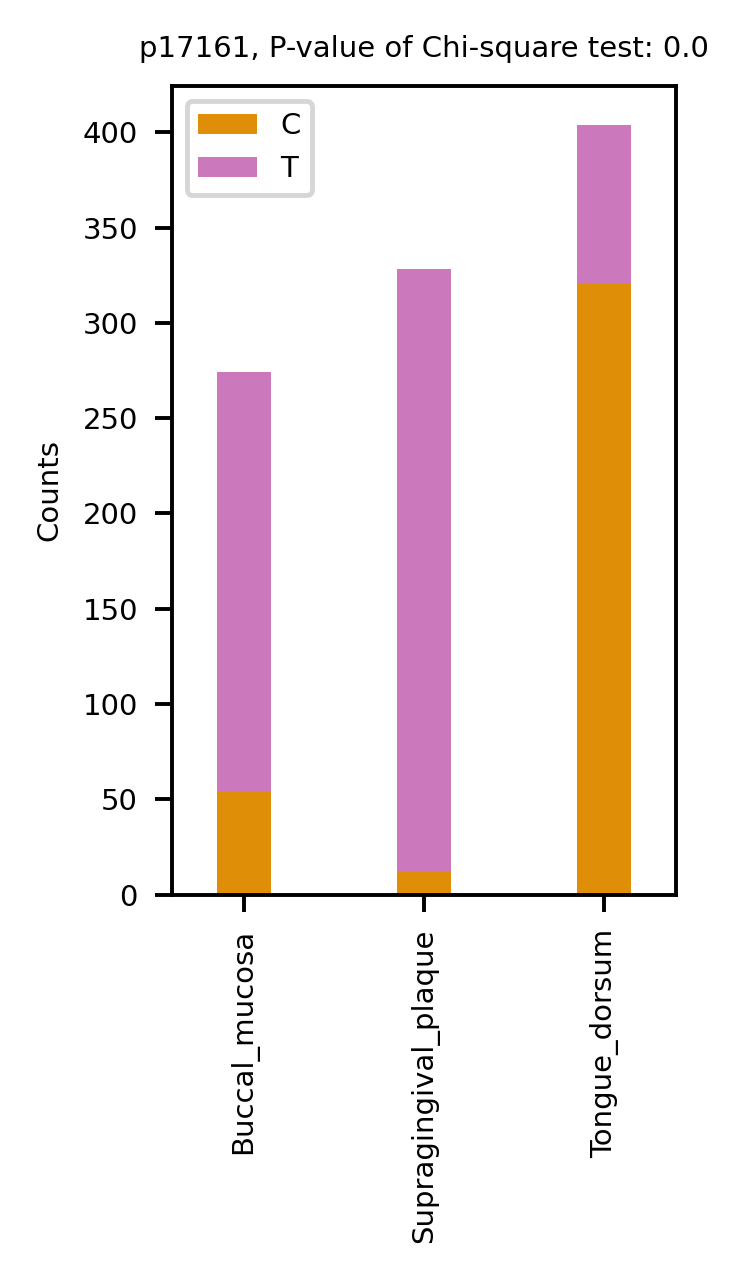

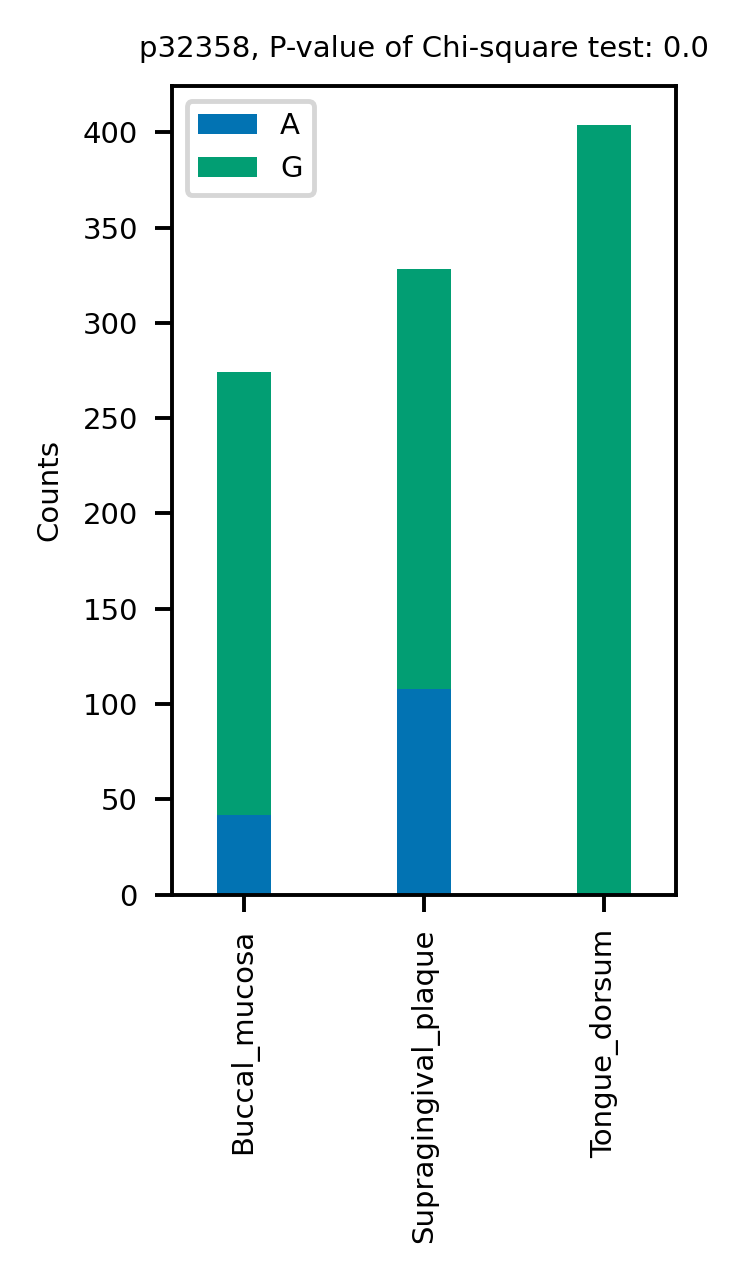

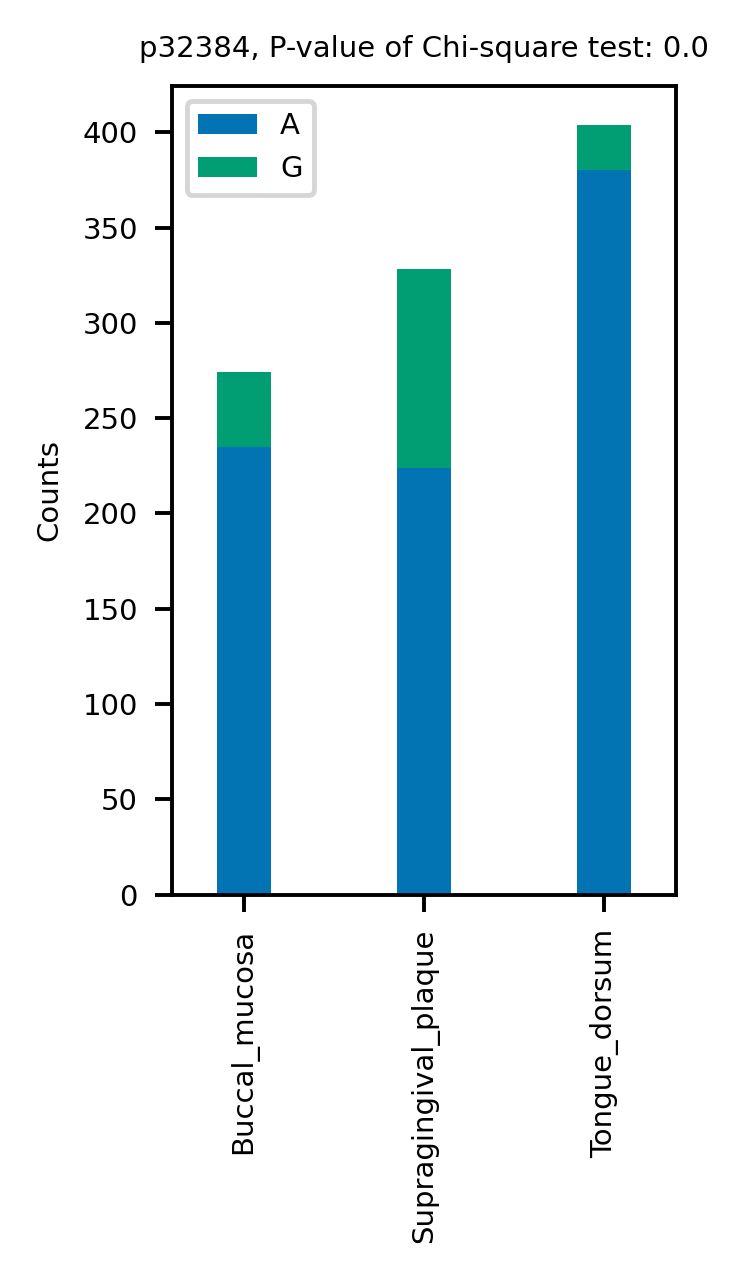

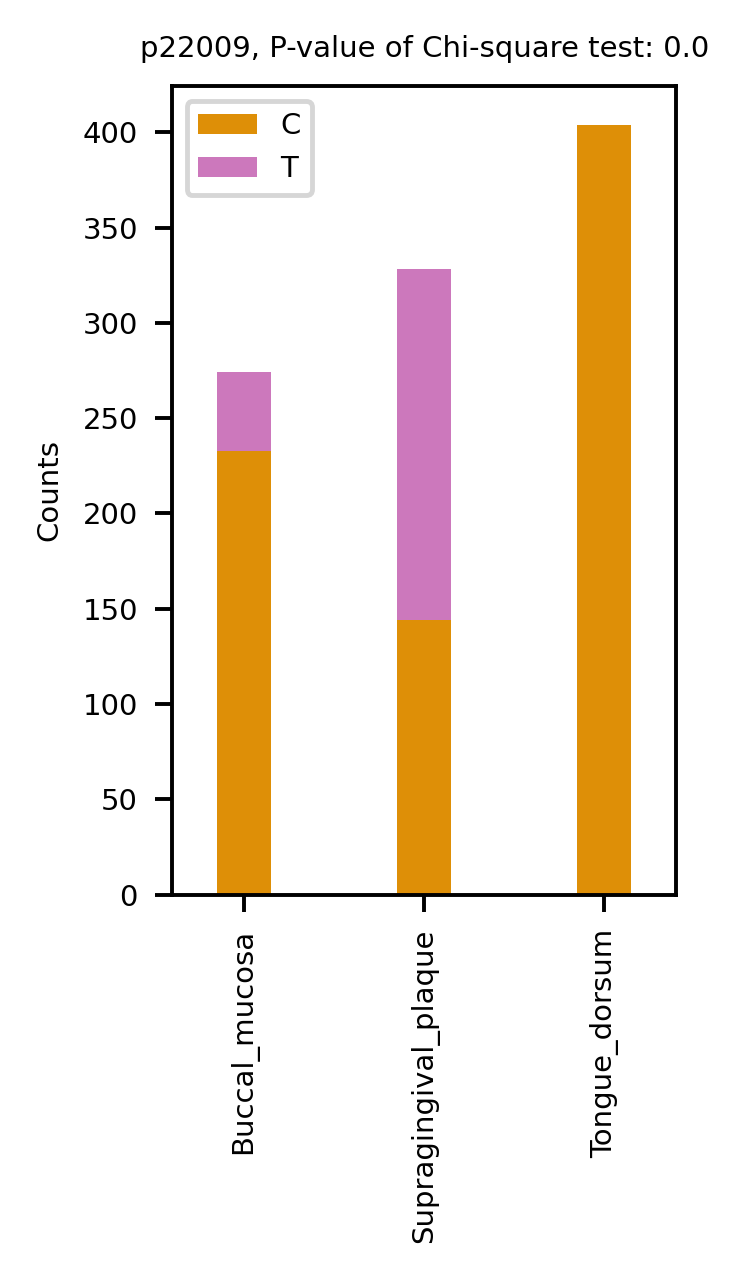

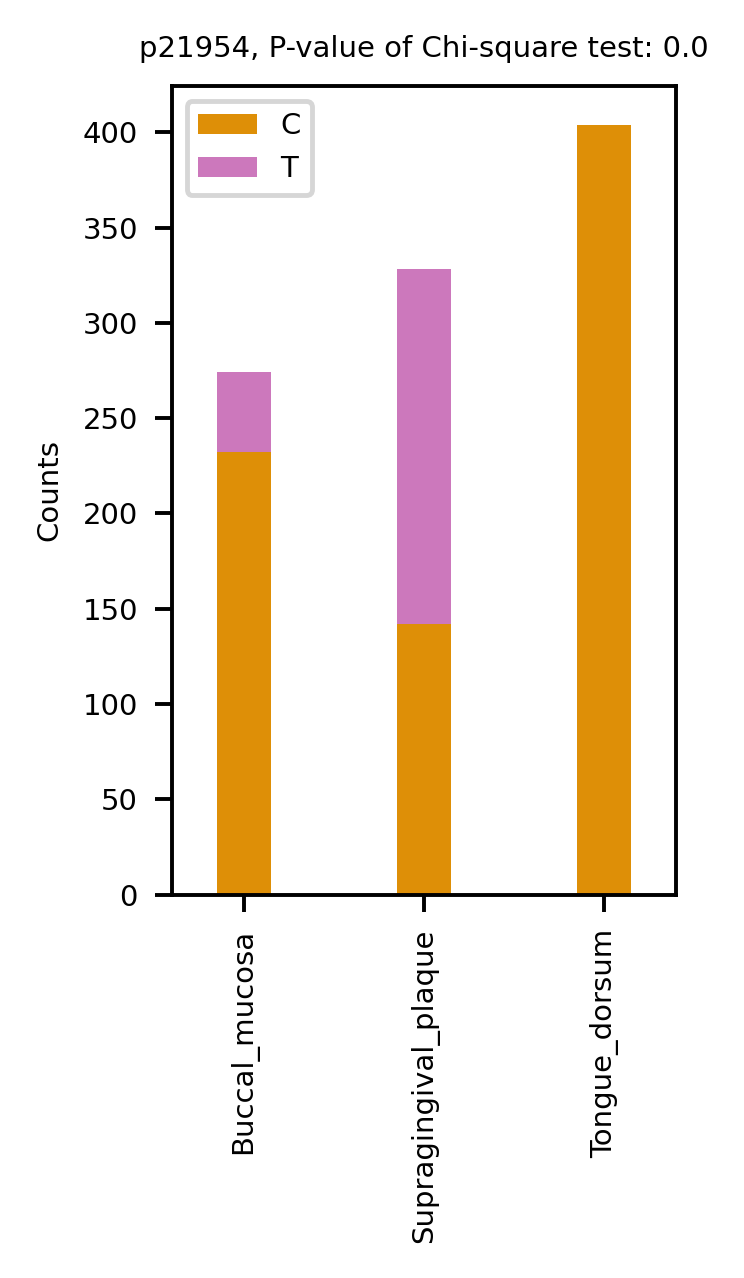

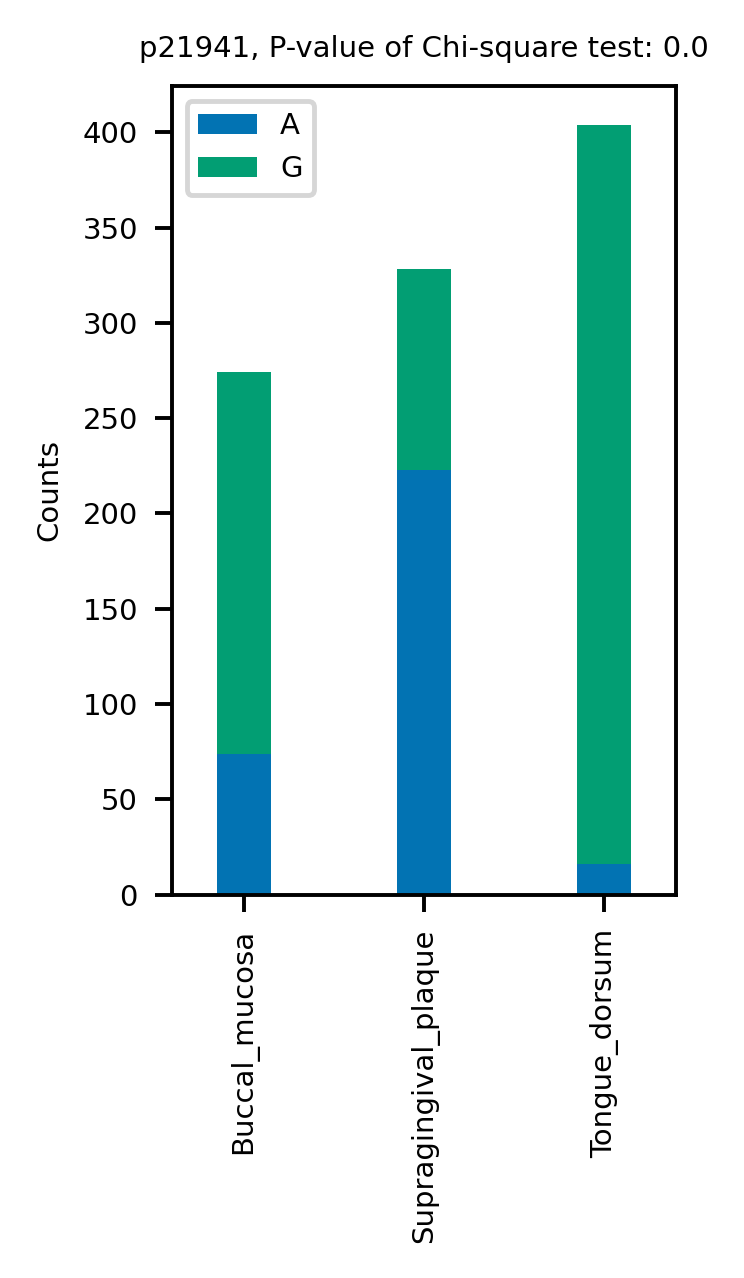

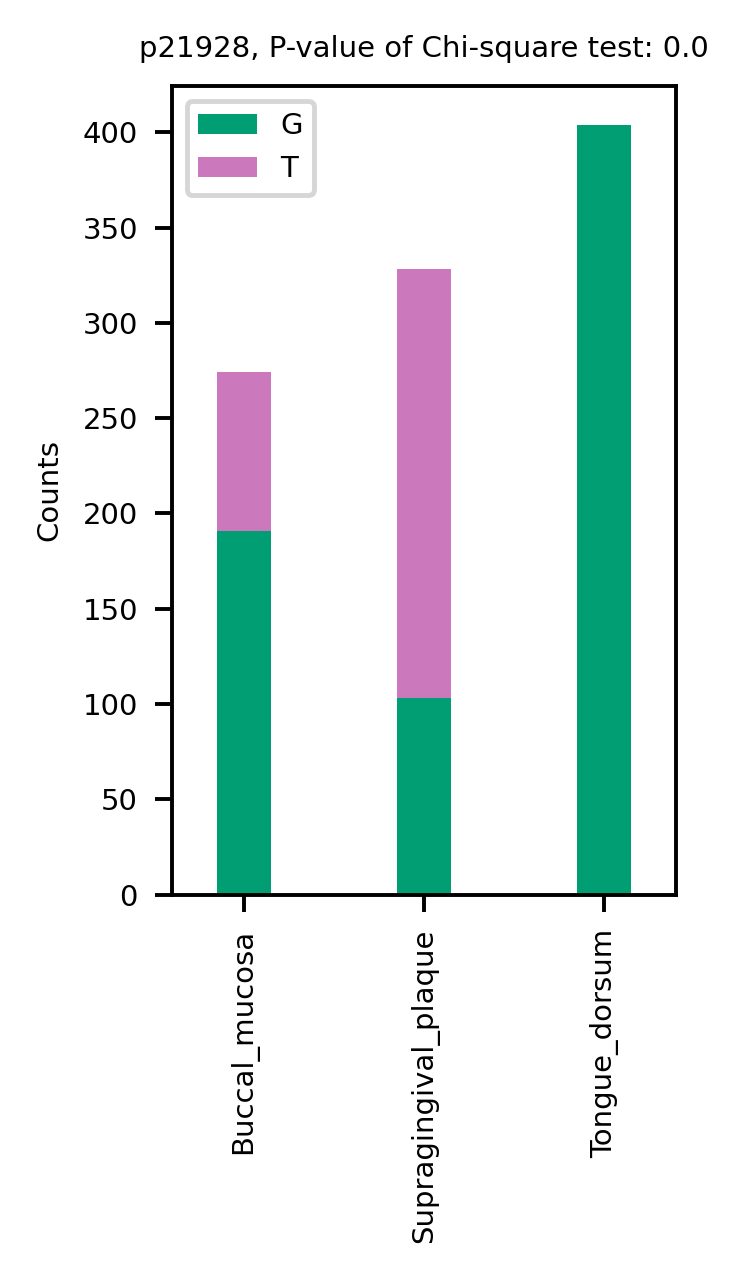

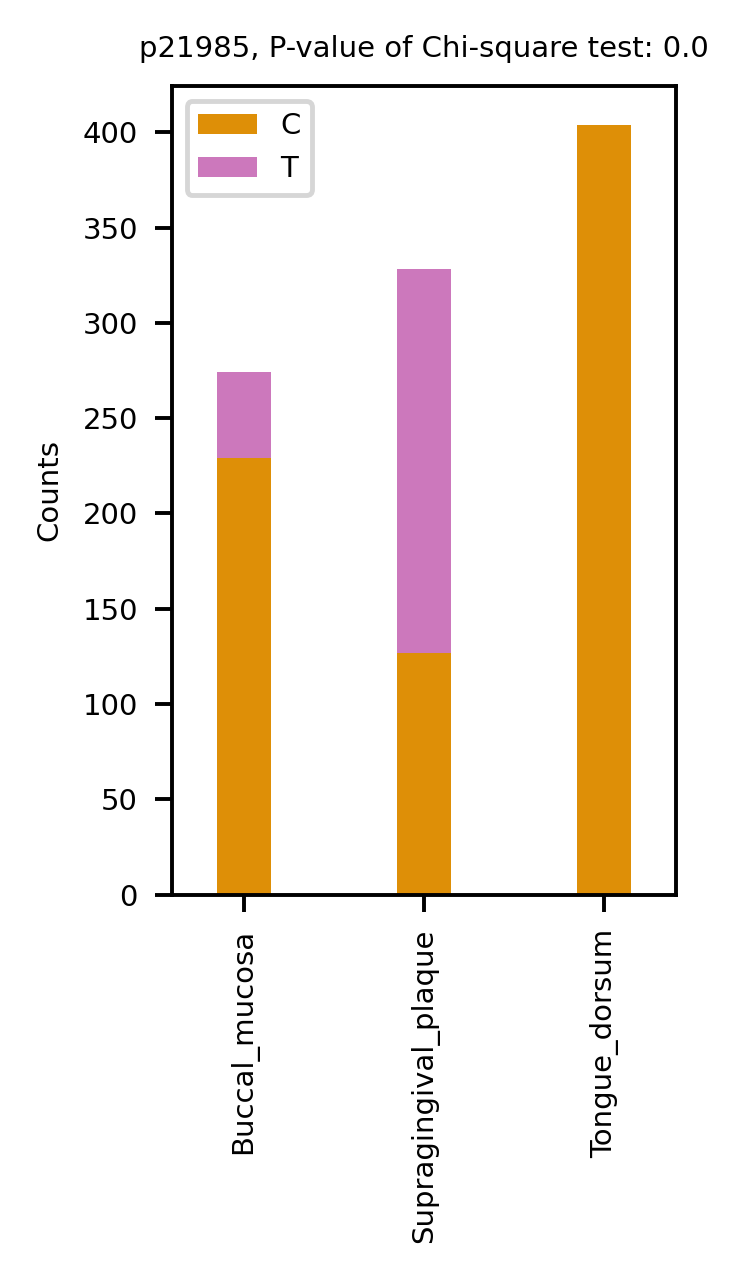

In [25]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y,
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=100,
                  figsize=(1.86, 3))

In [27]:
import joblib
load_gbc = joblib.load(report_dir+'/gbc.pkl')

In [28]:
load_gbc

Pipeline(memory='/Users/mbagh/Documents/RahLab/deepBreaks_data/hmp/s__Haemophilus_parainfluenzae_Body_site_2023-05-10_23-18-22',
         steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.05)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.05)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='cl')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('gbc', GradientBoostingClassifier(random_state=123))])